
# Analysis of data generated  from OSMR

https://github.com/osmr/imgclsmob





In [1]:
# Suppress the powerlaw package warnings
# "powerlaw.py:700: RuntimeWarning: divide by zero encountered in true_divide"
# "powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide"
import warnings
warnings.simplefilter(action='ignore', category=RuntimeWarning)

In [2]:
import numpy as np
import pandas as pd
import os, time
import datetime as dt
import itertools
import statsmodels.api as sm
from statsmodels.tools import eval_measures  # not working ?
from sklearn.metrics import mean_squared_error
from scipy.stats import kendalltau
from contextlib import redirect_stdout

import seaborn as sns
import statsmodels

from tqdm import tqdm

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)
logger.setLevel(logging.WARN)

%load_ext watermark
%watermark

Last updated: 2021-01-05T01:27:21.008733-08:00

Python implementation: CPython
Python version       : 3.7.6
IPython version      : 7.11.1

Compiler    : Clang 4.0.1 (tags/RELEASE_401/final)
OS          : Darwin
Release     : 17.7.0
Machine     : x86_64
Processor   : i386
CPU cores   : 12
Architecture: 64bit



###  Helper Notebook to make Plots


In [4]:
import import_ipynb
import ModelPlots as MP

importing Jupyter notebook from ModelPlots.ipynb


### To read the raw files generated

<pre>
pip install xlrd==1.2.0
</pre>

In [5]:
path = "./data/osmr"

In [6]:
df_all = pd.read_csv(path+"/df_all.csv")
df_all

Unnamed: 0          modelname     check  check_compound   checkTF  \
0             0  wrn28_10_cifar100  0.873725        0.773567  0.925764   
1             1      wrn28_10_svhn  0.601419        0.533661  0.449782   
2             2    wrn40_8_cifar10  0.532602        0.492409  0.326409   
3             3   wrn40_8_cifar100  0.791673        0.728488  0.952522   
4             4       wrn40_8_svhn  0.537902        0.495928  0.329377   
..          ...                ...       ...             ...       ...   
306         306        preresnet26  1.417044        0.871028  0.799257   
307         307     preresnetbc26b  1.923161        0.399779  0.514085   
308         308        preresnet34  1.210359        0.788568  0.847507   
309         309     preresnetbc38b  1.636872        0.357473  0.591398   
310         310        preresnet50  1.302540        0.298244  0.647826   

     checkTF_compound       norm  norm_compound   lognorm  lognorm_compound  \
0            0.812261  10.797475      10.652062  0.996938          0.988406   
1            0.394636   6.504677       6.296168  0.783711          0.766469   
2            0.298103   5.558056       5.492968  0.712637          0.708339   
3            0.869919   8.735812       8.755586  0.900006          0.899789   
4            0.300813   5.411185       5.329015  0.701243          0.694357   
..                ...        ...            ...       ...               ...   
306          0.820627   8.698458       8.658644  0.905574          0.890431   
307          0.267347   8.801484       8.730163  0.910042          0.890402   
308          0.860514   7.866827       7.894940  0.867597          0.860032   
309          0.286686   8.039993       7.766750  0.872862          0.848162   
310          0.296506   7.000760       6.925561  0.817860          0.804290   

     ...  sigma_mp  sigma_mp_compound  numofSpikes  numofSpikes_compound  \
0    ...  0.709364           0.667378     0.000000              0.000000   
1    ...  0.722710           0.692651     0.000000              0.000000   
2    ...  0.740547           0.719379     0.000000              0.000000   
3    ...  0.718941           0.689542     0.000000              0.000000   
4    ...  0.734079           0.713223     0.000000              0.000000   
..   ...       ...                ...          ...                   ...   
306  ...  0.921806           0.873345     2.231818              2.615079   
307  ...  0.863415           0.646415     5.827957             16.544061   
308  ...  0.922045           0.883865     1.500000              1.870370   
309  ...  0.856890           0.623130     4.978102             15.246612   
310  ...  0.842433           0.593998     4.966851             16.006289   

     ratio_numofSpikes  ratio_numofSpikes_compound  softrank_mp  \
0             0.000000                    0.000000   143.904470   
1             0.000000                    0.000000   336.553320   
2             0.000000                    0.000000   368.470762   
3             0.000000                    0.000000   173.518491   
4             0.000000                    0.000000   370.743275   
..                 ...                         ...          ...   
306           0.016345                    0.018776     0.968605   
307           0.029034                    0.073706     0.840359   
308           0.011611                    0.014262     1.261983   
309           0.023465                    0.067470     1.020744   
310           0.023362                    0.073795     1.397486   

     softrank_mp_compound  logpnorm  logpnorm_compound  
0              138.349114 -5.428285          -5.944612  
1              326.315932 -4.641690          -4.992451  
2              360.051882 -5.002736          -5.142759  
3              165.970009 -5.717918          -5.656400  
4              358.604449 -4.834103          -5.031324  
..                    ...       ...                ...  
306              0.926630  2.539925           2.38

In [7]:
for x in df_all.modelname.sort_values():
    if x.endswith("cub"):
        print(x)

mobilenet_w1_cub
ntsnet_cub
proxylessnas_mobile_cub
resnet10_cub
resnet12_cub
resnet14_cub
resnet16_cub
resnet18_cub
resnet26_cub
seresnet10_cub
seresnet12_cub
seresnet14_cub
seresnet16_cub
seresnet18_cub
seresnet26_cub


### Remove outliers

- EfficientNet b0 and b1
- ResNext CIFAR00 all models

In [8]:
print("before removing outliers, we have {} models".format(len(df_all)) )
bad_models = ['efficientnet_b0', 'efficientnet_b1']
bad_models.extend(['resnext272_2x32d_cifar100', 'resnext29_16x64d_cifar100','resnext29_32x4d_cifar100','resnext272_1x64d_cifar100'])
for mname in bad_models:
    df_all = df_all[df_all.modelname!=mname]
print("after removing outliers, we have {} models".format(len(df_all)) )


before removing outliers, we have 311 models
after removing outliers, we have 305 models


### Plots with Test Accuracies

- read the test accuracies directly from the IOSMR site

In [9]:
from bs4 import BeautifulSoup
import requests
import re

In [10]:
'''Load the test accuracies'''
url = "https://github.com/osmr/imgclsmob/blob/master/pytorch/README.md"
df_accuracy = pd.read_html(url)

In [11]:
'''Create the matchtable: Match the model name'''
response = requests.get(url)
page = str(BeautifulSoup(response.content, features="lxml"))

## To find the category of models to group when plotting
models = re.findall('<li>(.*) \(<a href=', page) 

## The naming convention is not very consistent, therefore, to help with identification,
## I input the exceptions
exceptions = {'SqueezeNext': 'SqNxt', 'DIA-ResNet': 'DIA-PreResNet', 
              'DarkNet Ref/Tiny/19': 'DarkNet Tiny', 
              'IBN-ResNet/IBN-ResNeXt/IBN-DenseNet': 'IBN(b)-ResNet'} 
models_ = [m if m not in exceptions.keys() else m+'/'+exceptions[m] for m in models]
models_ = [m.split('/') for m in models_]

## Use reg exp to extract the dataset name, modelnames (used in README), and 
## modelnames (used in codes)
datasets = re.findall('<h3><a aria-hidden="true" class="anchor" href="#(.*)" id', page)
lst1_name = re.findall('<tr>\n<td>(.*)</td>', page)
lst2_name = re.findall('\n<td>.* \(<a href="(.*)">log</a>\)</td>\n</tr>', page)

if len(lst1_name) != len(lst2_name):
    print('Number does not match!')

df_table = pd.DataFrame(lst1_name, columns = ['Model'])

## Note: there are duplicate Model names, hence cannot use merge naively
df_table['modelname'] = [m.split('/')[-1][:-22] for m in lst2_name]

In [12]:
'''Identify the architexture for each pretrained model'''
class ContinueI(Exception):
    pass

continue_i = ContinueI()

arch = []
for i in range(len(df_table)):
    try:
        for mm in models_:
            for m1 in mm:
                ## Name convention 1: the model name starts with the arch name
                if df_table.loc[i, 'Model'].startswith(m1): 
                    arch.append(mm)
                    raise continue_i
        try:
            ## Name convention 2: if the model name starts with number, 
            ## the arch name is in the middle of the model name
            this = re.findall('[0-9]+-(.*)', df_table.loc[i, 'Model'])[0]
        except:
            arch.append(np.nan)
            raise continue_i

        for mm in models_:
            for m1 in mm:
                if this.startswith(m1):
                    arch.append(mm)

                    raise continue_i

        arch.append(np.nan)

    except ContinueI:
        continue

df_table['group'] = arch
df_table['group'] = df_table['group'].apply(lambda x: '/'.join(x))

In [13]:
df_table

Model                                    modelname  \
0                    AlexNet                                      alexnet   
1                  AlexNet-b                                     alexnetb   
2                      ZFNet                                        zfnet   
3                    ZFNet-b                                       zfnetb   
4                     VGG-11                                        vgg11   
..                       ...                                          ...   
555       SimplePose(Mobile)  simplepose_mobile_mobilenetv3_small_w1_coco   
556       SimplePose(Mobile)  simplepose_mobile_mobilenetv3_large_w1_coco   
557  Lightweight OpenPose 2D           lwopenpose2d_mobilenet_cmupan_coco   
558  Lightweight OpenPose 3D           lwopenpose3d_mobilenet_cmupan_coco   
559                  IBPPose                                 ibppose_coco   

                    group  
0                 AlexNet  
1                 AlexNet  
2                   ZFNet  
3                   ZFNet  
4              VGG/BN-VGG  
..                    ...  
555            SimplePose  
556            SimplePose  
557  Lightweight OpenPose  
558  Lightweight OpenPose  
559               IBPPose  

[560 rows x 3 columns]

In [14]:
'''Match the model name using matchtable'''
# df_all = pd.read_excel(path + '/df_all.xlsx').rename(columns = {'Unnamed: 0': 'index'}).set_index('index')
df_all['spectralnormlog'] = np.log(df_all['spectralnorm'])

df_full = []
i = 0

for df in df_accuracy:
    # Because there are duplicate Model names (on README), you cannot
    # simply use merge
    df = df.copy()
    df['modelname'] = df_table.loc[i:i+len(df)-1, 'modelname'].tolist()#temp[i:i+len(df)]
    df['group'] = df_table.loc[i:i+len(df)-1, 'group'].tolist()
    i += len(df)

    del df['Remarks']

    df = df.merge(df_all, on = 'modelname', how = 'left')

    df_full.append(df)

df_full = dict(zip(datasets, df_full))

In [15]:
df_full['imagenet-1k']

Model   Top1   Top5     Params     FLOPs/2    modelname  \
0           AlexNet  38.50  16.64   62378344   1,132.33M      alexnet   
1         AlexNet-b  39.74  17.47   61100840     714.83M     alexnetb   
2             ZFNet  39.79  17.27   62357608   1,170.33M        zfnet   
3           ZFNet-b  36.37  14.90  107627624   2,479.13M       zfnetb   
4            VGG-11  29.90  10.36  132863336   7,615.87M        vgg11   
..              ...    ...    ...        ...         ...          ...   
301  ResNet(A)-101b  19.78   5.03   44568392   8,072.93M  resneta101b   
302  ResNet(A)-152b  19.62   4.82   60212040  11,796.83M  resneta152b   
303   ResNet(D)-50b  21.04   5.65   25680808  20,497.60M   resnetd50b   
304  ResNet(D)-101b  19.59   4.73   44672936  35,392.65M  resnetd101b   
305  ResNet(D)-152b  19.42   4.82   60316584  47,662.18M  resnetd152b   

          group  Unnamed: 0     check  check_compound  ...  sigma_mp_compound  \
0       AlexNet        50.0  6.312063        1.803071  ...           0.724677   
1       AlexNet        51.0  5.415376        1.641999  ...           0.743370   
2         ZFNet        52.0  4.725841        1.786327  ...           0.719677   
3         ZFNet        53.0  5.037417        1.844308  ...           0.650784   
4    VGG/BN-VGG        54.0  1.943881        1.474718  ...           0.757683   
..          ...         ...       ...             ...  ...                ...   
301      ResNet         NaN       NaN             NaN  ...                NaN   
302      ResNet         NaN       NaN             NaN  ...                NaN   
303      ResNet       247.0  0.734454        0.317371  ...           0.583746   
304      ResNet       248.0  0.518111        0.222608  ...           0.540957   
305      ResNet       249.0  0.435782        0.186991  ...           0.520966   

     numofSpikes  numofSpikes_compound  ratio_numofSpikes  \
0      39.181818             93.934603           0.221105   
1      32.581818             96.579048           0.224065   
2      40.036364             92.902857           0.225115   
3      63.672727            132.488889           0.265277   
4      31.818182             87.777778           0.132913   
..           ...                   ...                ...   
301          NaN                   NaN                NaN   
302          NaN                   NaN                NaN   
303     7.703518             24.818182           0.037639   
304     4.624352             15.430818           0.022697   
305     3.502618             11.917197           0.017155   

     ratio_numofSpikes_compound  softrank_mp  softrank_mp_compound  logpnorm  \
0                      0.142307     0.123766              0.121950  3.811582   
1                      0.145615     0.151018              0.130632  3.551809   
2                      0.144605     0.108592              0.113837  4.081376   
3                      0.182669     0.063393              0.074588  4.095295   
4                      0.131504     0.196762              0.169916  3.634474   
..                          ...          ...                   ...       ...   
301                         NaN          NaN                   NaN       NaN   
302                         NaN          NaN                   NaN       NaN   
303                    0.093492     1.185150              0.684582  1.803401   
304                    0.061941     1.952303              1.016048  0.886480   
305                    0.049233     2.374527              1.203890  0.490987   

     logpnorm_compound  spectralnormlog  
0             3.626827         4.701469  
1             3.467992         4.389939  
2             3.739922         4.345286  
3             3.805100         4.512583  
4             3.530661         3.256282  
..                 ...              ...  
301                NaN              NaN  
302                NaN              NaN  
303           1.385736         1.449708  
304           0.387835         0.874076  
305     

In [16]:
df_full['cub-200-2011']

Model  Error, %    Params     FLOPs/2  \
0             ResNet-10     27.77   5008392     893.63M   
1             ResNet-12     27.27   5082376   1,125.84M   
2             ResNet-14     24.77   5377800   1,357.53M   
3             ResNet-16     23.65   6558472   1,588.93M   
4             ResNet-18     23.33  11279112   1,820.00M   
5             ResNet-26     23.16  17549832   2,746.38M   
6          SE-ResNet-10     27.72   5052932     893.86M   
7          SE-ResNet-12     26.51   5127496   1,126.17M   
8          SE-ResNet-14     24.16   5425104   1,357.92M   
9          SE-ResNet-16     23.32   6614240   1,589.35M   
10         SE-ResNet-18     23.52  11368192   1,820.47M   
11         SE-ResNet-26     22.99  17683452   2,747.08M   
12       MobileNet x1.0     23.77   3411976     578.98M   
13  ProxylessNAS Mobile     22.66   3055712     331.44M   
14              NTS-Net     12.77  28623333  33,361.79M   

                  modelname                                    group  \
0              resnet10_cub                                   ResNet   
1              resnet12_cub                                   ResNet   
2              resnet14_cub                                   ResNet   
3              resnet16_cub                                   ResNet   
4              resnet18_cub                                   ResNet   
5              resnet26_cub                                   ResNet   
6            seresnet10_cub  SENet/SE-ResNet/SE-PreResNet/SE-ResNeXt   
7            seresnet12_cub  SENet/SE-ResNet/SE-PreResNet/SE-ResNeXt   
8            seresnet14_cub  SENet/SE-ResNet/SE-PreResNet/SE-ResNeXt   
9            seresnet16_cub  SENet/SE-ResNet/SE-PreResNet/SE-ResNeXt   
10           seresnet18_cub  SENet/SE-ResNet/SE-PreResNet/SE-ResNeXt   
11           seresnet26_cub  SENet/SE-ResNet/SE-PreResNet/SE-ResNeXt   
12         mobilenet_w1_cub                                MobileNet   
13  proxylessnas_mobile_cub                             ProxylessNAS   
14               ntsnet_cub                                  NTS-Net   

    Unnamed: 0     check  check_compound   checkTF  ...  sigma_mp_compound  \
0          115  0.833250        0.395363  0.424000  ...           0.489566   
1          116  0.725372        0.372030  0.314685  ...           0.524564   
2          117  0.612102        0.325685  0.204969  ...           0.553269   
3          118  0.506545        0.281597  0.184358  ...           0.578787   
4          119  0.449721        0.252917  0.172589  ...           0.603118   
5          120  0.398146        0.238577  0.133829  ...           0.654806   
6          121  0.710078        0.243378  0.300752  ...           0.490595   
7          122  0.628034        0.226707  0.241830  ...           0.525532   
8          123  0.579189        0.210430  0.225434  ...           0.554325   
9          124  0.528541        0.194415  0.176166  ...           0.578927   
10         125  0.439925        0.160712  0.159624  ...           0.599808   
11         126  0.319108        0.121688  0.122867  ...           0.651353   
12         127  0.379121        0.082882  0.391304  ...           0.589369   
13         128  0.177894        0.043871  0.180000  ...           0.300000   
14         129  1.308106        0.330288  0.675573  ...           0.449444   

    numofSpikes  numofSpikes_compound  ratio_numofSpikes  \
0           0.0                   0.0                0.0   
1           0.0                   0.0                0.0   
2           0.0                   0.0                0.0   
3           0.0                   0.0                0.0   
4           0.0                   0.0                0.0   
5           0.0                   0.0                0.0   
6           0.0                   0.0                0.0   
7           0.0                   0.0                0.0   
8           0.0                   0.0                0.0   
9           0.0                   0.0                0.0   
10         

In [17]:
for dataset, df in df_full.items():
    print(dataset, len(df))

imagenet-1k 306
cifar-10 70
cifar-100 68
svhn 63
cub-200-2011 15
pascal-voc20102 4
ade20k 6
cityscapes 6
coco-semantic-segmentation 4
celebamask-hq 1
coco-keypoints-detection 17


### Plots

In [18]:
'''[SETUP CELL] Start Plotting'''
metrics = ['alpha', 'alpha_weighted', 'spectralnormlog', 'softrank', 'norm', 'norm_compound' ] #specify the ww matrics
metrics_acc = ['Top1', 'Top5', 'Error, %', 'Pix.Acc.,%', 'mIoU,%'] #specify the test accuracy

metrics = ['alpha', 'alpha_weighted', 'spectralnormlog',  'softranklog',  'lognorm' ,'logpnorm' ] #specify the ww matrics
metrics_acc = ['Top1', 'Error, %', 'Pix.Acc.,%', 'mIoU,%'] #specify the test accuracy


### By Dataset, Metric (all models for each dataset)

Dataset imagenet-1k ['Top1']  11


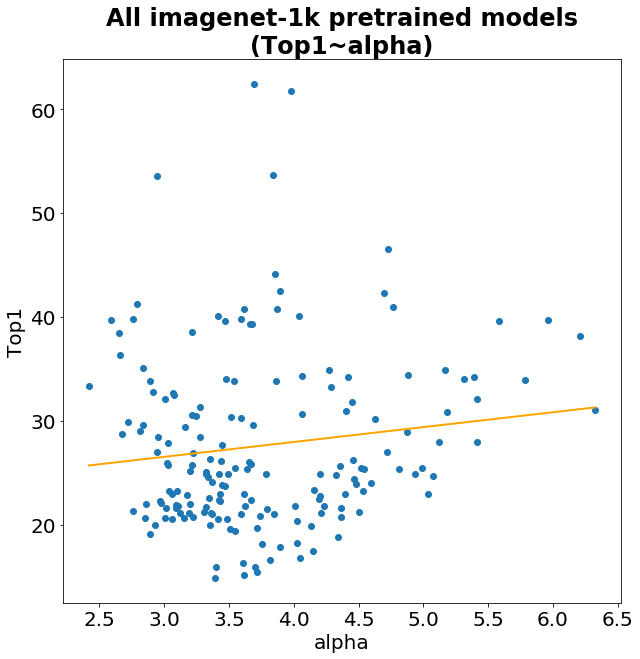

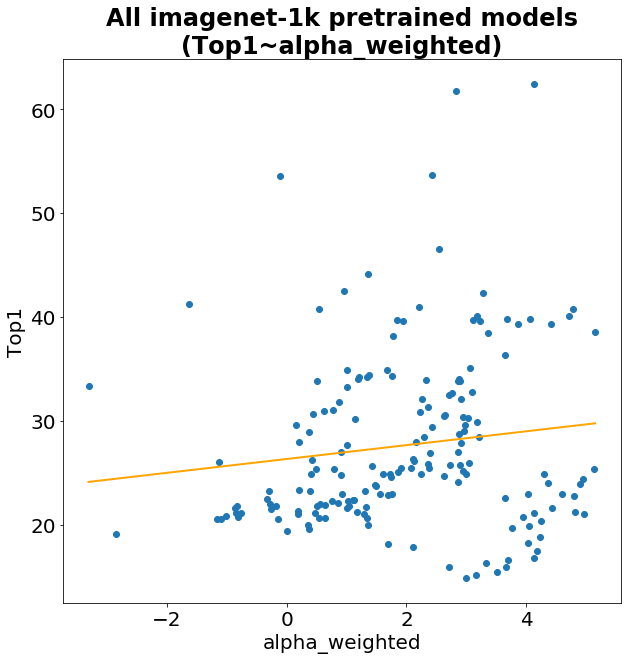

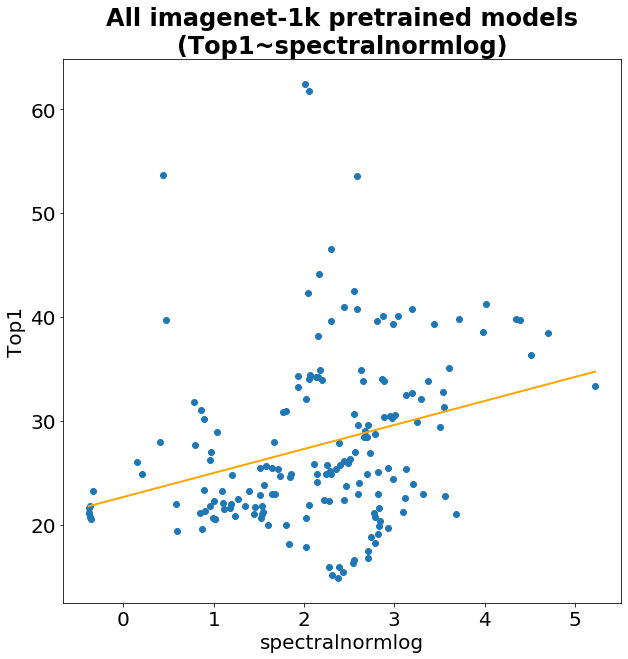

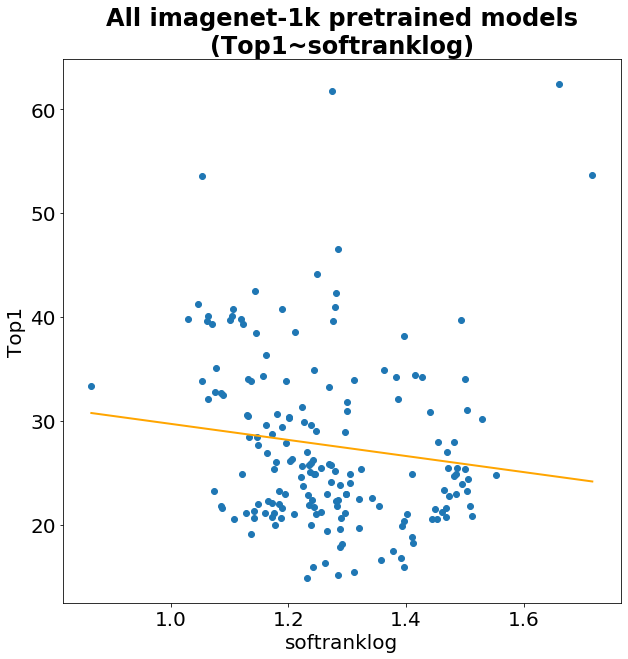

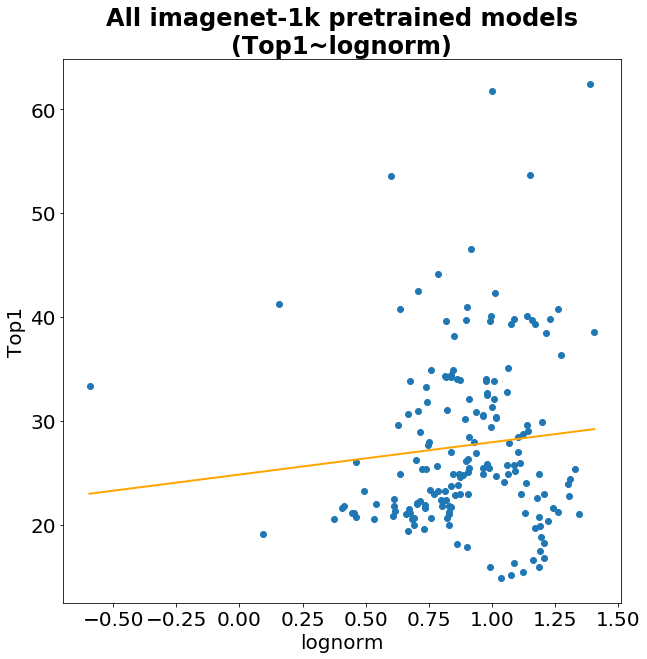

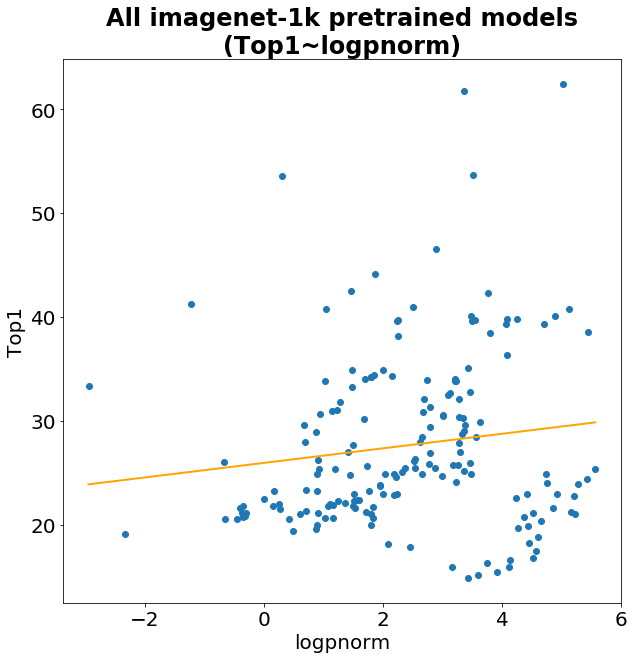

Dataset cifar-10 ['Error, %']  8


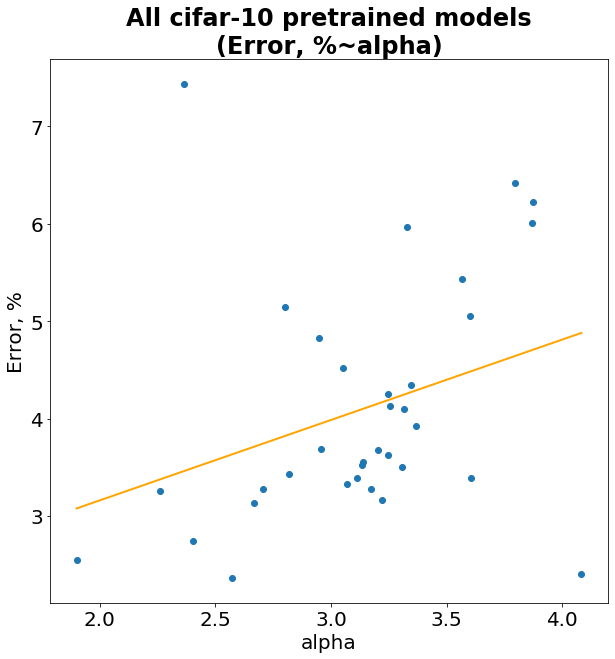

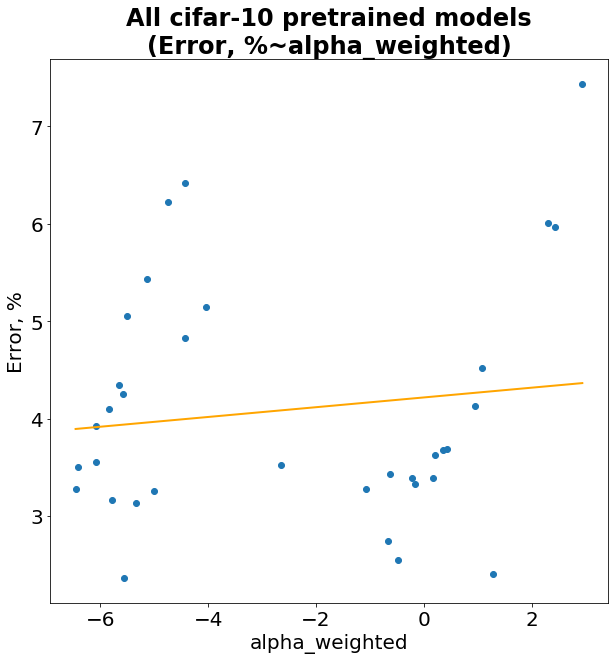

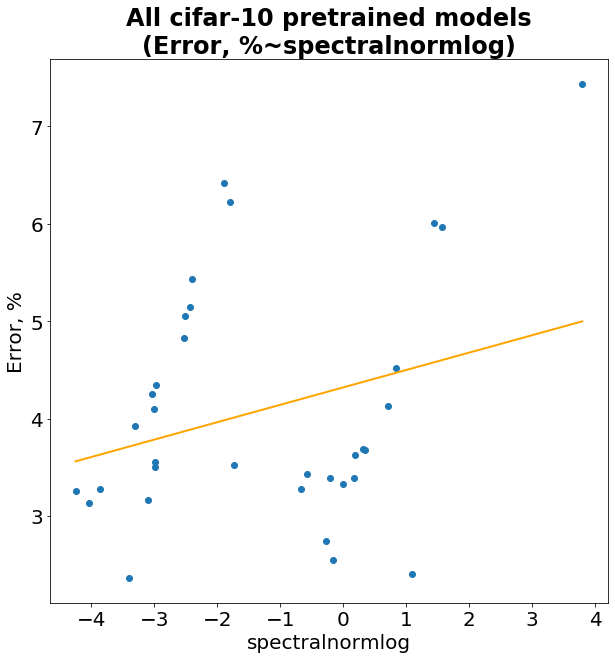

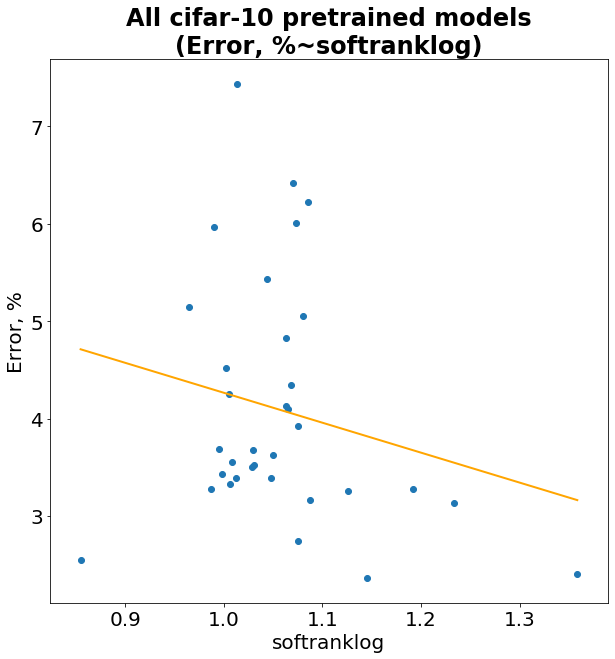

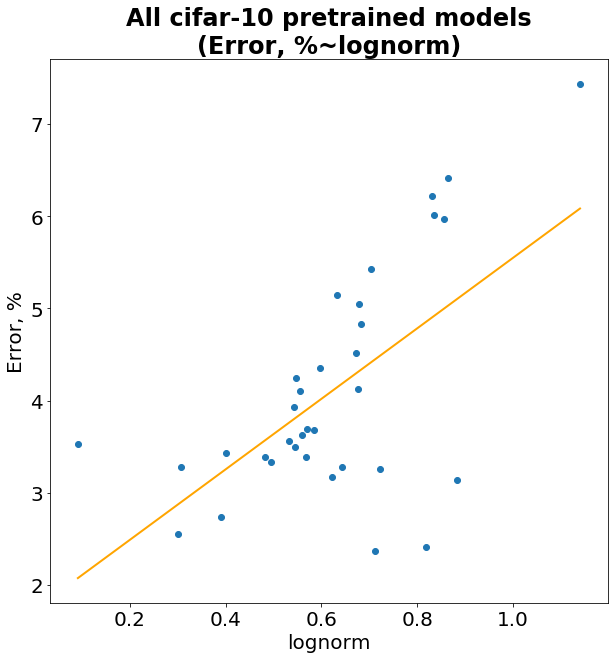

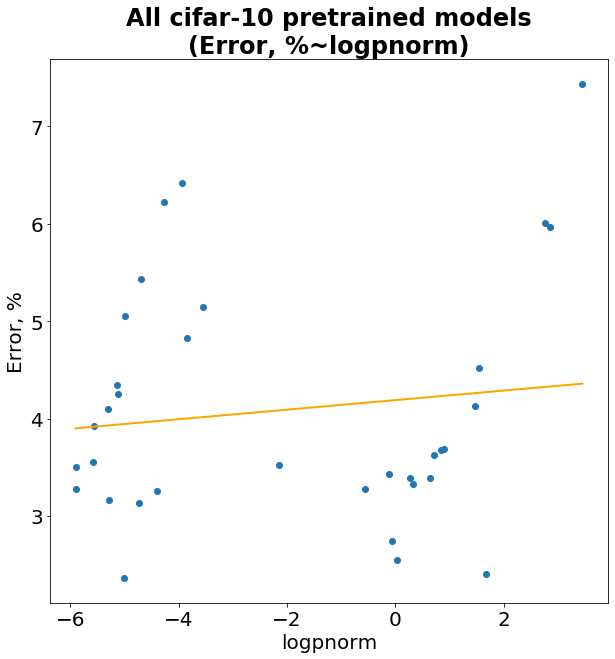

Dataset cifar-100 ['Error, %']  9


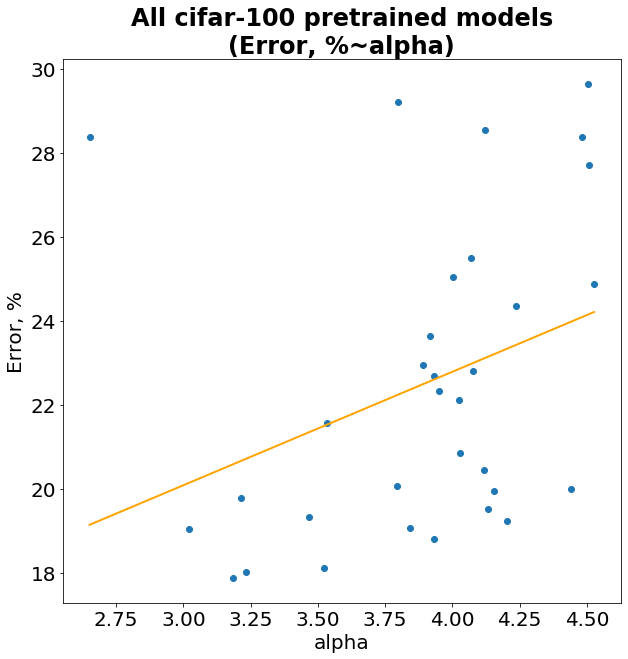

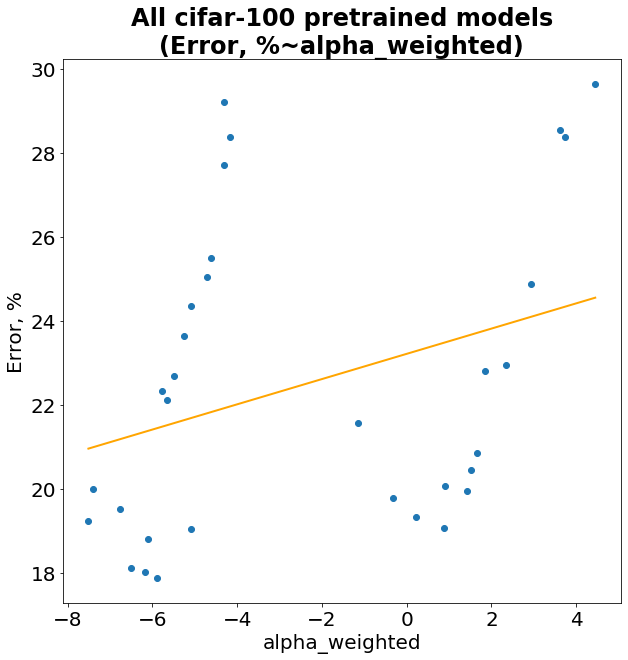

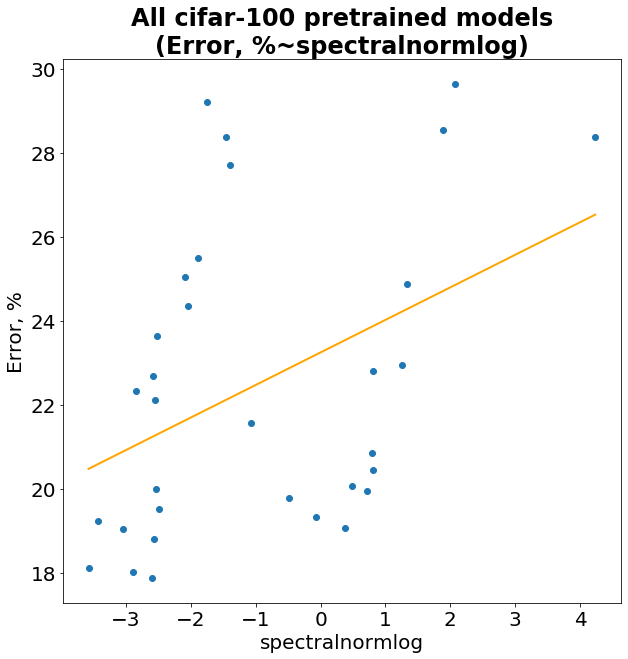

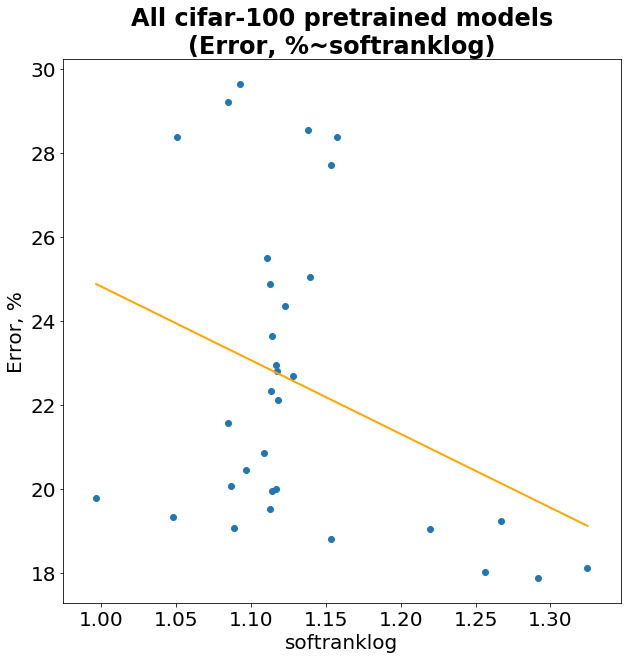

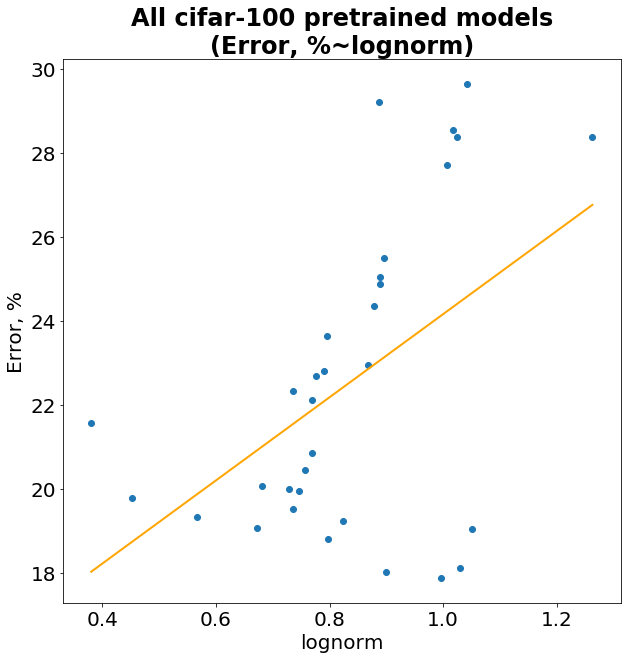

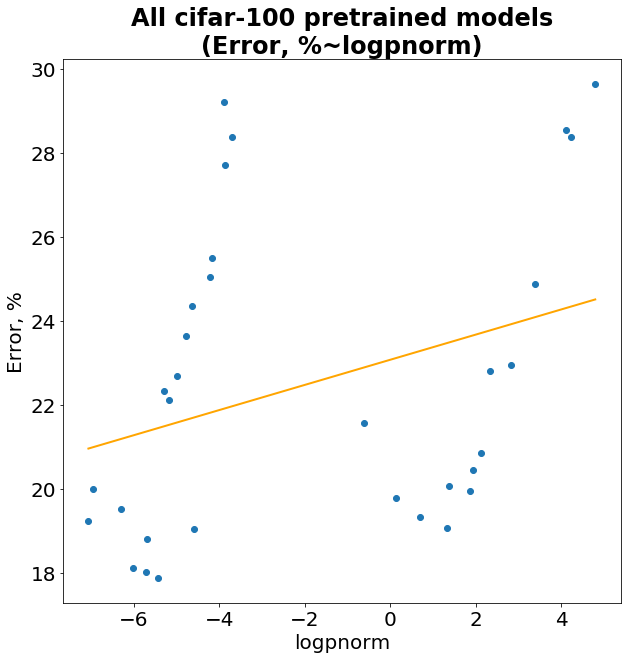

Dataset svhn ['Error, %']  4


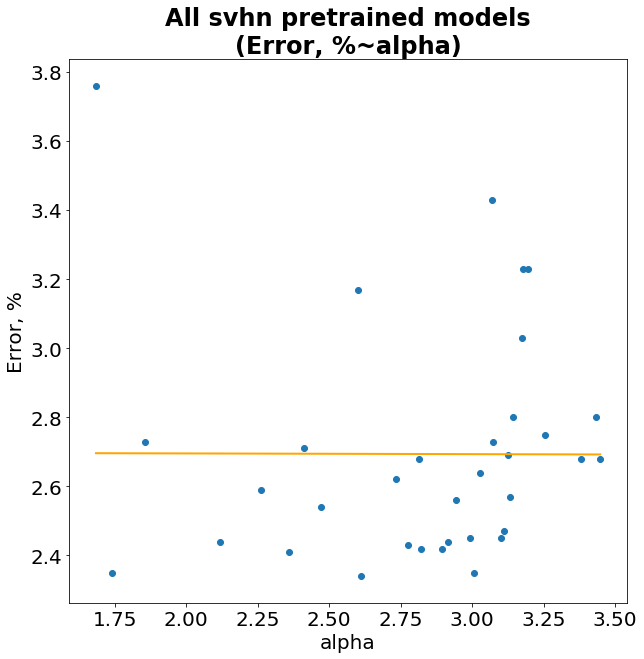

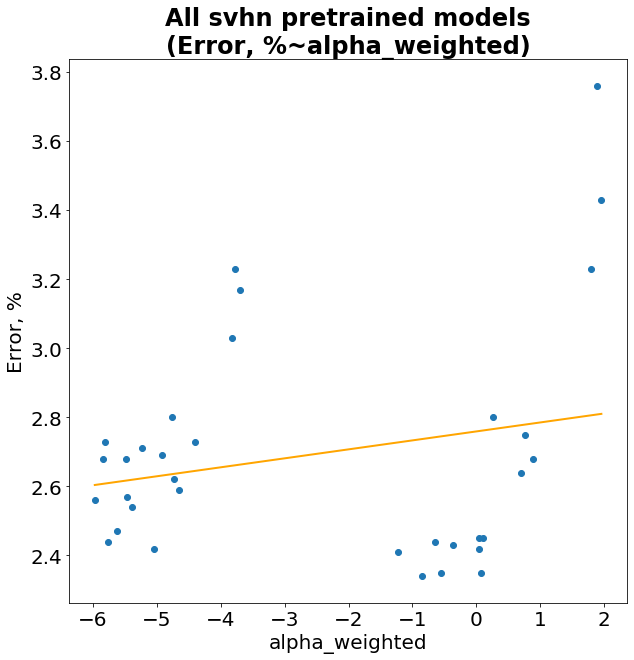

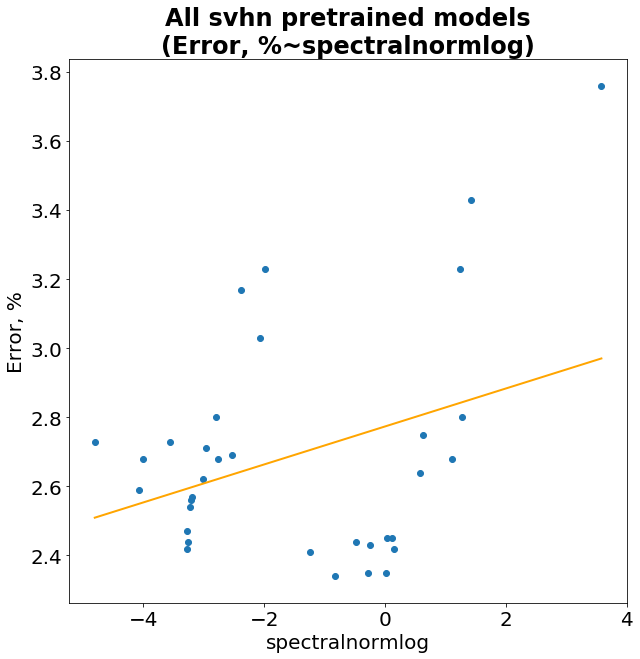

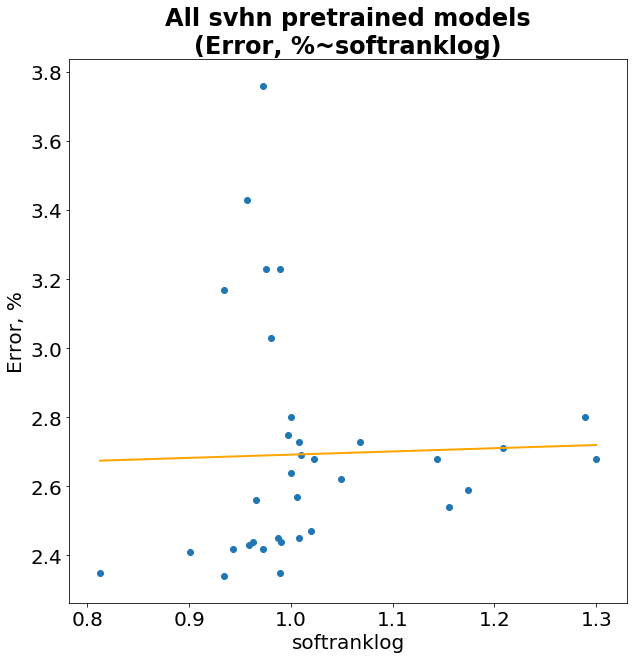

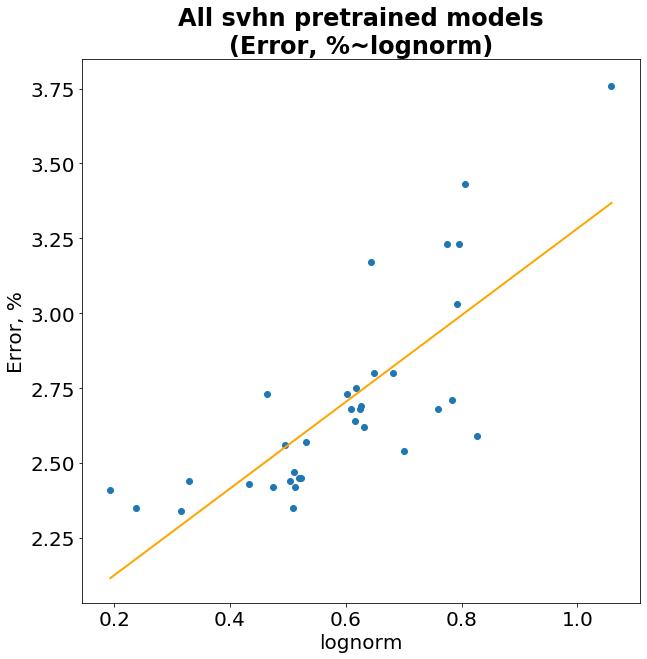

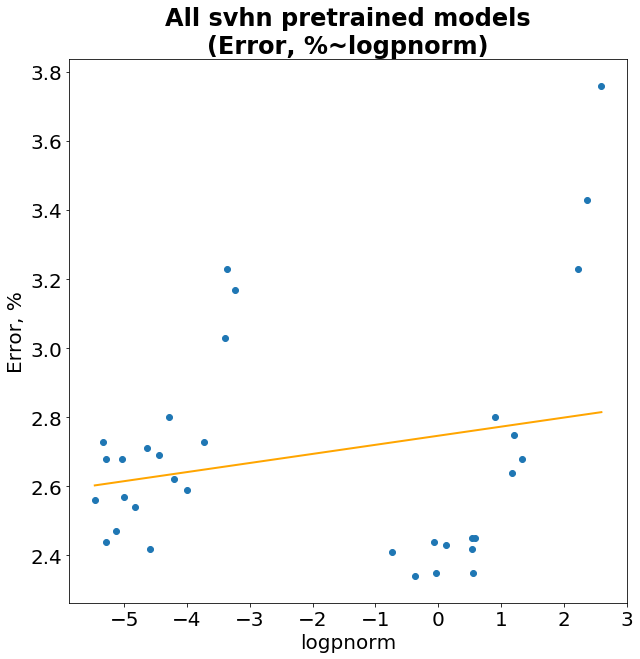

Dataset cub-200-2011 ['Error, %']  12


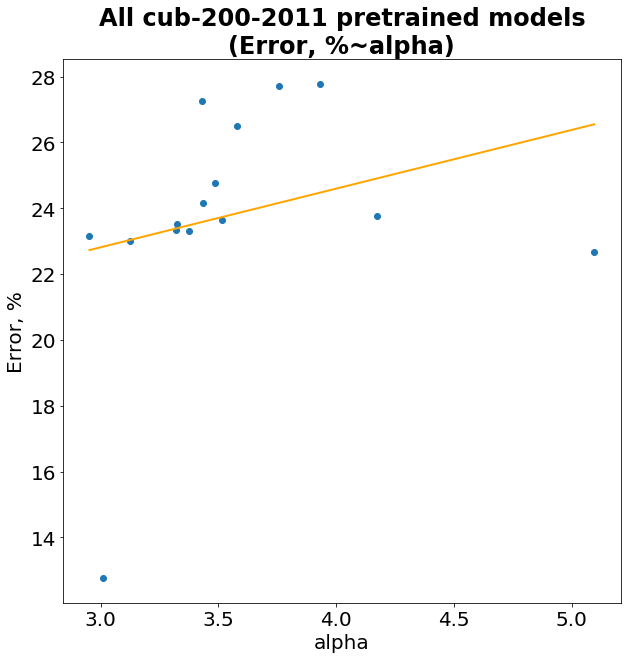

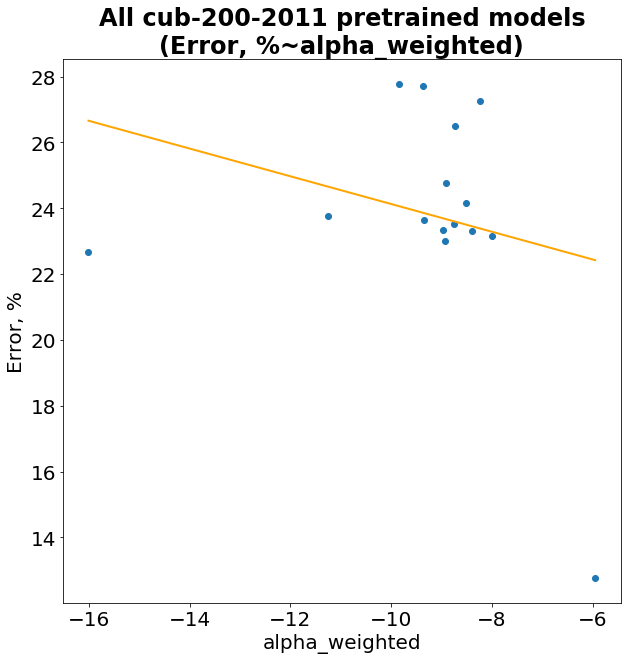

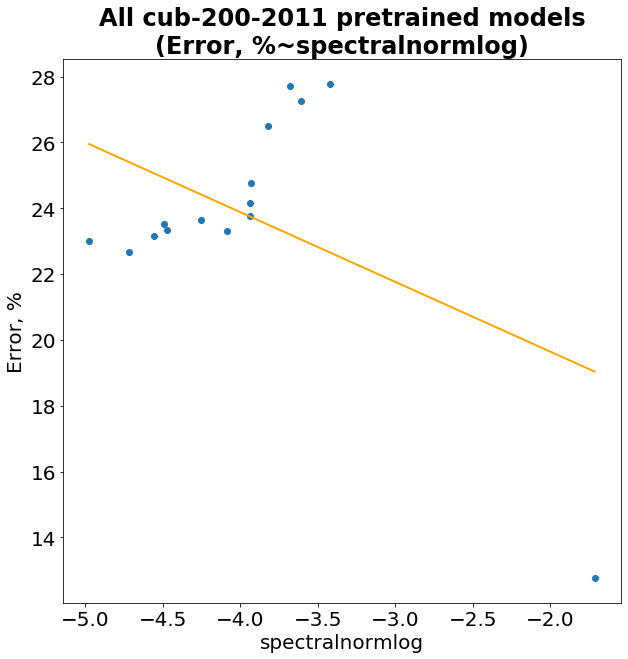

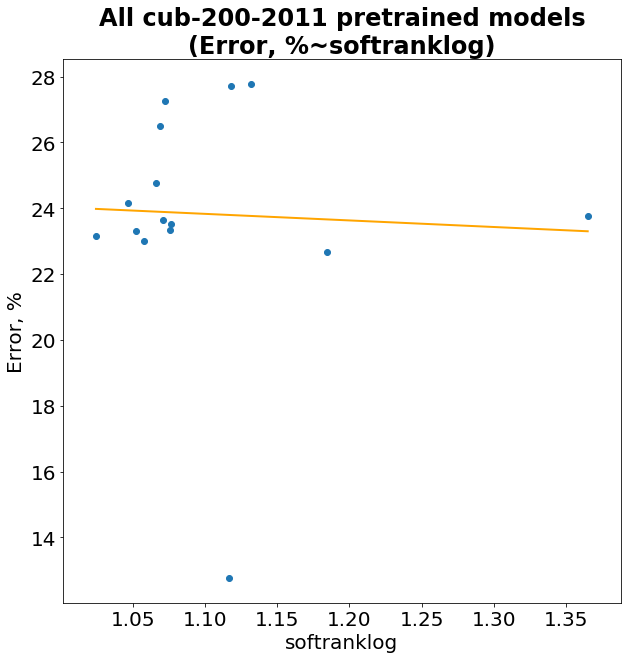

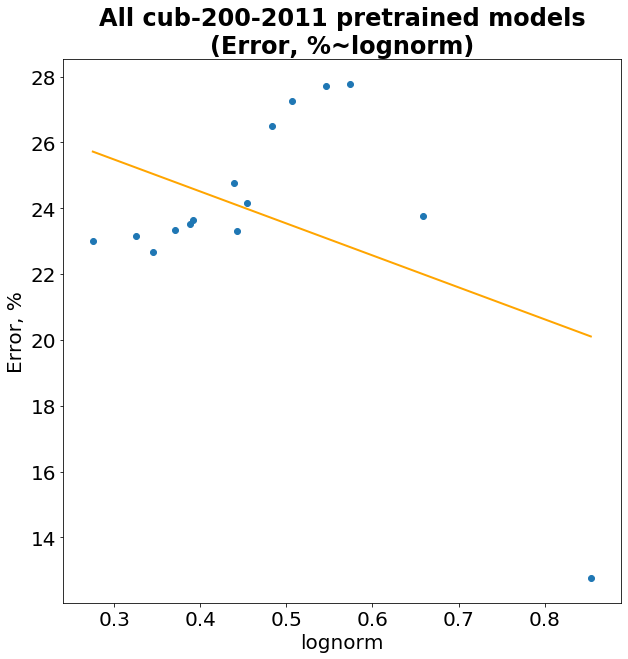

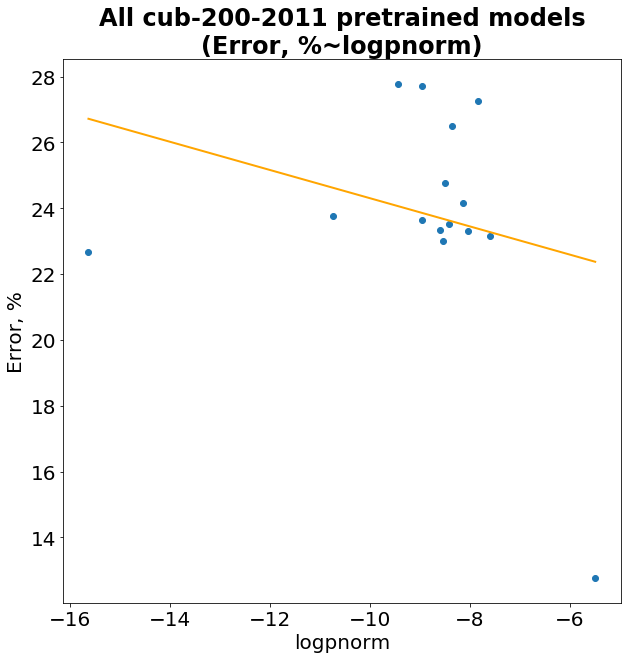

Dataset pascal-voc20102 ['Pix.Acc.,%', 'mIoU,%']  15


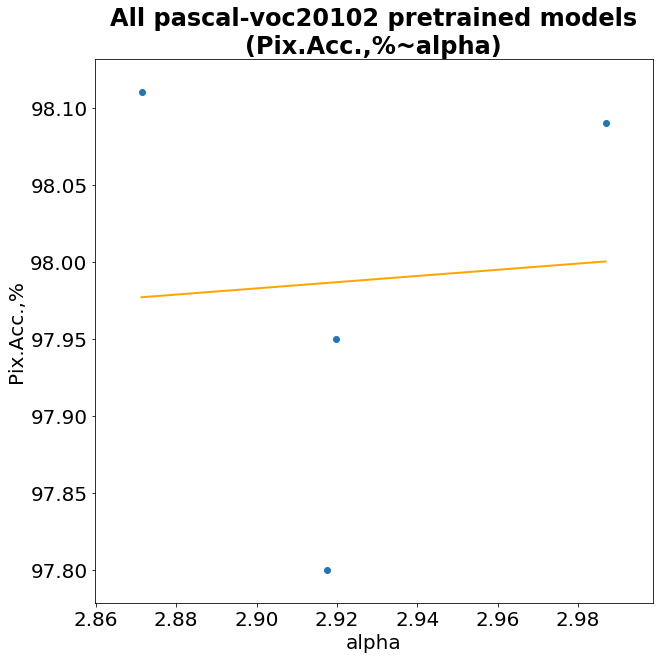

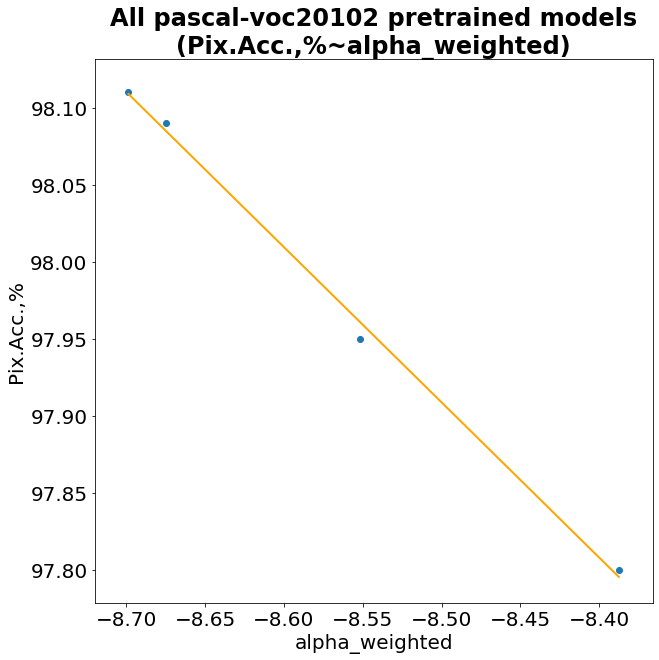

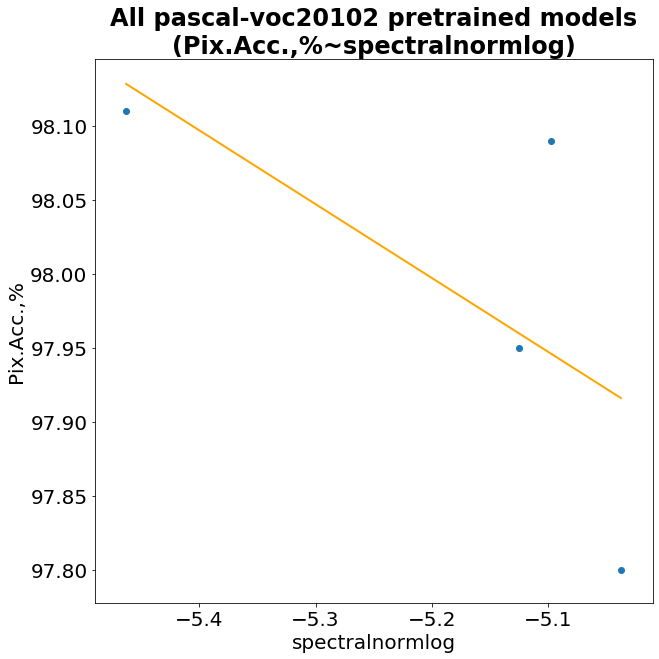

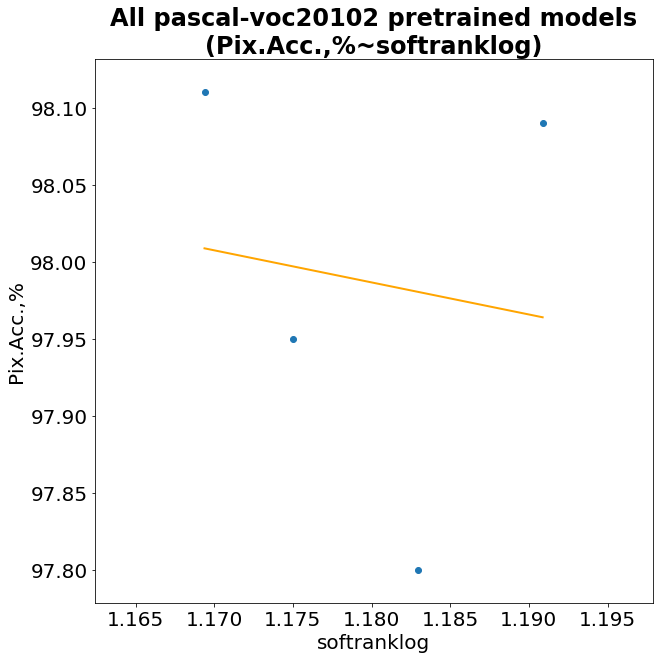

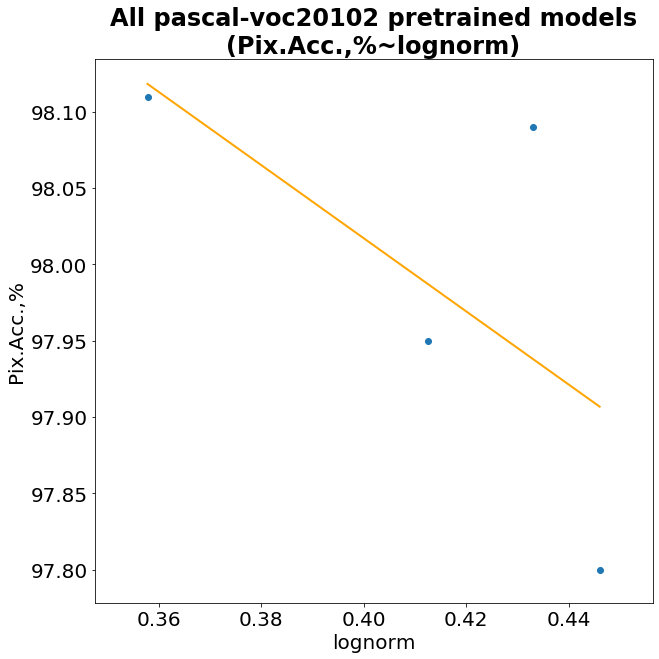

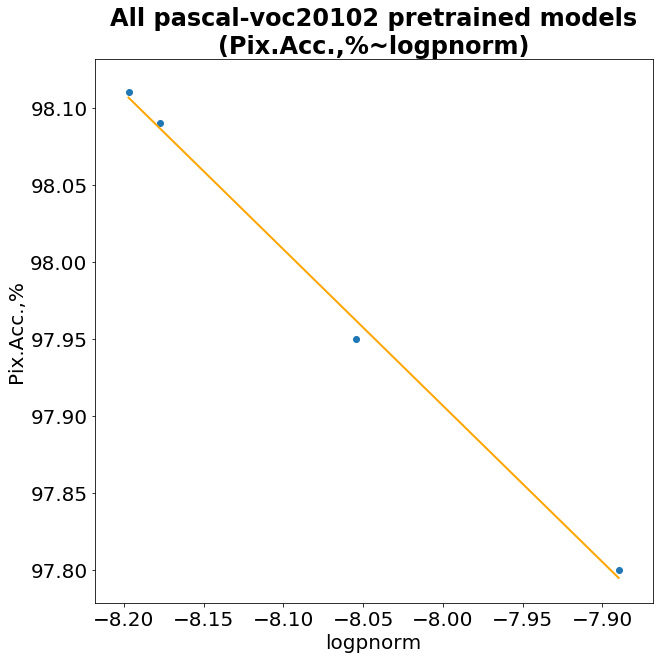

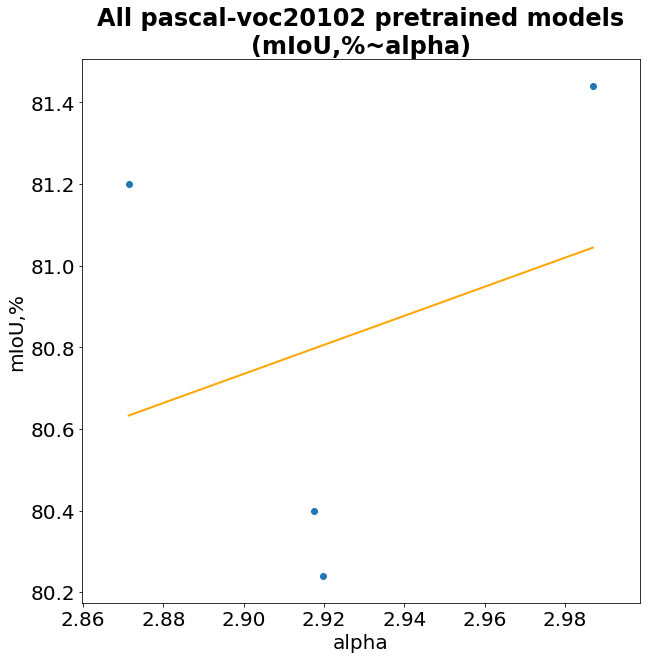

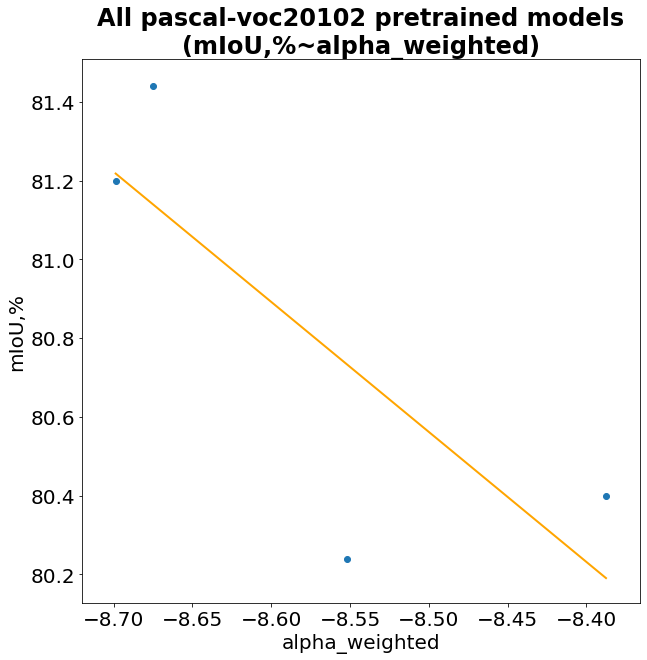

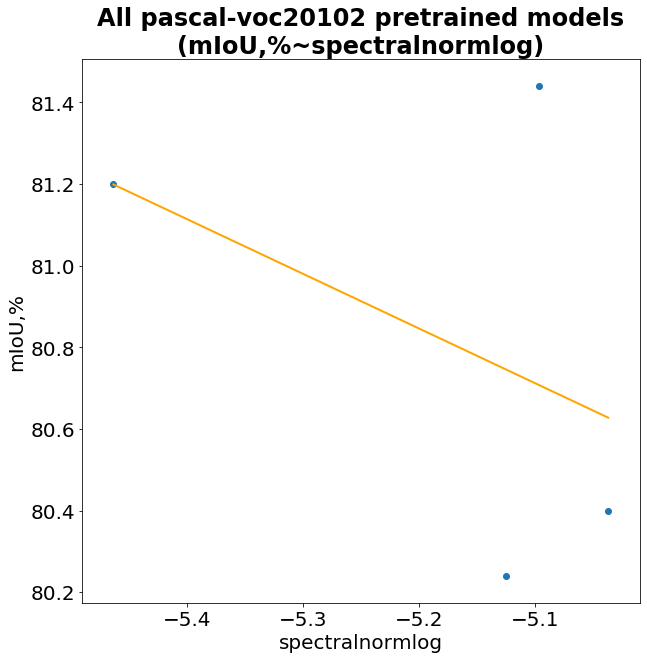

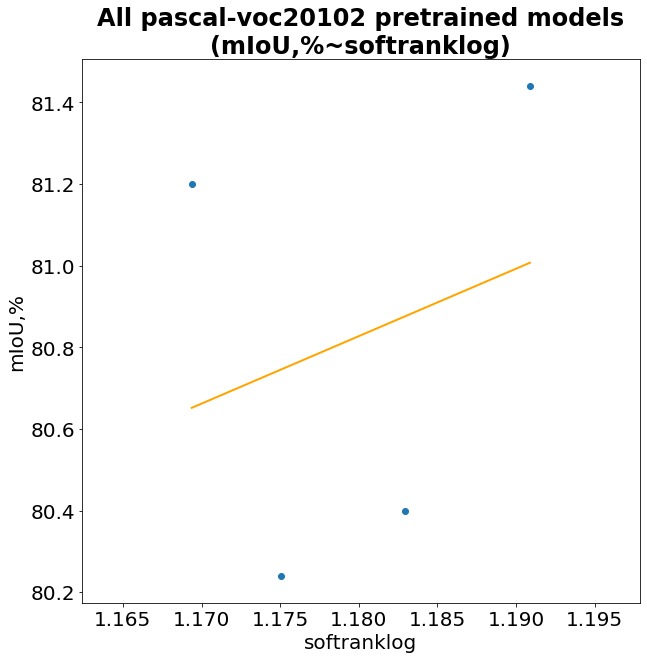

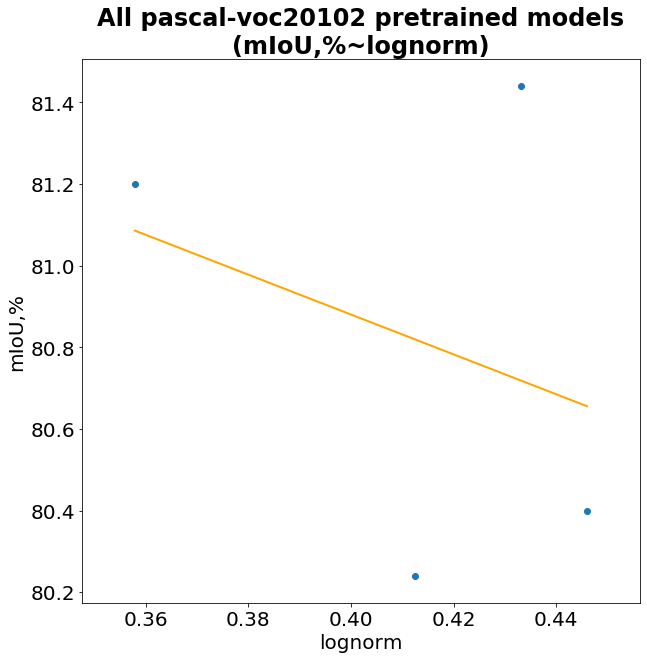

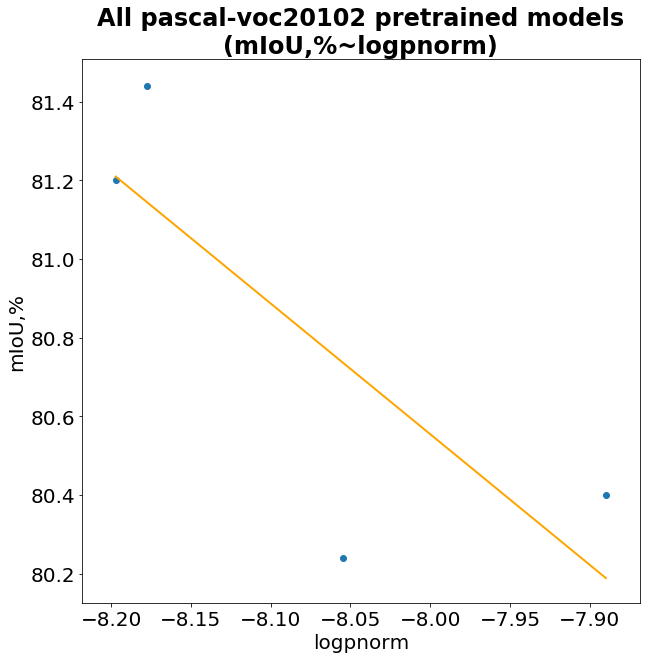

Dataset ade20k ['Pix.Acc.,%', 'mIoU,%']  6


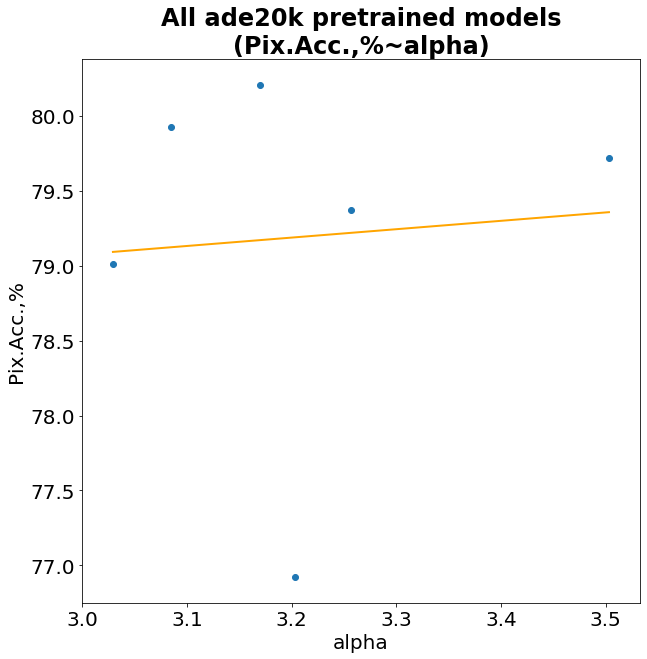

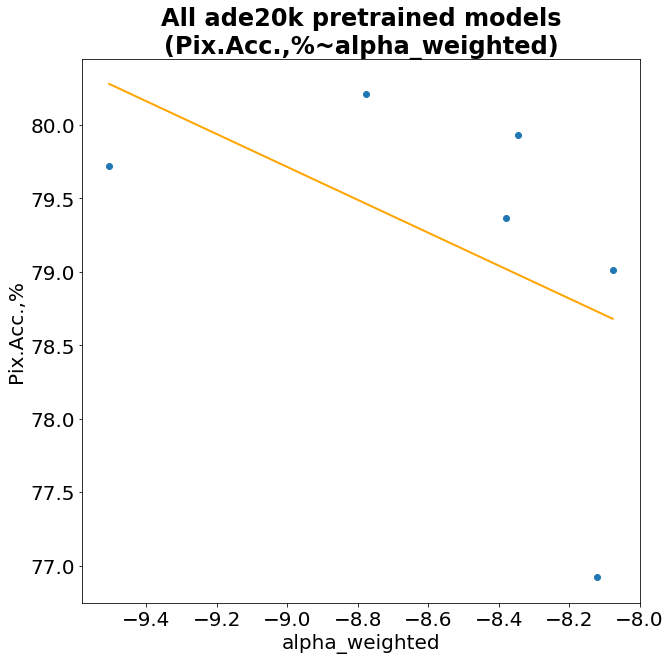

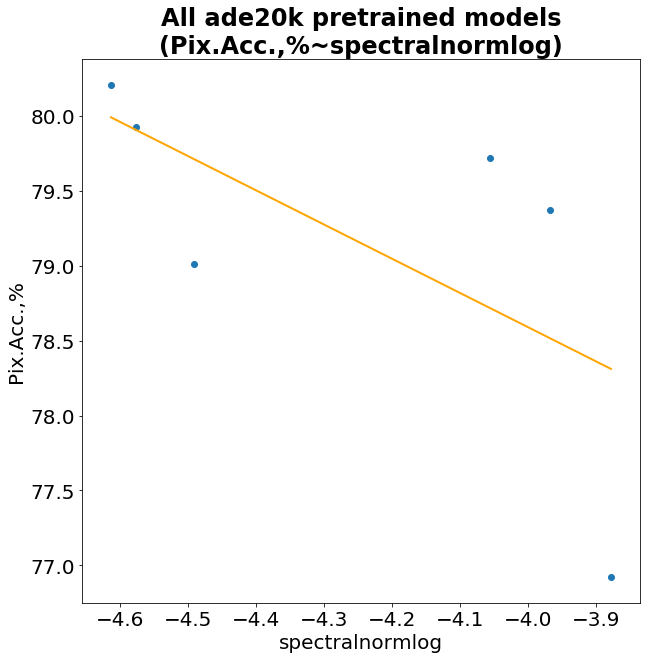

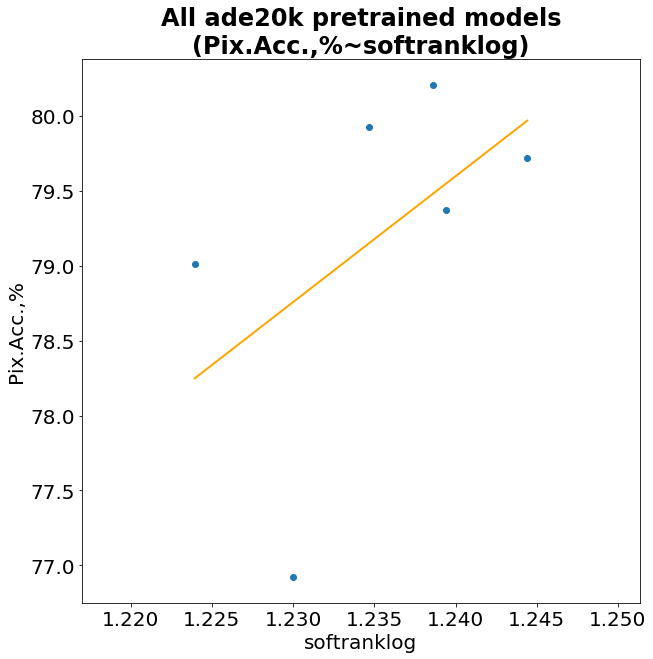

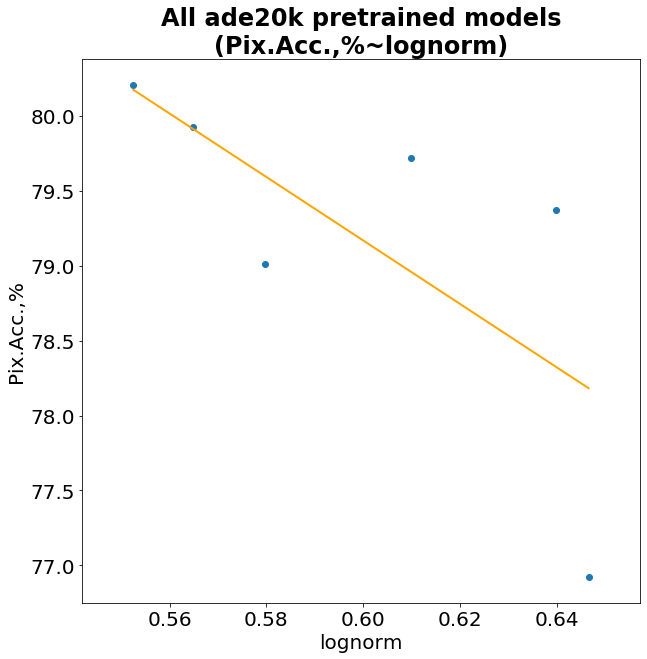

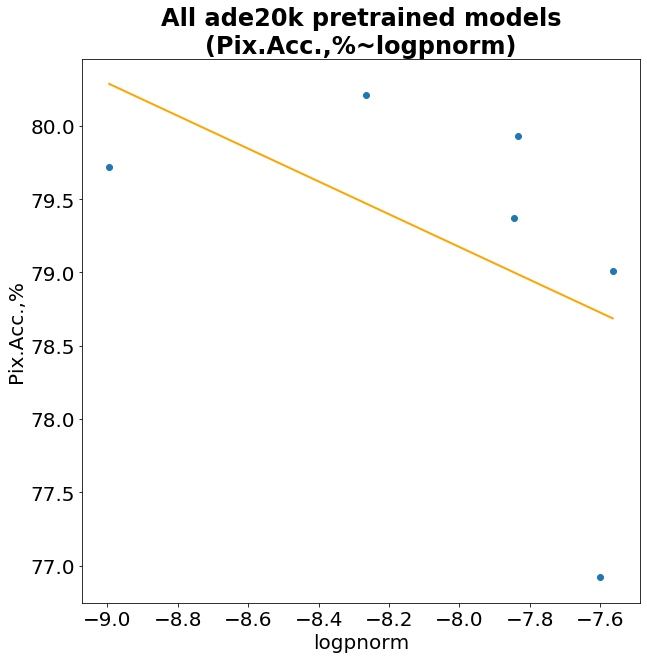

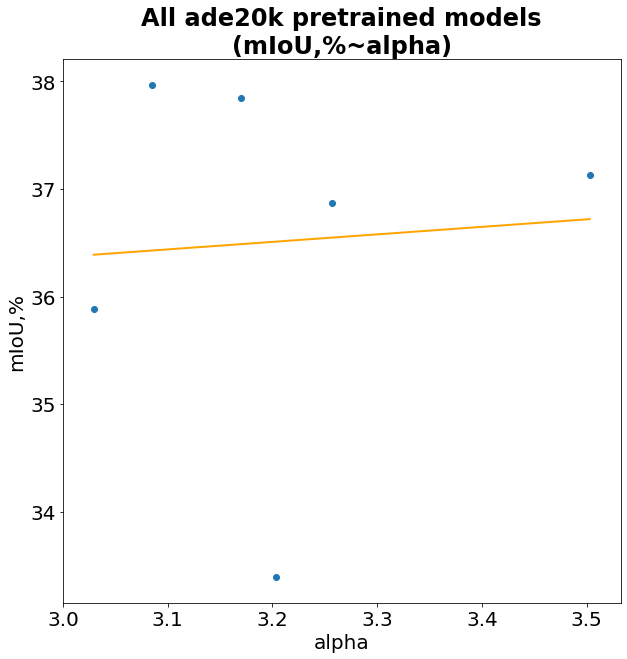

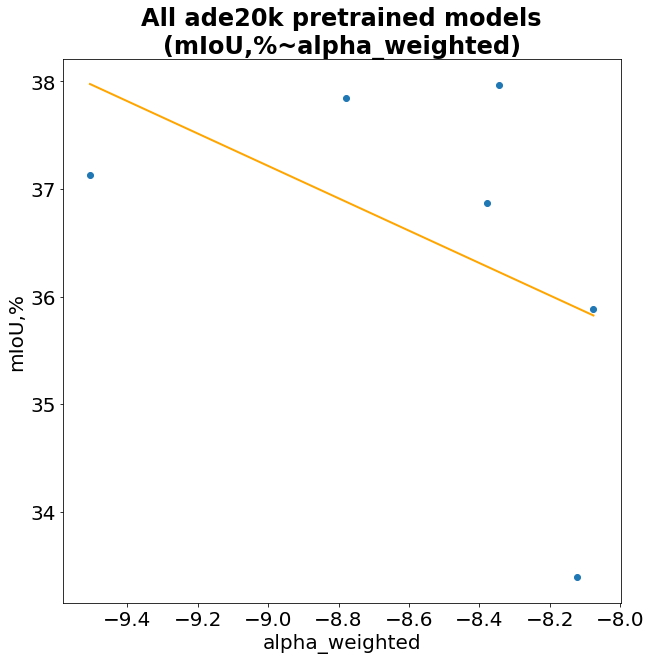

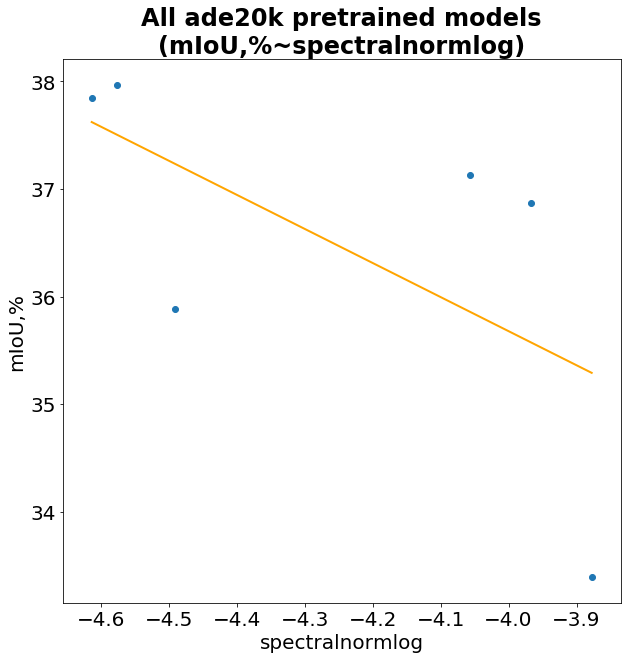

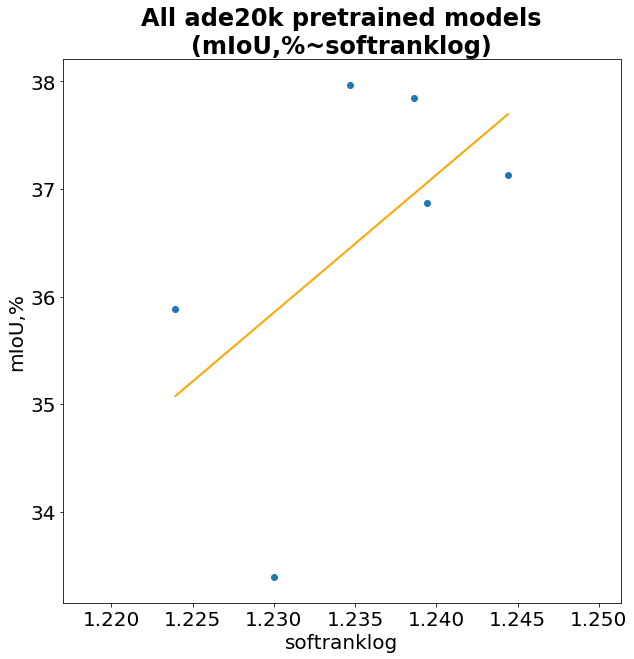

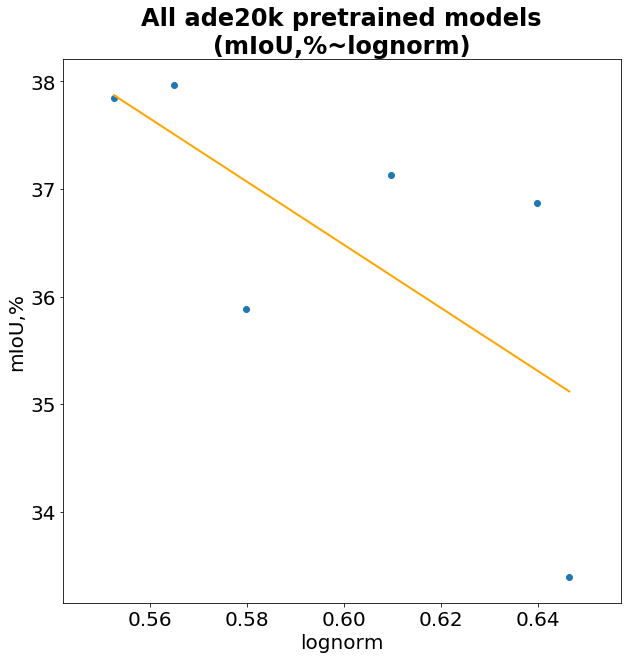

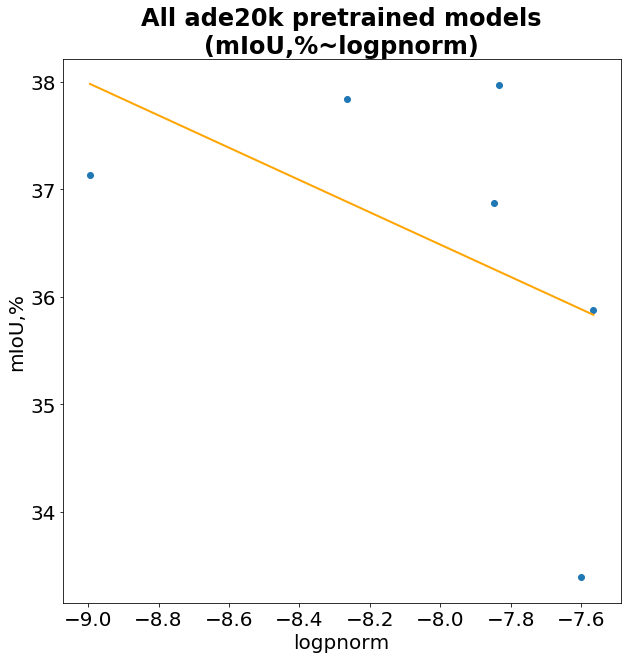

Dataset cityscapes ['Pix.Acc.,%', 'mIoU,%']  10


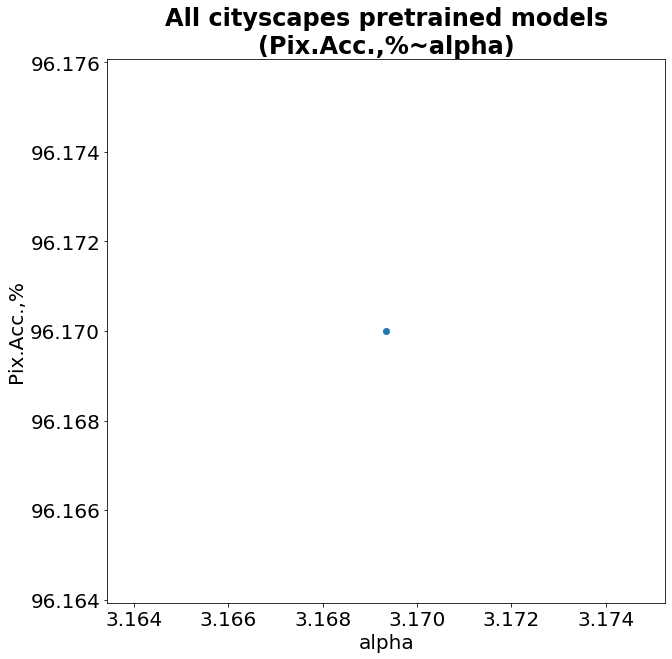

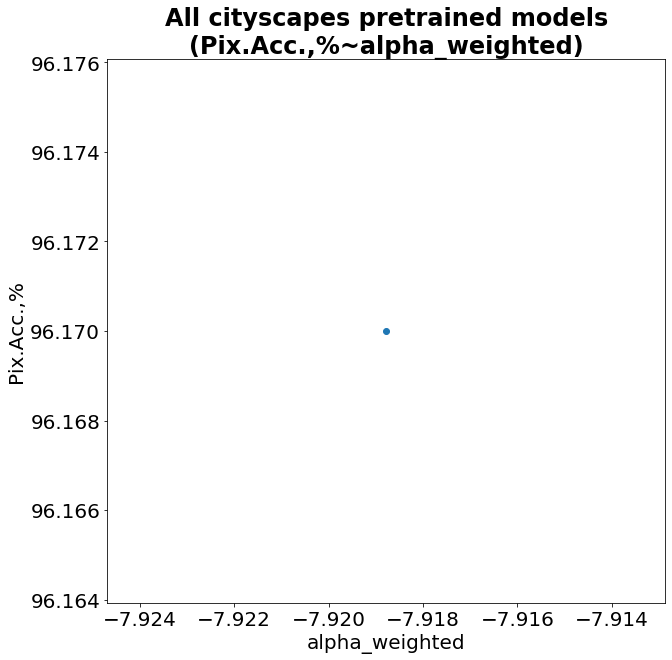

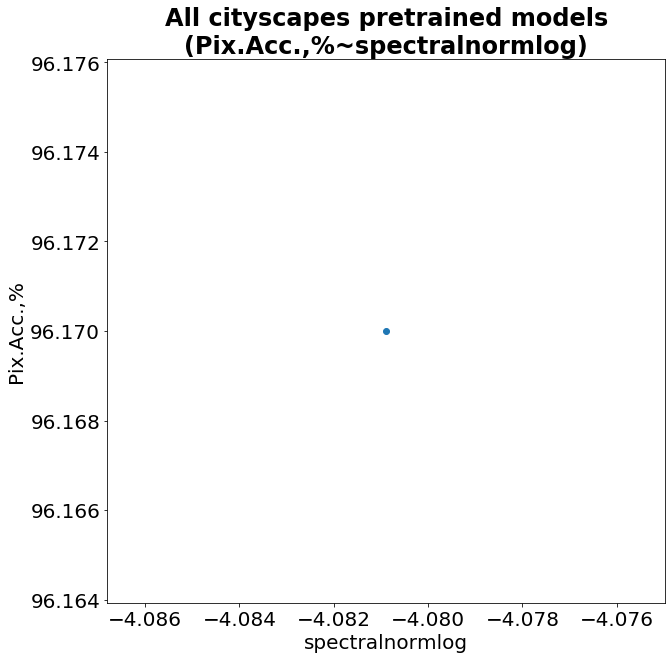

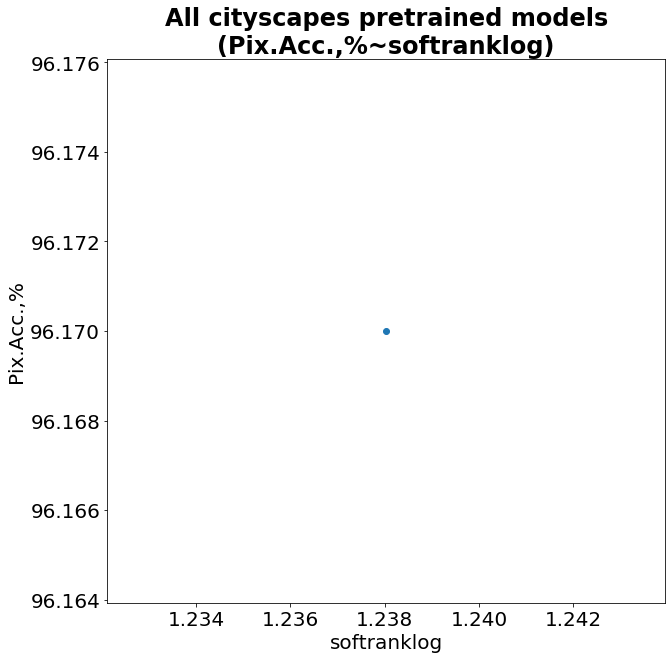

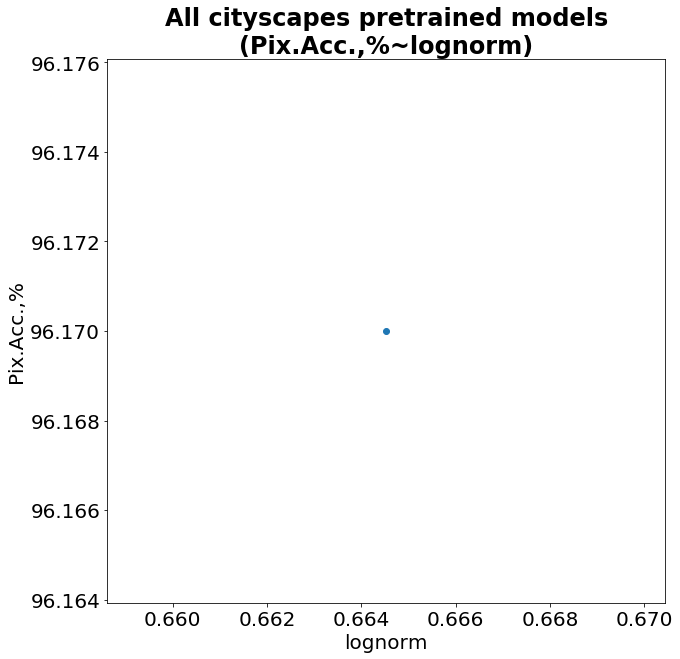

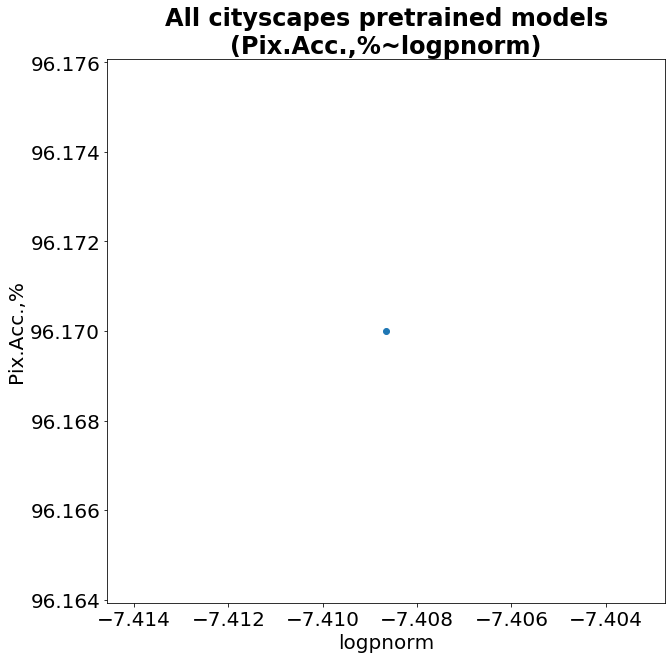

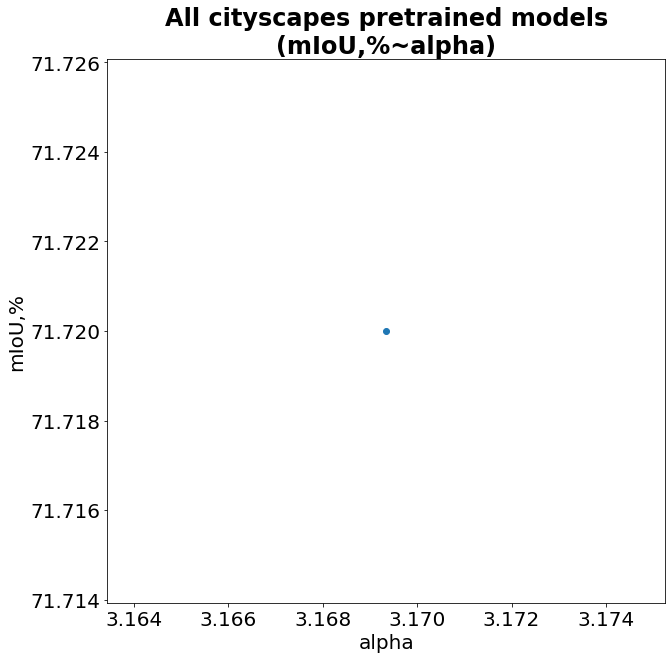

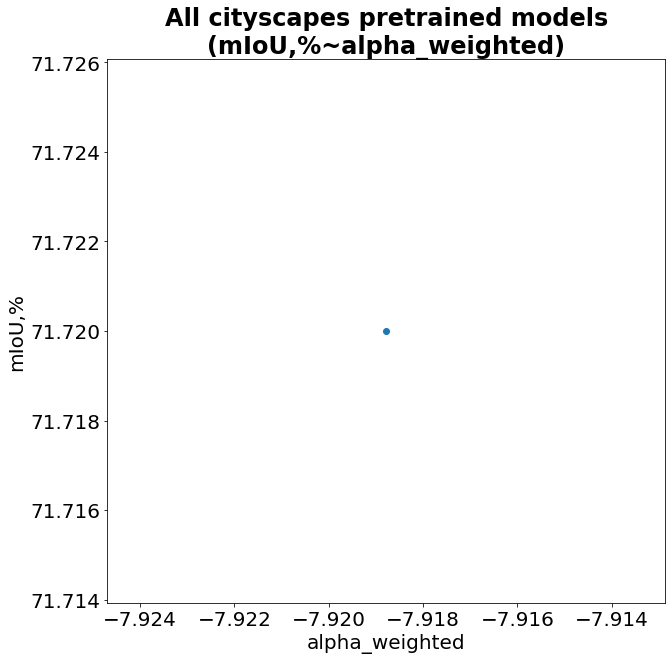

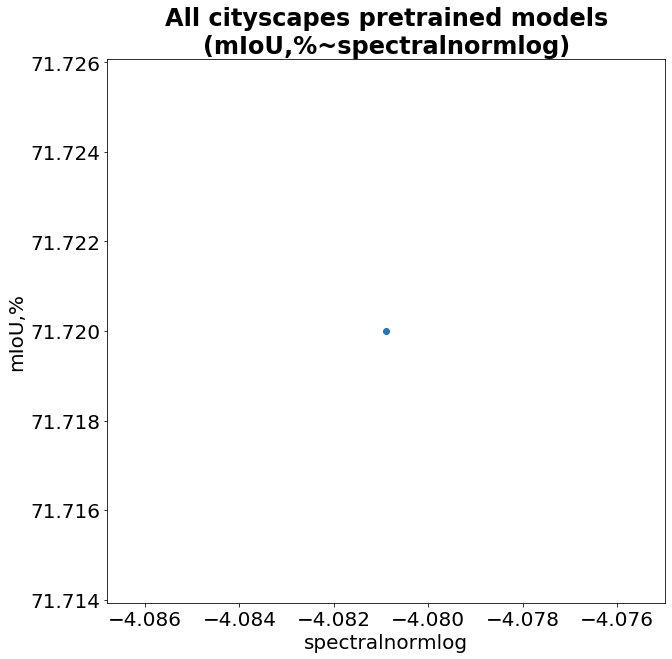

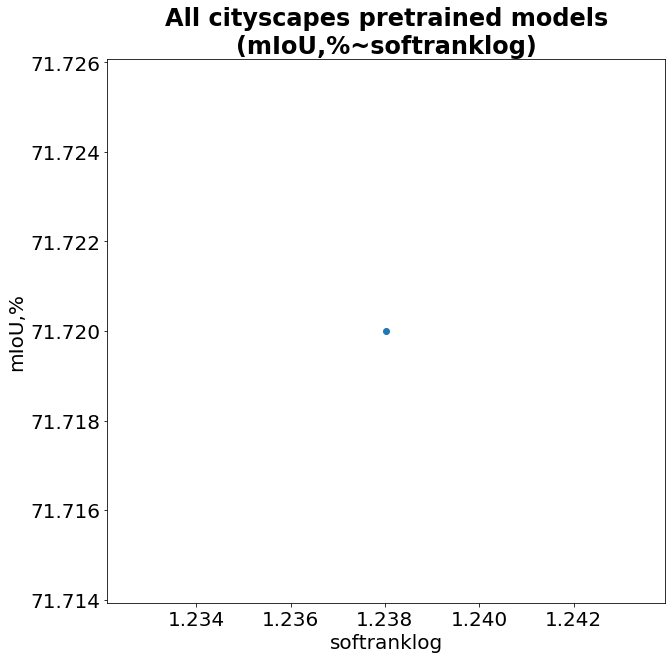

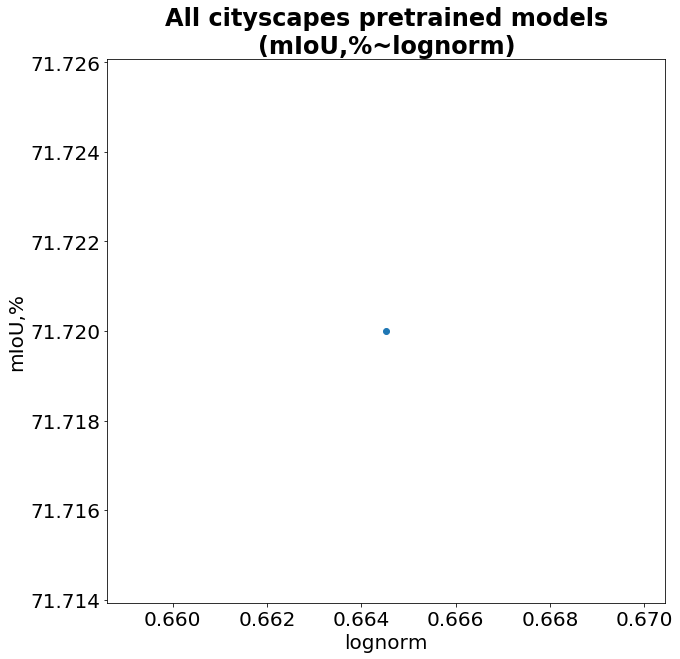

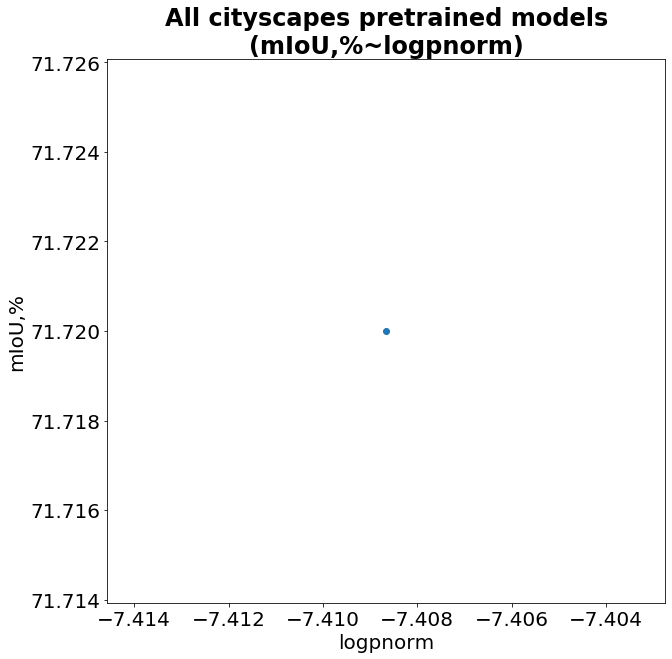

Dataset coco-semantic-segmentation ['Pix.Acc.,%', 'mIoU,%']  26


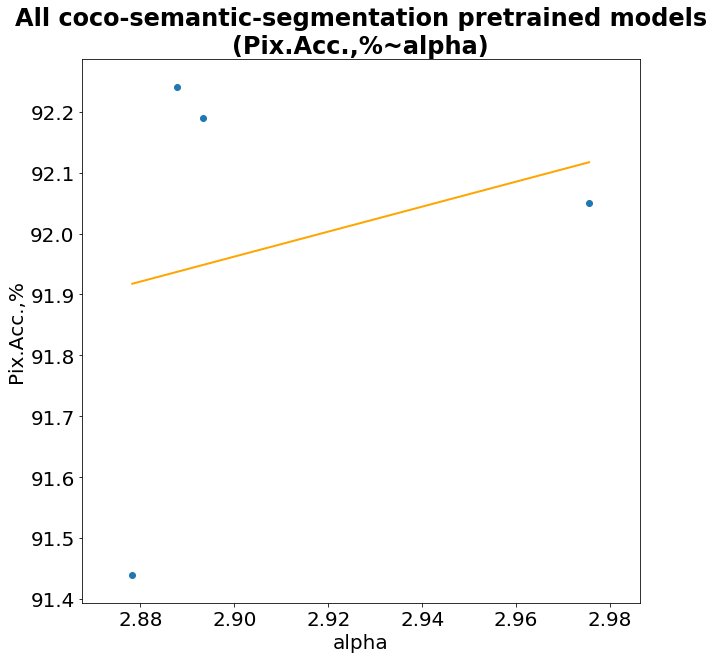

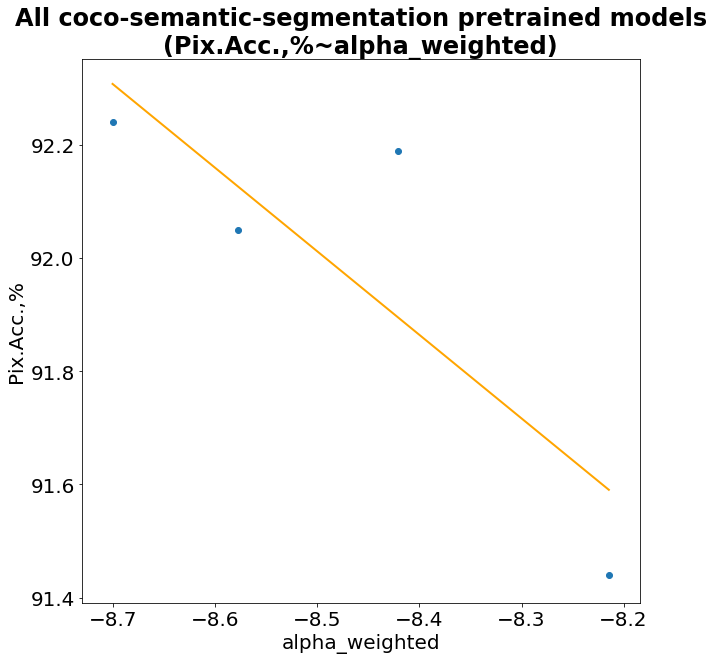

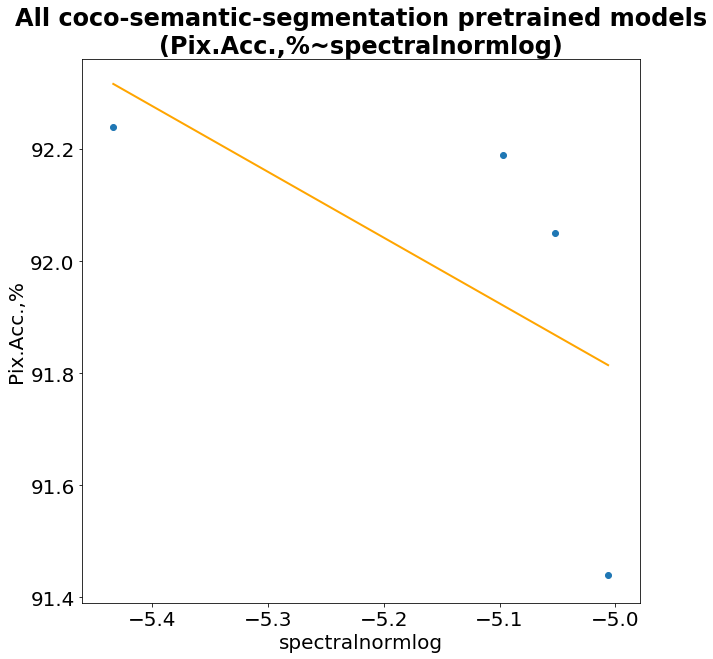

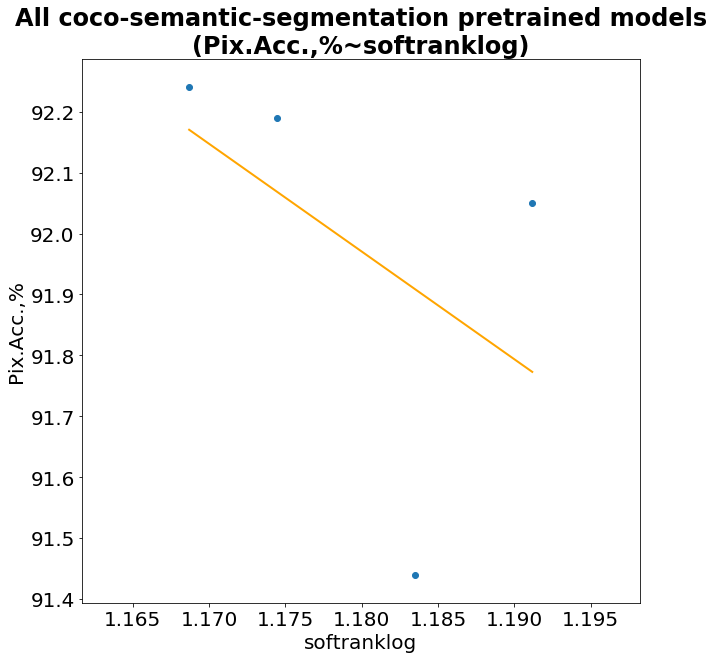

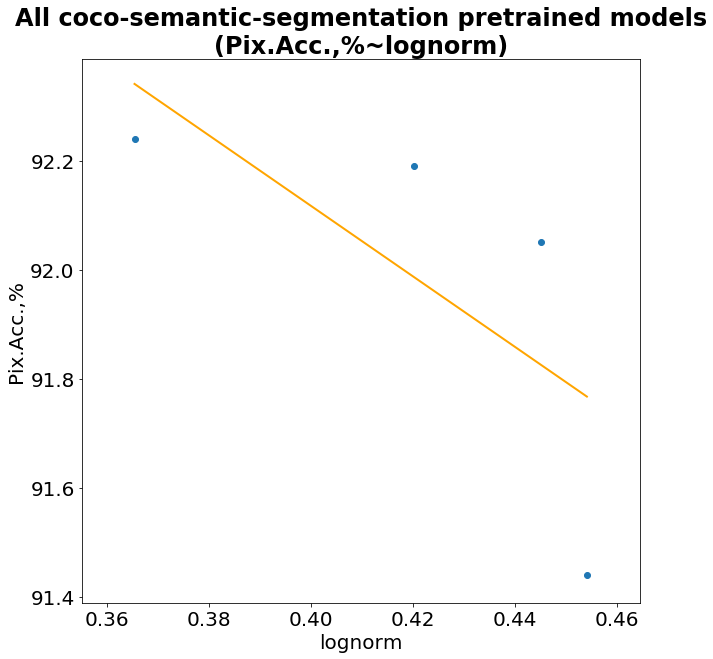

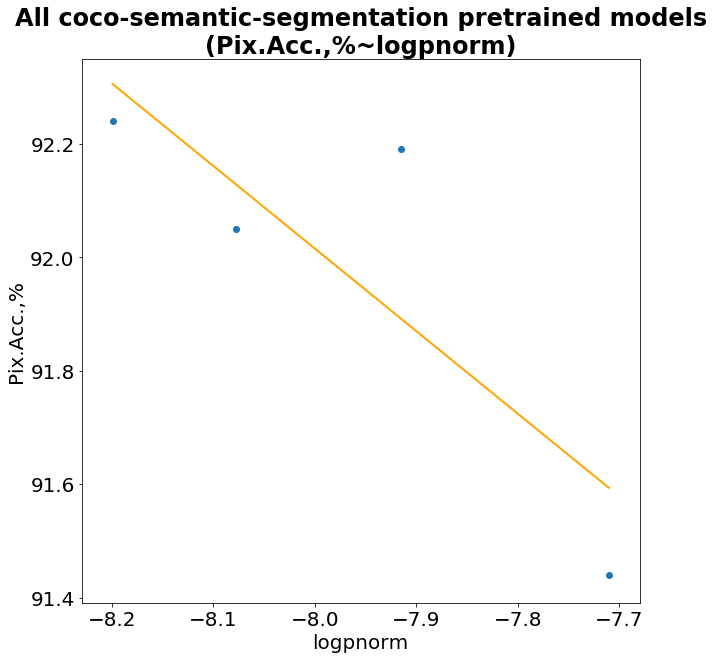

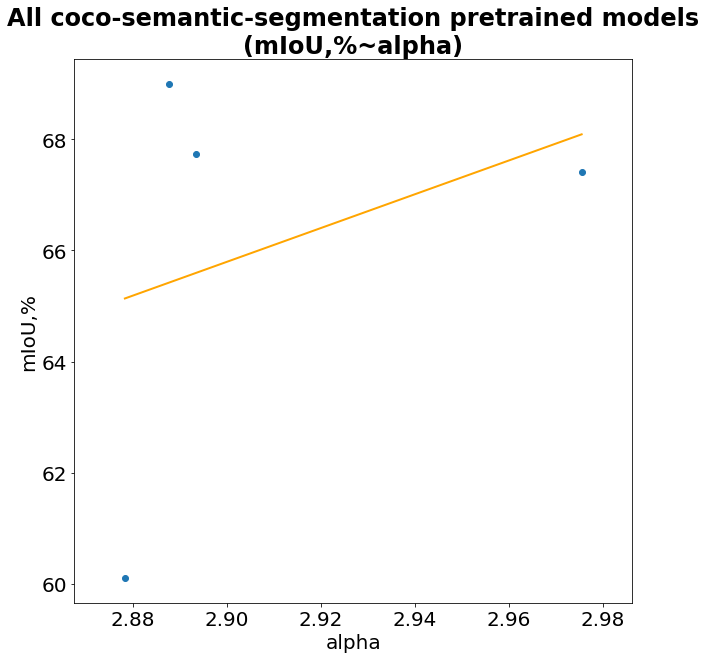

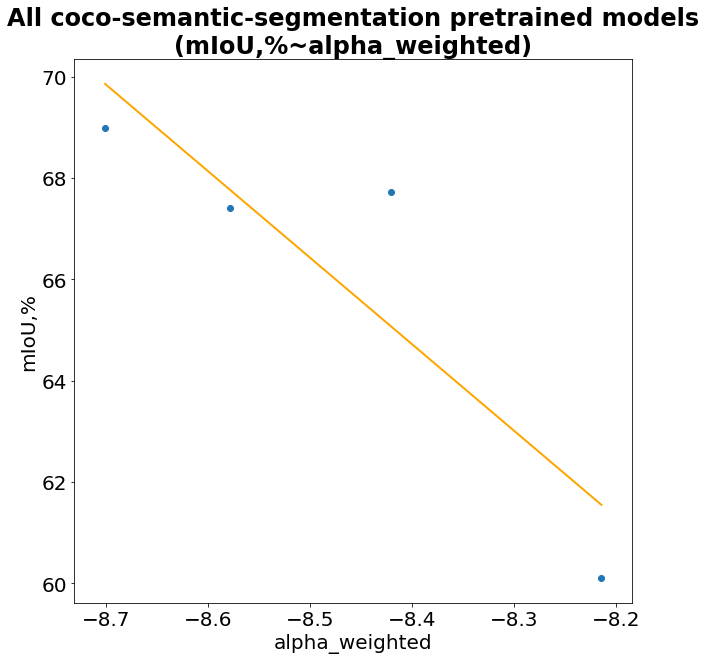

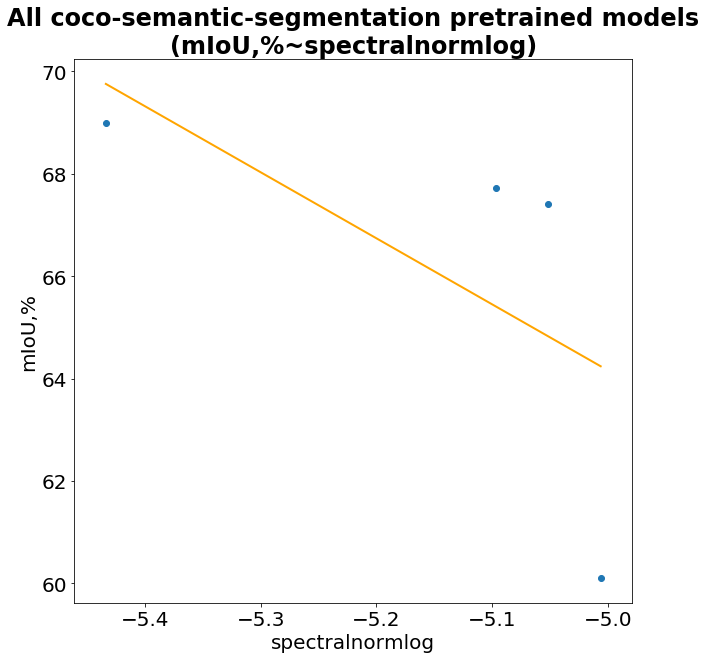

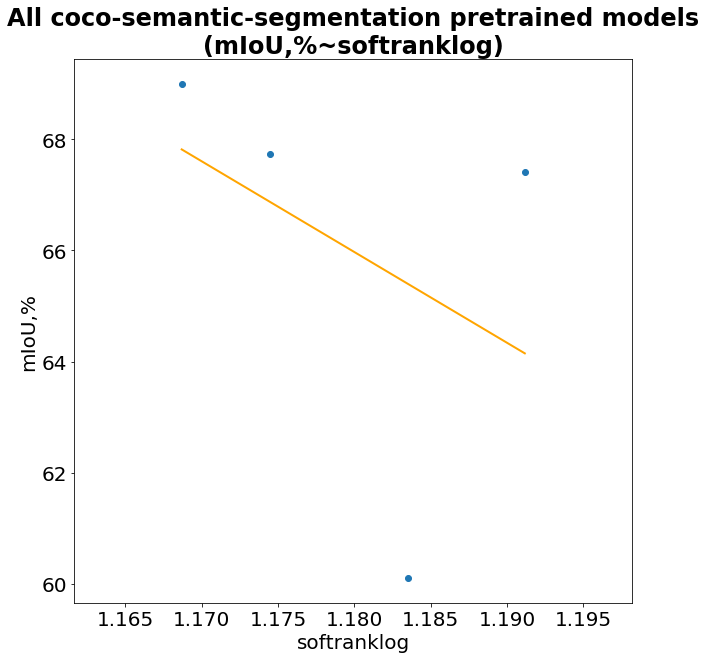

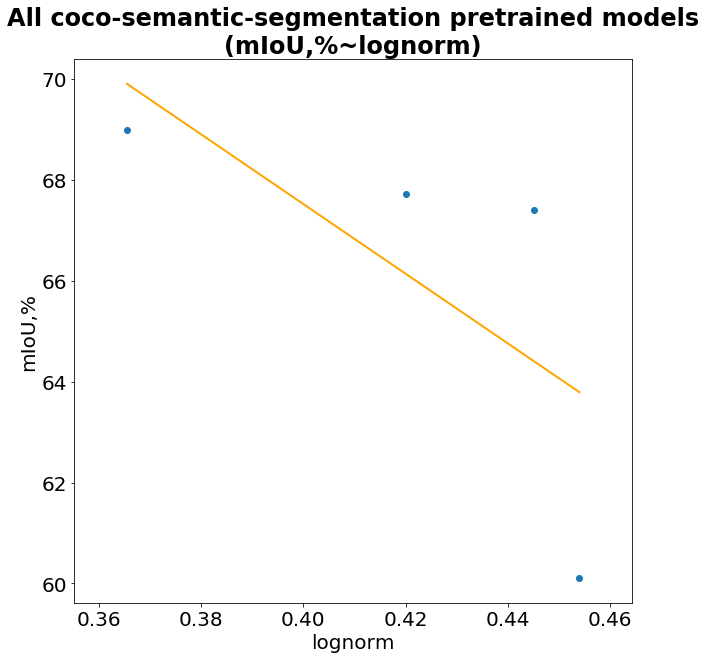

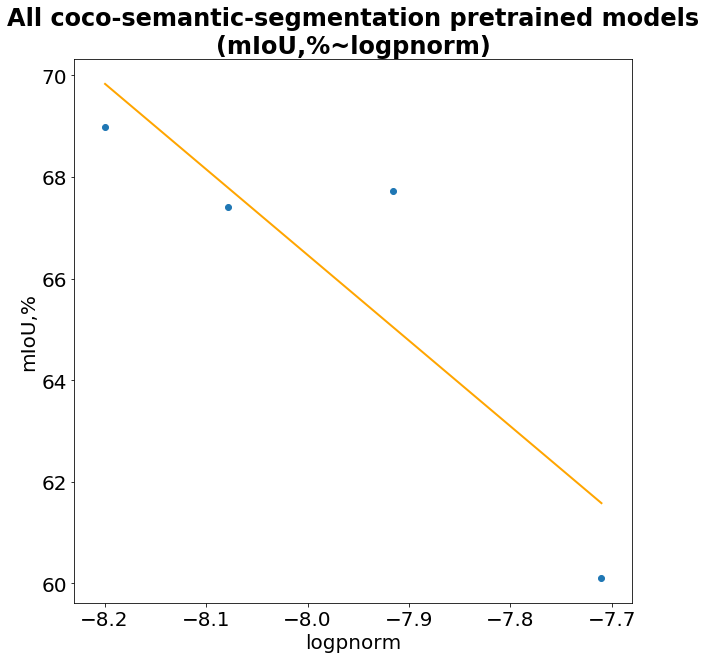

Dataset coco-keypoints-detection []  24


In [19]:
plot_fit = True
plt.figure(figsize = (10,10))

    
'''Plotting by datasets'''
df_fit0 = []

for d in datasets:
    temp = df_full[d].copy()
    if len(temp) == 1:
        continue

    tacc = [c for c in metrics_acc if c in temp.columns]
    print("Dataset {} {}  {}".format(d,tacc, len(d)))
          
    try:
        for ac in tacc:
            for x in metrics:
                plt.scatter(temp[x], temp[ac])
                plt.xlabel(x)
                plt.ylabel(ac)
                plt.title('All {} pretrained models\n({}~{})'.format(d, ac, x), 
                        fontweight = 'bold')

                if plot_fit == True:
                    temp = temp.dropna().reset_index(drop = True)
                    this_fit = sm.OLS(temp[ac], sm.add_constant(temp[x].to_numpy())).fit()
                    this_x = np.linspace(min(temp[x]), max(temp[x]), 1000)
                    plt.plot(this_x, this_fit.predict(sm.add_constant(this_x)), linewidth = 2, color = 'orange')
                    df_fit0.append([d, ac, x, this_fit.ssr/len(temp), this_fit.rsquared])
                plt.show()
    except e:
        print(e)
        pass


del temp
del tacc

if df_fit0 != []:
    df_fit0 = pd.DataFrame(df_fit0, columns = ['dataset', 'test accuracy', 'x variable', 'MSE', 'r^2'])

##  Fit a linear regression for each Architecture Series, Dataset


1. Plots
2. df_fit (next cell): records the X, Y, degree, SSE and MSE for the fit'''


- Compute  RMSE, R2, and Kendal-Tau statisitics


In [20]:
datasets

['imagenet-1k',
 'cifar-10',
 'cifar-100',
 'svhn',
 'cub-200-2011',
 'pascal-voc20102',
 'ade20k',
 'cityscapes',
 'coco-semantic-segmentation',
 'celebamask-hq',
 'coco-keypoints-detection']

### We have a lot more models than we started with, but we don't use them all here

In [21]:
valid_datasets = {}
min_num_models = 4
for d in datasets:
    df = df_full[d].copy()
    df.dropna(inplace=True)

    model_counts = df['group'].value_counts().to_frame()
    model_counts = model_counts[model_counts.group >=  min_num_models]
    if (len(model_counts) > 0):
        valid_datasets[d] = len(model_counts)
        display(model_counts)

group
ResNet                       22
EfficientNet                 20
PreResNet                    14
ShuffleNet                   12
VGG/BN-VGG                   12
DLA                          10
HRNet                         9
DRN-C/DRN-D                   7
SqueezeNext/SqNxt             6
ESPNetv2                      5
IGCV3                         4
SqueezeNet/SqueezeResNet      4
ProxylessNAS                  4

group
ResNet                                       8
DIA-ResNet/DIA-PreResNet                     8
SENet/SE-ResNet/SE-PreResNet/SE-ResNeXt      5

group
ResNet                                       8
DIA-ResNet/DIA-PreResNet                     8
SENet/SE-ResNet/SE-PreResNet/SE-ResNeXt      5
WRN                                          4

group
DIA-ResNet/DIA-PreResNet                     8
ResNet                                       7
WRN                                          4
ResNeXt                                      4
SENet/SE-ResNet/SE-PreResNet/SE-ResNeXt      4

group
ResNet                                       6
SENet/SE-ResNet/SE-PreResNet/SE-ResNeXt      6

### Valid Datasets for the paper (>= 4 models)

In [22]:
valid_datasets

{'imagenet-1k': 13,
 'cifar-10': 3,
 'cifar-100': 4,
 'svhn': 5,
 'cub-200-2011': 2}

## Perform OLS regressions

#### Notes: 
- we need to add an intercept to statsmodel.OLS
  - see: https://www.statsmodels.org/stable/examples/notebooks/generated/chi2_fitting.html
    
- sm.OLS allows polynomial fits (this_deg = 2, 3, ..)

#### Possible metrics
- R2
- Adjusted R2
- RMSE  total or model
- Kendal-tau (rank correlation)

- others: 
 - https://stackoverflow.com/questions/52562664/regression-model-statsmodel-python
 - https://www.statsmodels.org/stable/generated/statsmodels.regression.linear_model.OLSResults.html

imagenet-1k
save to ./img/omsr_imagenet_1k_ResNet_lognorm.png


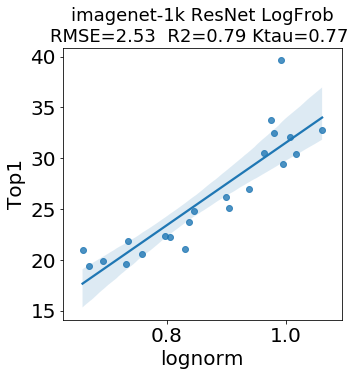

save to ./img/omsr_imagenet_1k_ResNet_spectralnormlog.png


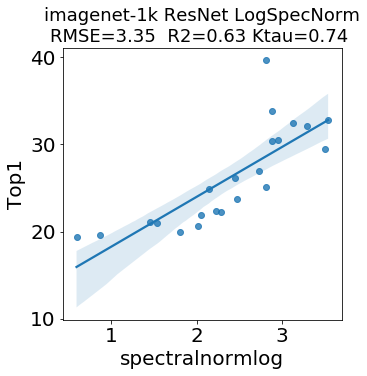

save to ./img/omsr_imagenet_1k_ResNet_alpha_weighted.png


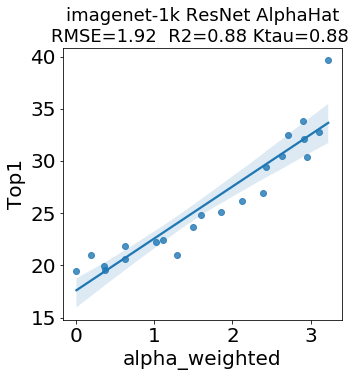

save to ./img/omsr_imagenet_1k_ResNet_logpnorm.png


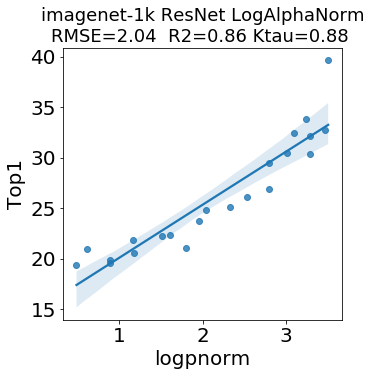

save to ./img/omsr_imagenet_1k_EfficientNet_lognorm.png


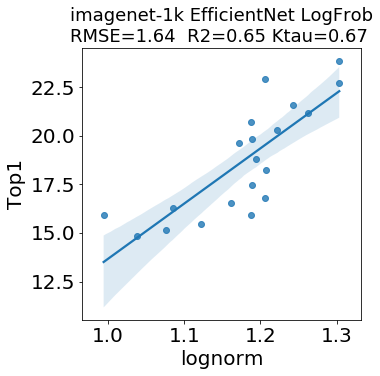

save to ./img/omsr_imagenet_1k_EfficientNet_spectralnormlog.png


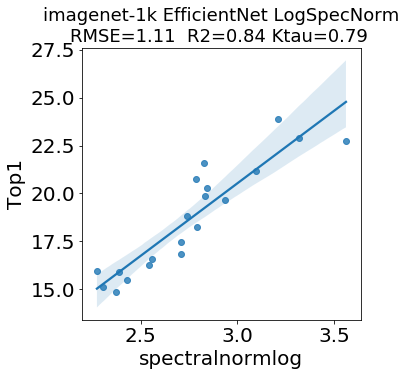

save to ./img/omsr_imagenet_1k_EfficientNet_alpha_weighted.png


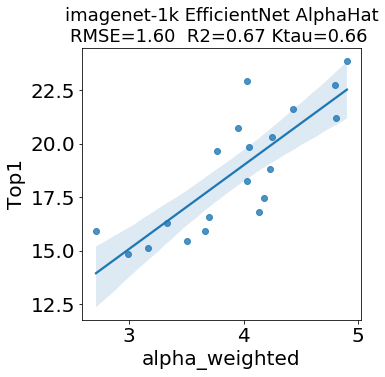

save to ./img/omsr_imagenet_1k_EfficientNet_logpnorm.png


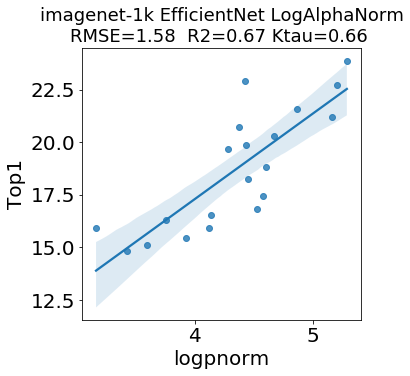

save to ./img/omsr_imagenet_1k_PreResNet_lognorm.png


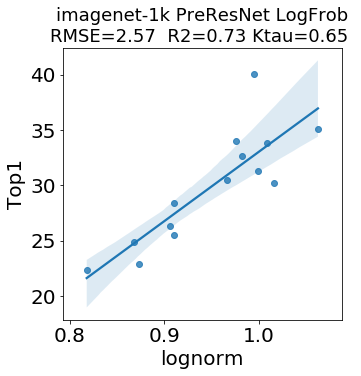

save to ./img/omsr_imagenet_1k_PreResNet_spectralnormlog.png


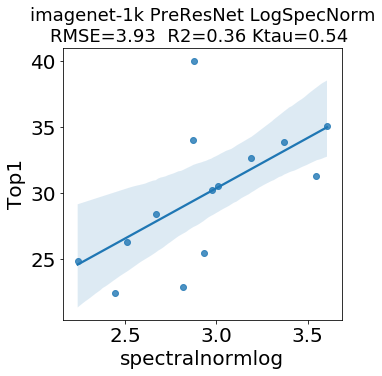

save to ./img/omsr_imagenet_1k_PreResNet_alpha_weighted.png


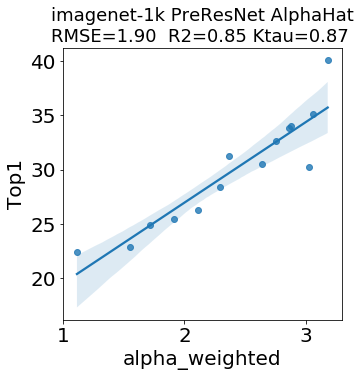

save to ./img/omsr_imagenet_1k_PreResNet_logpnorm.png


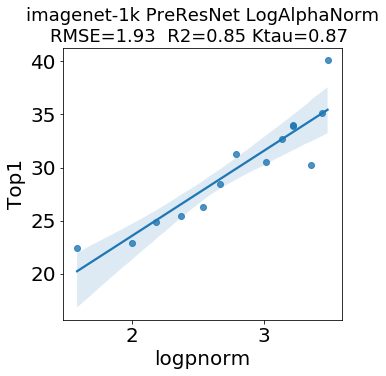

save to ./img/omsr_imagenet_1k_ShuffleNet_lognorm.png


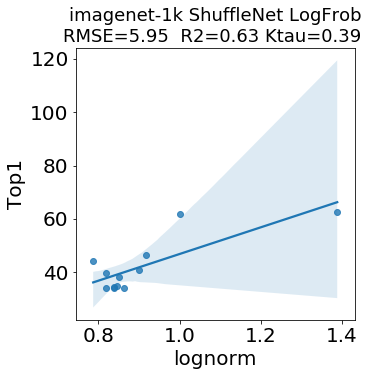

save to ./img/omsr_imagenet_1k_ShuffleNet_spectralnormlog.png


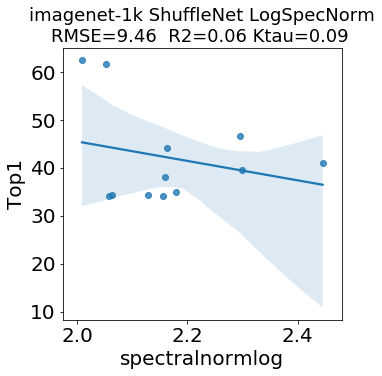

save to ./img/omsr_imagenet_1k_ShuffleNet_alpha_weighted.png


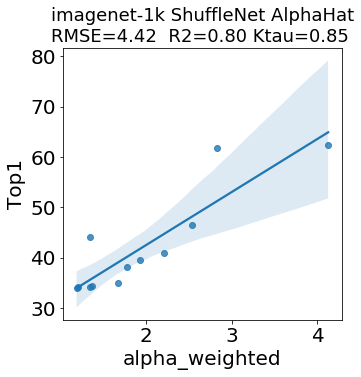

save to ./img/omsr_imagenet_1k_ShuffleNet_logpnorm.png


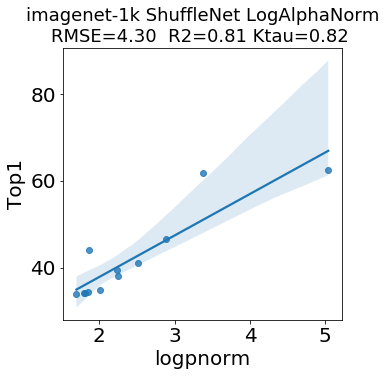

save to ./img/omsr_imagenet_1k_VGG_lognorm.png


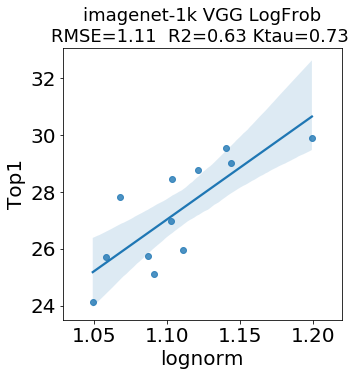

save to ./img/omsr_imagenet_1k_VGG_spectralnormlog.png


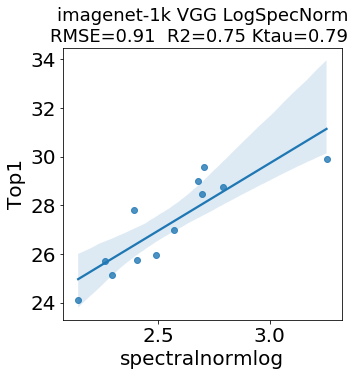

save to ./img/omsr_imagenet_1k_VGG_alpha_weighted.png


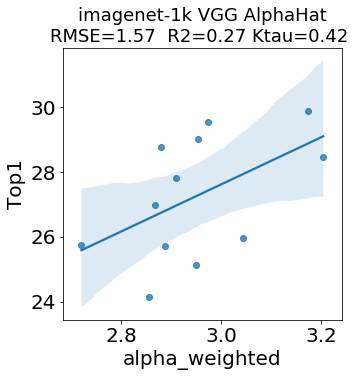

save to ./img/omsr_imagenet_1k_VGG_logpnorm.png


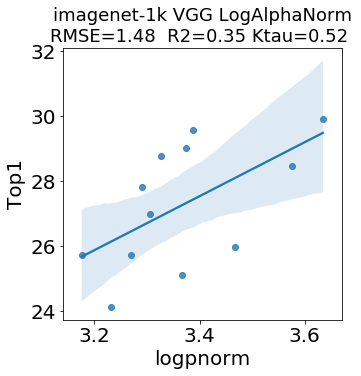

save to ./img/omsr_imagenet_1k_DLA_lognorm.png


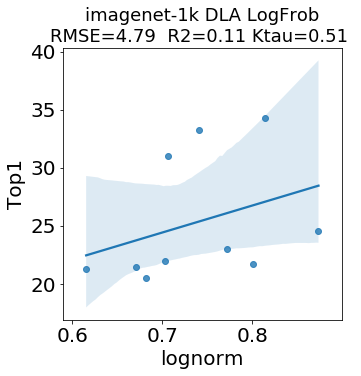

save to ./img/omsr_imagenet_1k_DLA_spectralnormlog.png


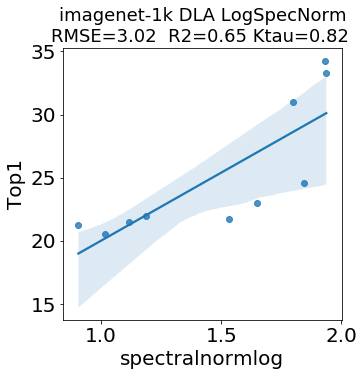

save to ./img/omsr_imagenet_1k_DLA_alpha_weighted.png


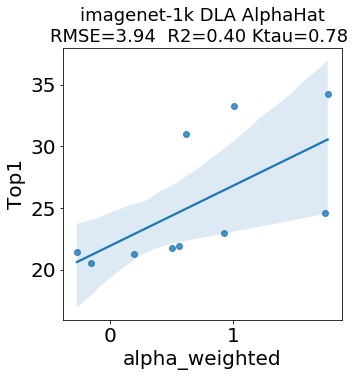

save to ./img/omsr_imagenet_1k_DLA_logpnorm.png


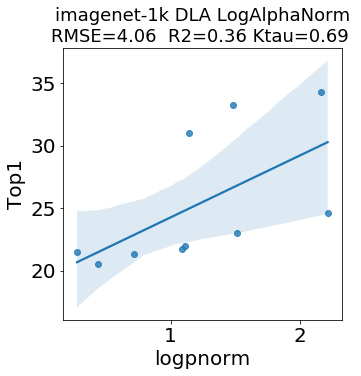

save to ./img/omsr_imagenet_1k_HRNet_lognorm.png


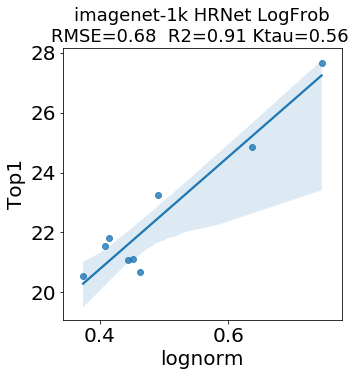

save to ./img/omsr_imagenet_1k_HRNet_spectralnormlog.png


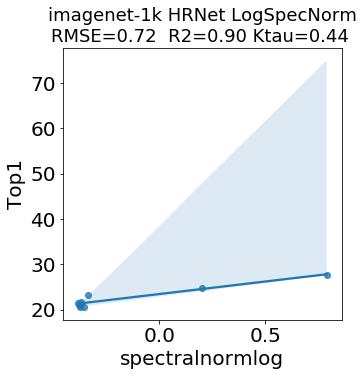

save to ./img/omsr_imagenet_1k_HRNet_alpha_weighted.png


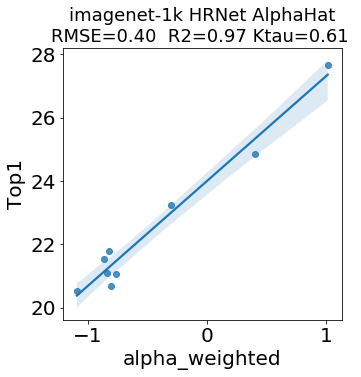

save to ./img/omsr_imagenet_1k_HRNet_logpnorm.png


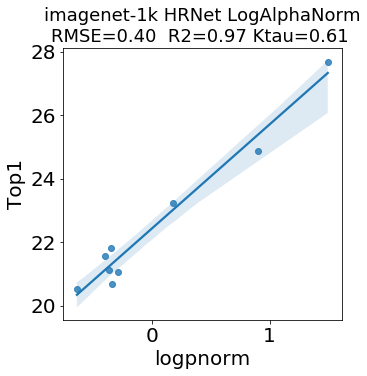

save to ./img/omsr_imagenet_1k_DRN_C_lognorm.png


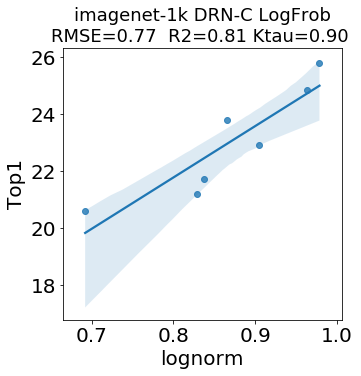

save to ./img/omsr_imagenet_1k_DRN_C_spectralnormlog.png


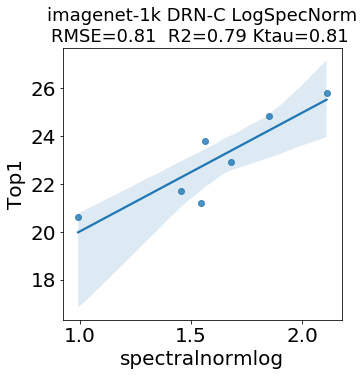

save to ./img/omsr_imagenet_1k_DRN_C_alpha_weighted.png


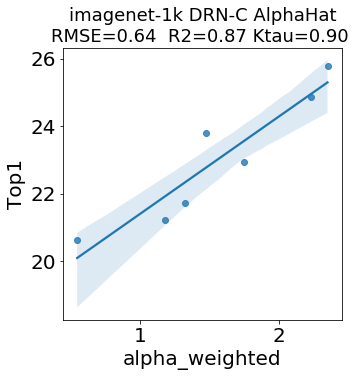

save to ./img/omsr_imagenet_1k_DRN_C_logpnorm.png


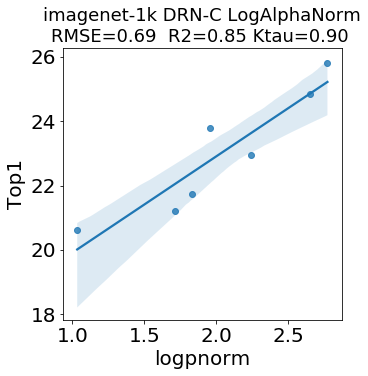

save to ./img/omsr_imagenet_1k_SqueezeNext_lognorm.png


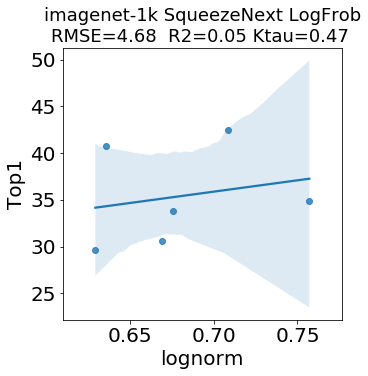

save to ./img/omsr_imagenet_1k_SqueezeNext_spectralnormlog.png


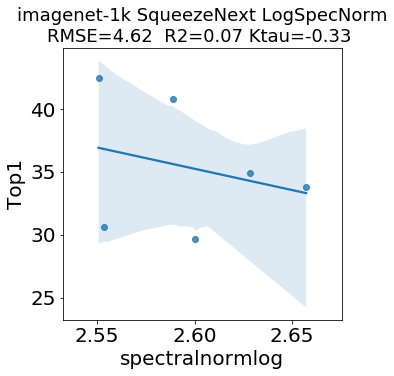

save to ./img/omsr_imagenet_1k_SqueezeNext_alpha_weighted.png


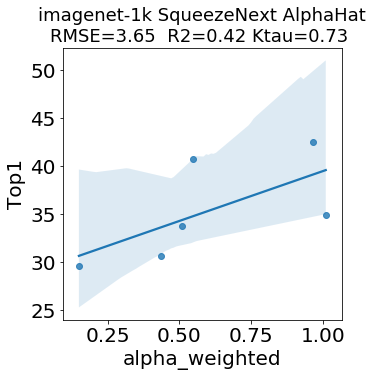

save to ./img/omsr_imagenet_1k_SqueezeNext_logpnorm.png


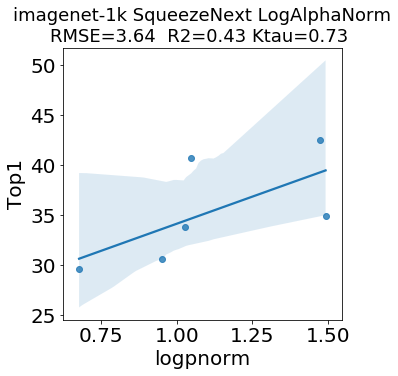

save to ./img/omsr_imagenet_1k_ESPNetv2_lognorm.png


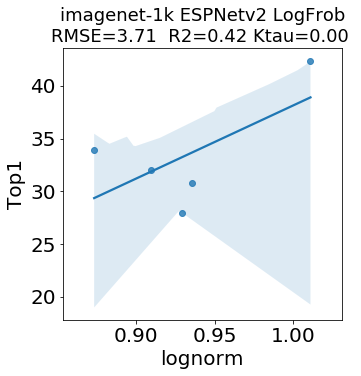

save to ./img/omsr_imagenet_1k_ESPNetv2_spectralnormlog.png


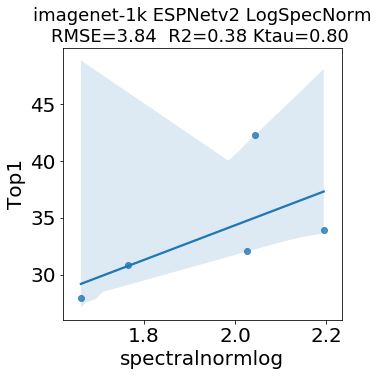

save to ./img/omsr_imagenet_1k_ESPNetv2_alpha_weighted.png


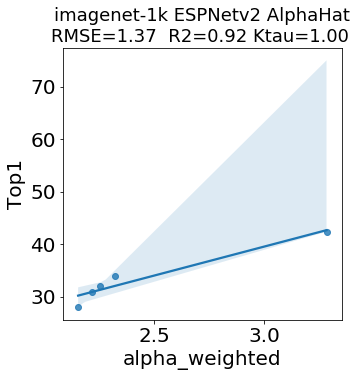

save to ./img/omsr_imagenet_1k_ESPNetv2_logpnorm.png


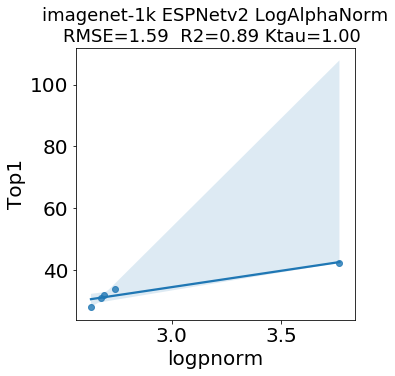

save to ./img/omsr_imagenet_1k_IGCV3_lognorm.png


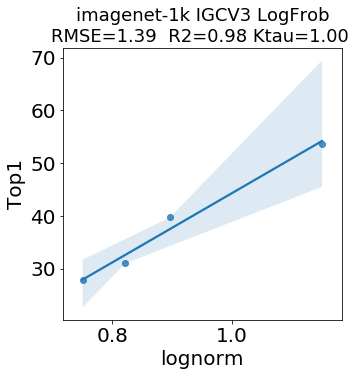

save to ./img/omsr_imagenet_1k_IGCV3_spectralnormlog.png


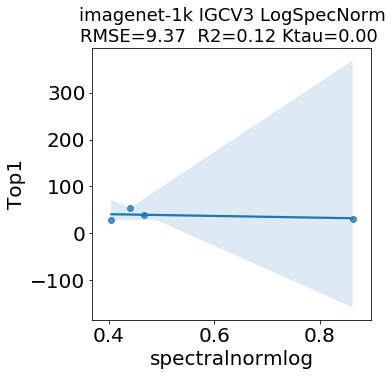

save to ./img/omsr_imagenet_1k_IGCV3_alpha_weighted.png


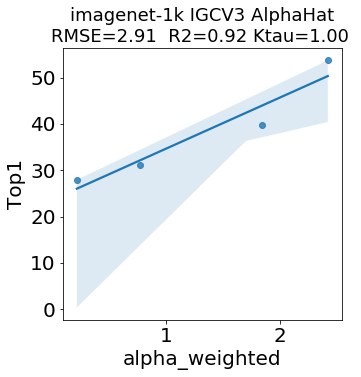

save to ./img/omsr_imagenet_1k_IGCV3_logpnorm.png


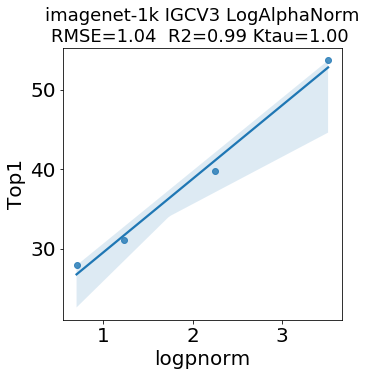

save to ./img/omsr_imagenet_1k_SqueezeNet_lognorm.png


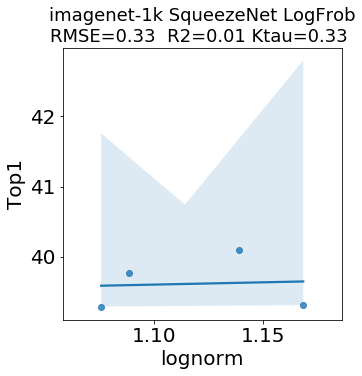

save to ./img/omsr_imagenet_1k_SqueezeNet_spectralnormlog.png


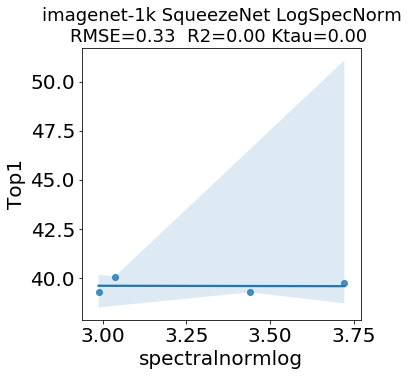

save to ./img/omsr_imagenet_1k_SqueezeNet_alpha_weighted.png


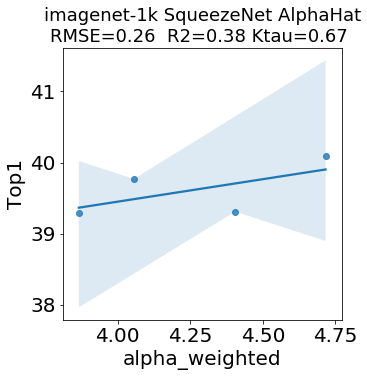

save to ./img/omsr_imagenet_1k_SqueezeNet_logpnorm.png


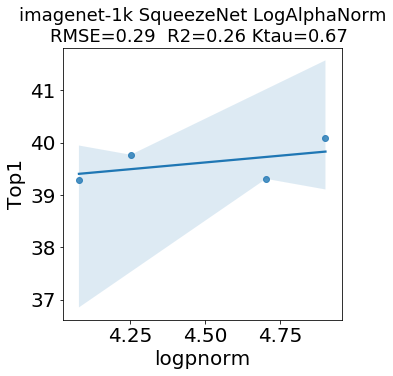

save to ./img/omsr_imagenet_1k_ProxylessNAS_lognorm.png


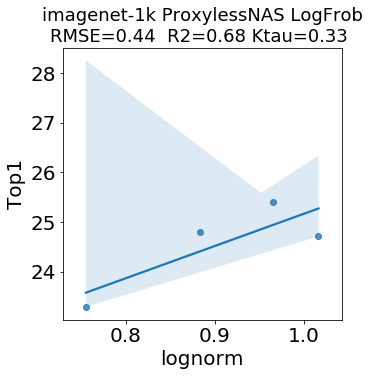

save to ./img/omsr_imagenet_1k_ProxylessNAS_spectralnormlog.png


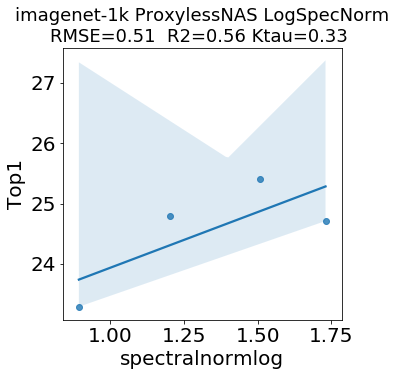

save to ./img/omsr_imagenet_1k_ProxylessNAS_alpha_weighted.png


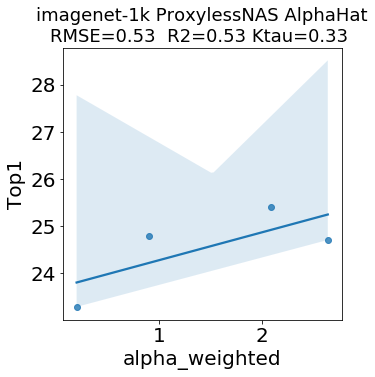

save to ./img/omsr_imagenet_1k_ProxylessNAS_logpnorm.png


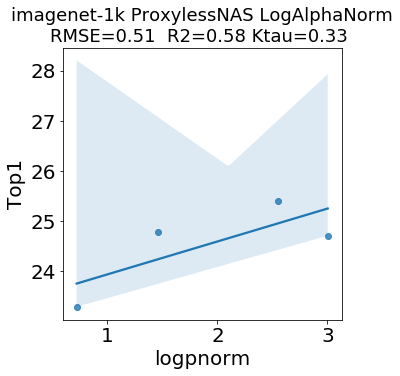

cifar-10
save to ./img/omsr_cifar_10_ResNet_lognorm.png


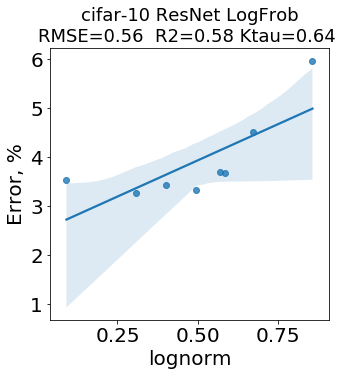

save to ./img/omsr_cifar_10_ResNet_spectralnormlog.png


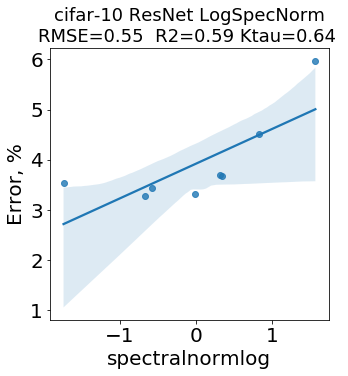

save to ./img/omsr_cifar_10_ResNet_alpha_weighted.png


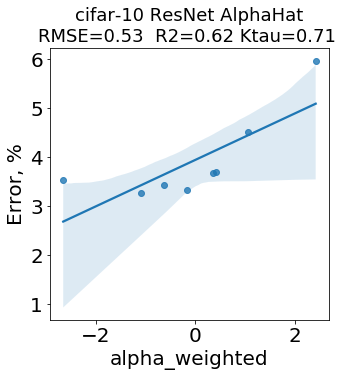

save to ./img/omsr_cifar_10_ResNet_logpnorm.png


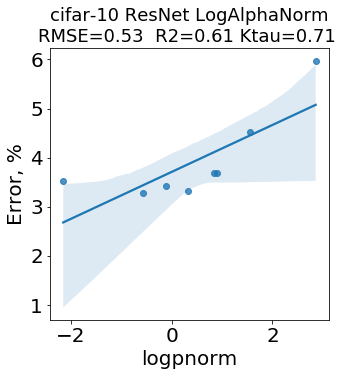

save to ./img/omsr_cifar_10_DIA_ResNet_lognorm.png


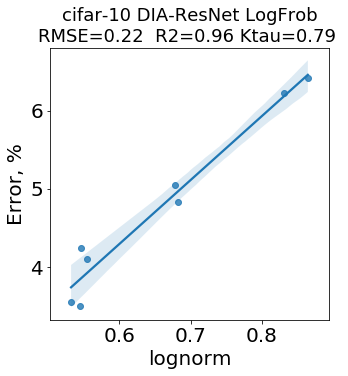

save to ./img/omsr_cifar_10_DIA_ResNet_spectralnormlog.png


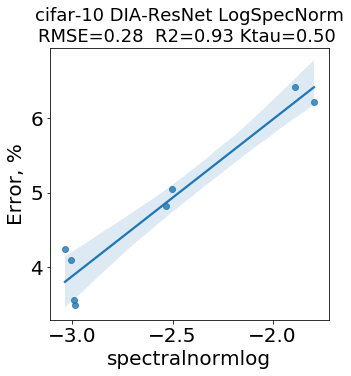

save to ./img/omsr_cifar_10_DIA_ResNet_alpha_weighted.png


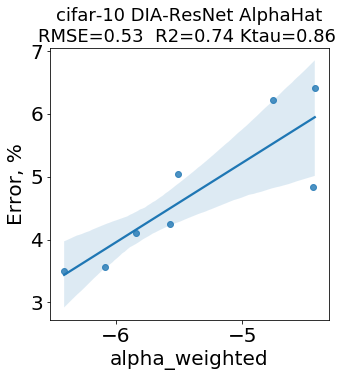

save to ./img/omsr_cifar_10_DIA_ResNet_logpnorm.png


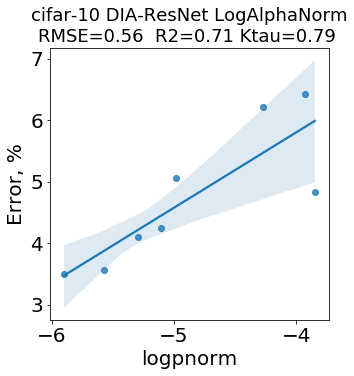

save to ./img/omsr_cifar_10_SENet_lognorm.png


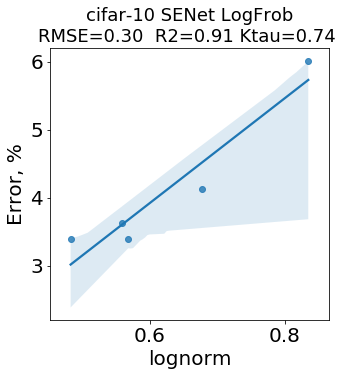

save to ./img/omsr_cifar_10_SENet_spectralnormlog.png


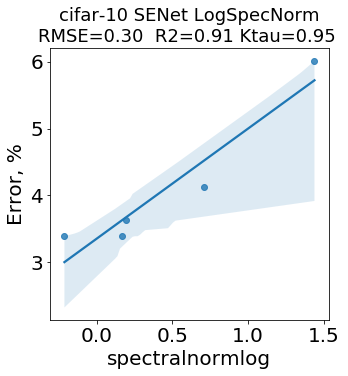

save to ./img/omsr_cifar_10_SENet_alpha_weighted.png


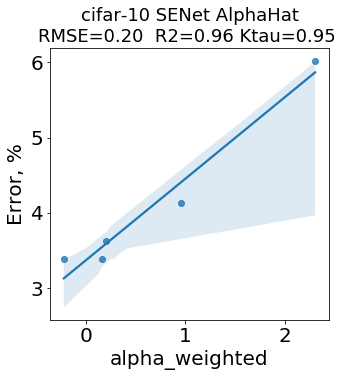

save to ./img/omsr_cifar_10_SENet_logpnorm.png


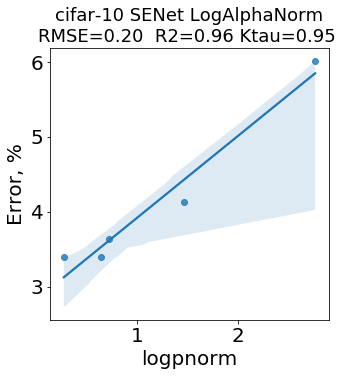

cifar-100
save to ./img/omsr_cifar_100_ResNet_lognorm.png


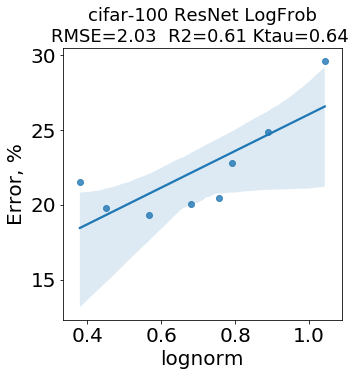

save to ./img/omsr_cifar_100_ResNet_spectralnormlog.png


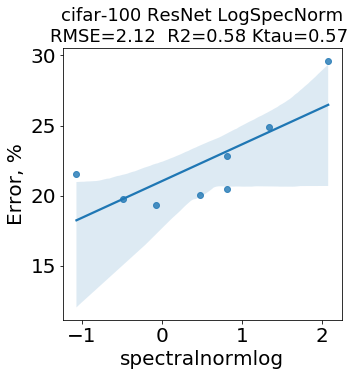

save to ./img/omsr_cifar_100_ResNet_alpha_weighted.png


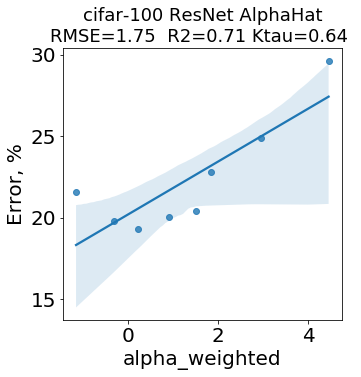

save to ./img/omsr_cifar_100_ResNet_logpnorm.png


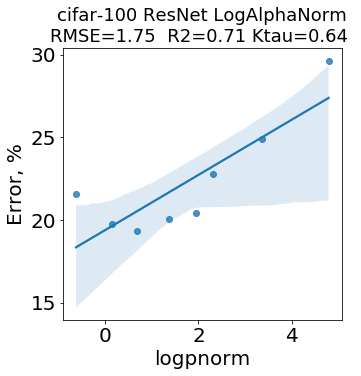

save to ./img/omsr_cifar_100_DIA_ResNet_lognorm.png


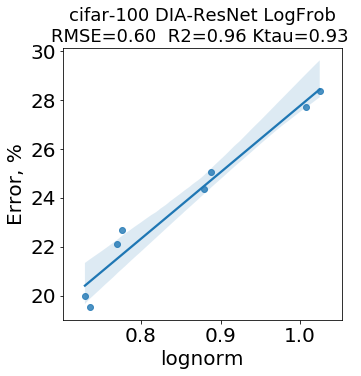

save to ./img/omsr_cifar_100_DIA_ResNet_spectralnormlog.png


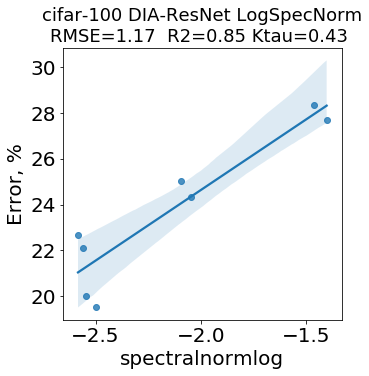

save to ./img/omsr_cifar_100_DIA_ResNet_alpha_weighted.png


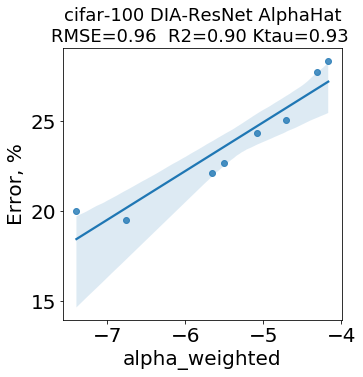

save to ./img/omsr_cifar_100_DIA_ResNet_logpnorm.png


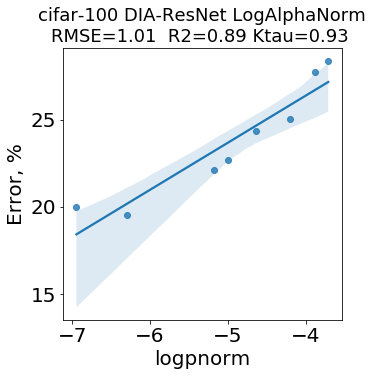

save to ./img/omsr_cifar_100_SENet_lognorm.png


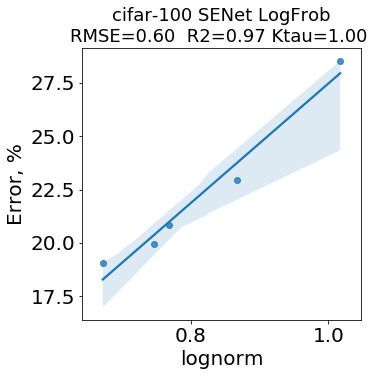

save to ./img/omsr_cifar_100_SENet_spectralnormlog.png


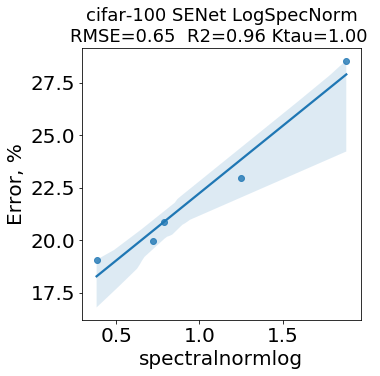

save to ./img/omsr_cifar_100_SENet_alpha_weighted.png


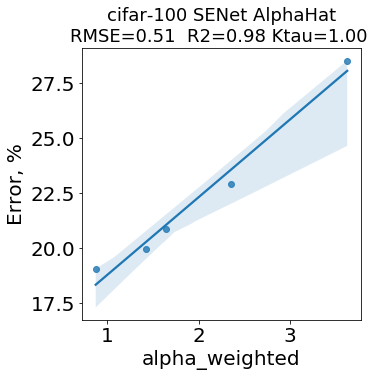

save to ./img/omsr_cifar_100_SENet_logpnorm.png


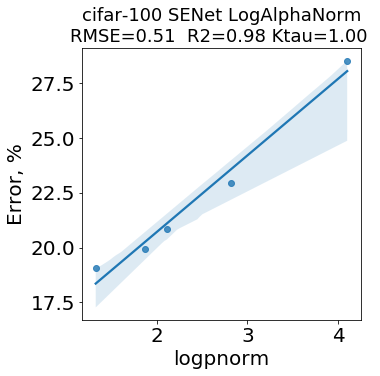

save to ./img/omsr_cifar_100_WRN_lognorm.png


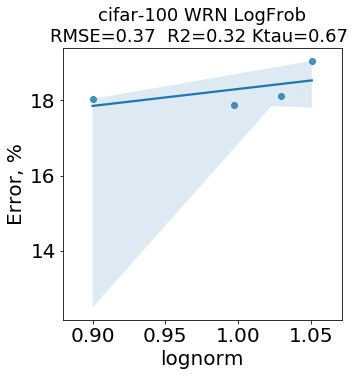

save to ./img/omsr_cifar_100_WRN_spectralnormlog.png


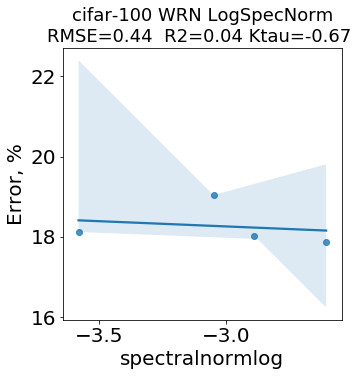

save to ./img/omsr_cifar_100_WRN_alpha_weighted.png


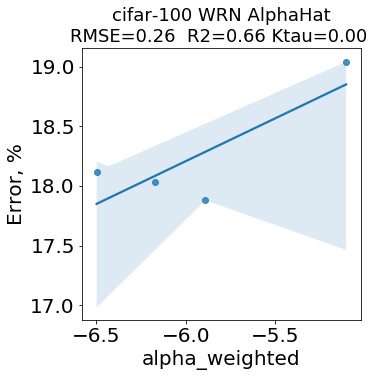

save to ./img/omsr_cifar_100_WRN_logpnorm.png


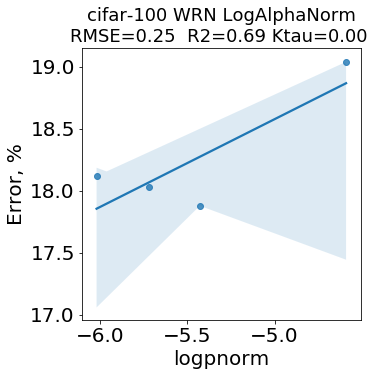

svhn
save to ./img/omsr_svhn_DIA_ResNet_lognorm.png


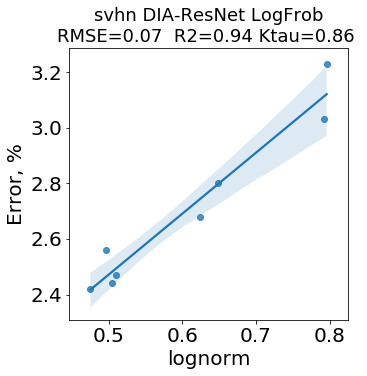

save to ./img/omsr_svhn_DIA_ResNet_spectralnormlog.png


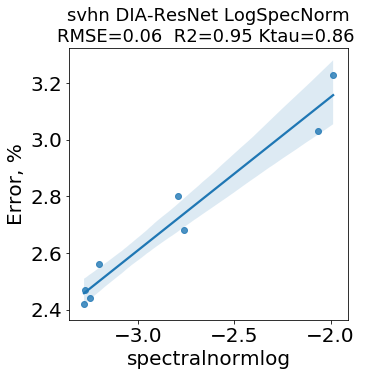

save to ./img/omsr_svhn_DIA_ResNet_alpha_weighted.png


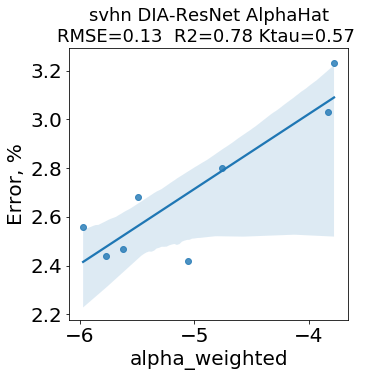

save to ./img/omsr_svhn_DIA_ResNet_logpnorm.png


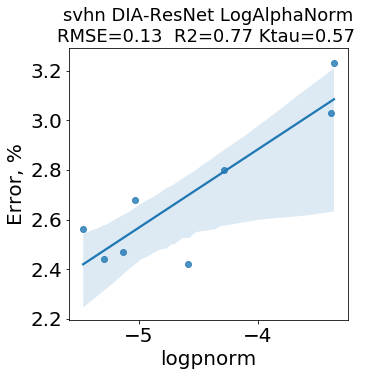

save to ./img/omsr_svhn_ResNet_lognorm.png


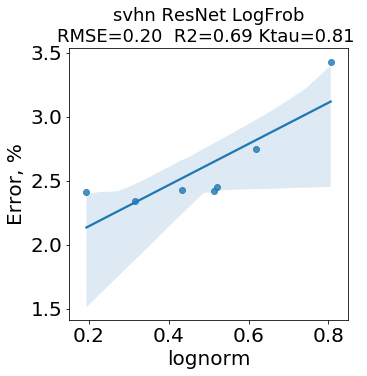

save to ./img/omsr_svhn_ResNet_spectralnormlog.png


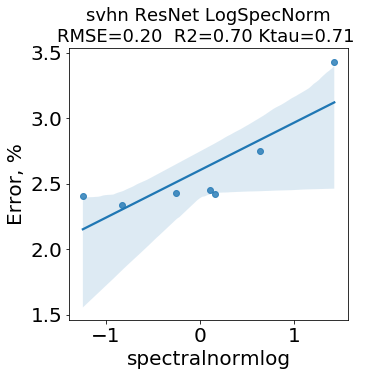

save to ./img/omsr_svhn_ResNet_alpha_weighted.png


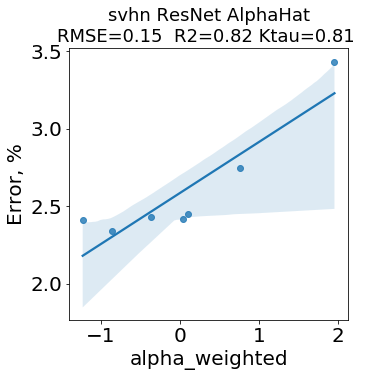

save to ./img/omsr_svhn_ResNet_logpnorm.png


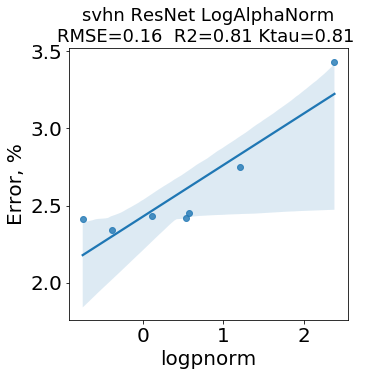

save to ./img/omsr_svhn_WRN_lognorm.png


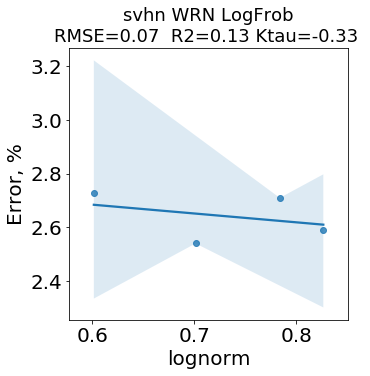

save to ./img/omsr_svhn_WRN_spectralnormlog.png


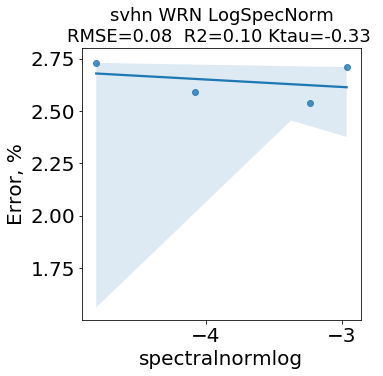

save to ./img/omsr_svhn_WRN_alpha_weighted.png


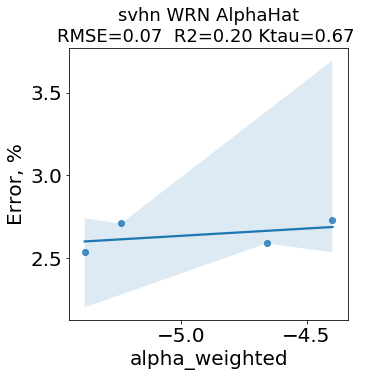

save to ./img/omsr_svhn_WRN_logpnorm.png


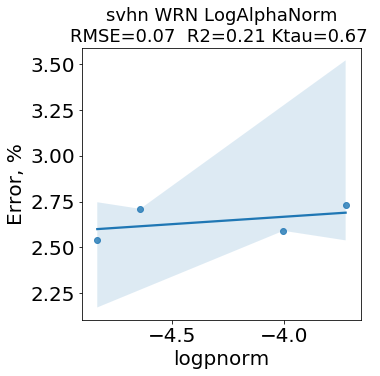

save to ./img/omsr_svhn_ResNeXt_lognorm.png


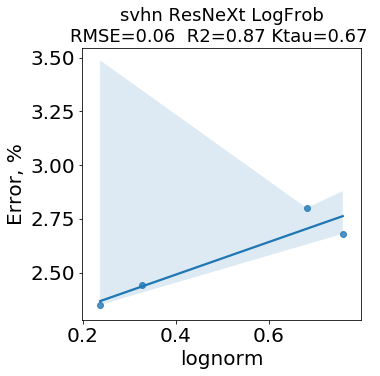

save to ./img/omsr_svhn_ResNeXt_spectralnormlog.png


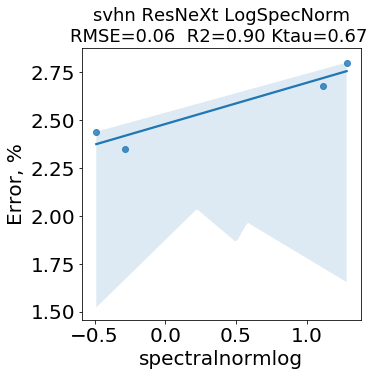

save to ./img/omsr_svhn_ResNeXt_alpha_weighted.png


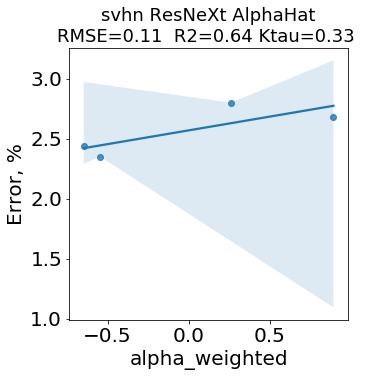

save to ./img/omsr_svhn_ResNeXt_logpnorm.png


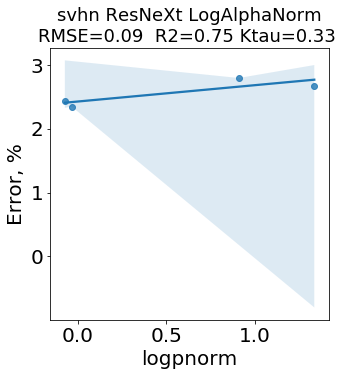

save to ./img/omsr_svhn_SENet_lognorm.png


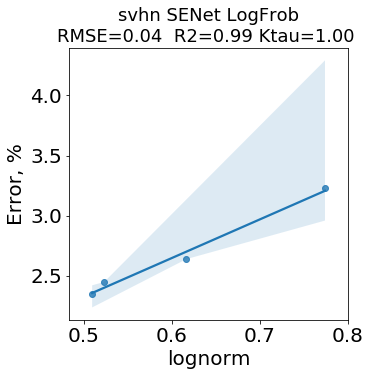

save to ./img/omsr_svhn_SENet_spectralnormlog.png


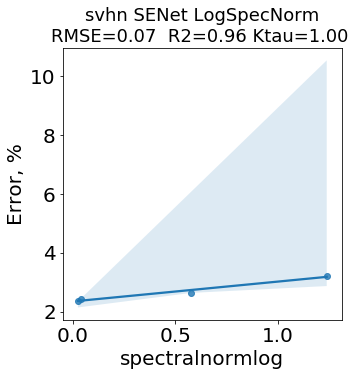

save to ./img/omsr_svhn_SENet_alpha_weighted.png


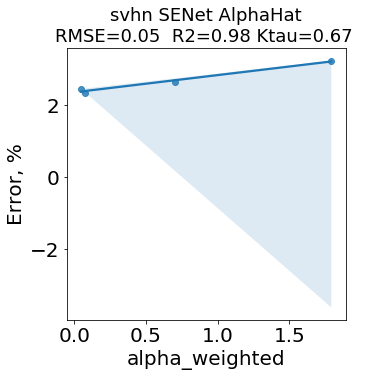

save to ./img/omsr_svhn_SENet_logpnorm.png


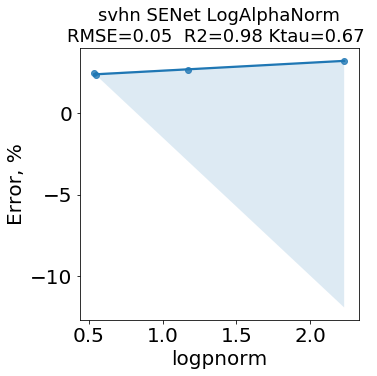

cub-200-2011
save to ./img/omsr_cub_200_2011_ResNet_lognorm.png


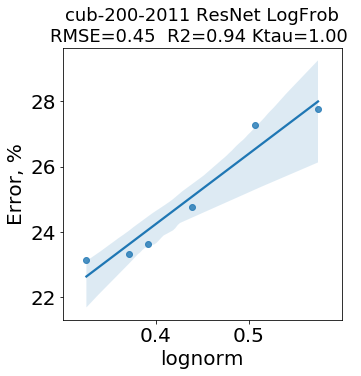

save to ./img/omsr_cub_200_2011_ResNet_spectralnormlog.png


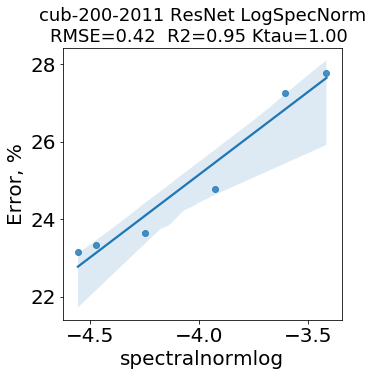

save to ./img/omsr_cub_200_2011_ResNet_alpha_weighted.png


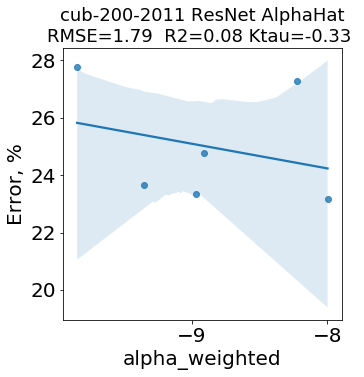

save to ./img/omsr_cub_200_2011_ResNet_logpnorm.png


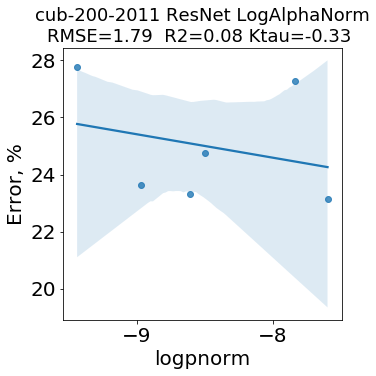

save to ./img/omsr_cub_200_2011_SENet_lognorm.png


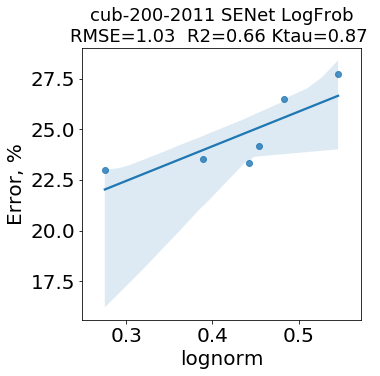

save to ./img/omsr_cub_200_2011_SENet_spectralnormlog.png


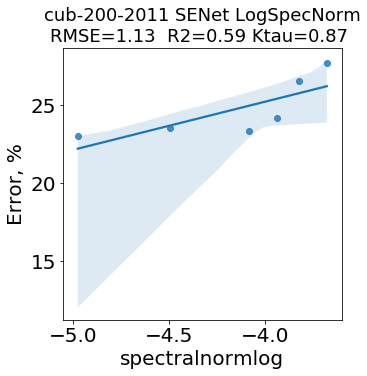

save to ./img/omsr_cub_200_2011_SENet_alpha_weighted.png


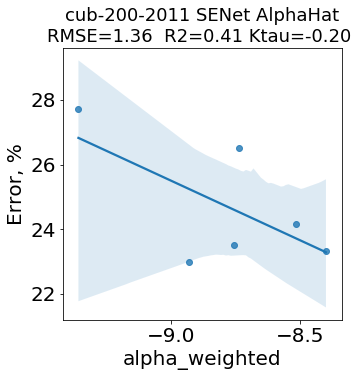

save to ./img/omsr_cub_200_2011_SENet_logpnorm.png


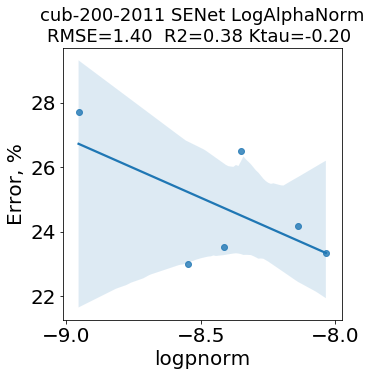

pascal-voc20102
ade20k
cityscapes
coco-semantic-segmentation
celebamask-hq
coco-keypoints-detection


In [23]:
import warnings
import re

metrics = [  'lognorm' ,'spectralnormlog',  'alpha_weighted' , 'logpnorm' ] #specify the ww matrics
metrics_acc = ['Top1', 'Error, %', 'Pix.Acc.,%', 'mIoU,%'] #specify the test accuracy

metric_name = {'lognorm':'LogFrob', 'spectralnormlog':'LogSpecNorm',  'alpha_weighted':'AlphaHat' , 'logpnorm':'LogAlphaNorm'}

this_deg = 1  # cnly linear here

min_num_models = 4

table6_counts = {}
table6new_counts = {}


#ALL_METRICS = ['RMSE', 'R2', 'R2_adj', 'Ktau']
ALL_METRICS = ['RMSE', 'R2',  'Ktau']

df_fit = []
for d in datasets:
    print(d)
    df = df_full[d].copy()
    df.dropna(inplace=True)

    this_groups = df['group'].value_counts().to_frame()

    table6new_counts[d] = {}

    for g in this_groups[this_groups['group'] >= min_num_models].index:

        this_group = df[df['group'] == g].copy()
        this_group = this_group.dropna().reset_index(drop = True)
        n = len(this_group) #size
        
        table6new_counts[d][g] = n 
        if g in table6_counts:
            table6_counts[g] = table6_counts[g] + n
        else:
            table6_counts[g] = n


        tacc = [c for c in metrics_acc if c in this_group.columns]

        for ac in tacc:  #accuracies
            #print("Dataset {} Group {} Metric  {}".format(d,tacc, len(d)))

            for x in metrics:
                plt.figure(figsize = (5,5))

                # fix modelname for figures
                short_g = g.split("/")[0] #
                short_g = short_g.split("\\")[0] 

                title = '{} {} {}'.format(d, short_g, metric_name[x])
                figname = "./img/omsr_{}_{}_{}.png".format(d, short_g, x).replace("-","_")
                    
                try:
                    #for i in range(len(this_group)):
                        ## USE SNS  plt.scatter(this_group.loc[i,x], this_group.loc[i, ac], label = this_group.loc[i, 'modelname'], c='b')                       
                    
                    plt.xlabel(metric_name[x])
                    plt.ylabel(ac)

                    with warnings.catch_warnings():
                        warnings.simplefilter("ignore")  

                        y = this_group[ac]  # pandas Series, not np array
                        X = this_group[x]
                        
                        # https://stackoverflow.com/questions/20701484/why-do-i-get-only-one-parameter-from-a-statsmodels-ols-fit
                        X_plus = sm.add_constant(X) # add an intercept

                        this_fit = sm.OLS(y, X_plus).fit() 
                        coef = this_fit.params[x]          
                        
                        # basic measures
                        SSR = this_fit.ssr
                        R2 = this_fit.rsquared
                        #BIC = this_fit. BIC

                        # plot line
                        this_x = np.linspace(min(X), max(X), 50)
                        this_x_plus = sm.add_constant(this_x) 
                        y_pred_line = this_fit.predict(this_x_plus)
                        ## USE SNS plt.plot(this_x, y_pred_line) ##coef[0]*this_x**2 + coef[1]*this_x + coef[2])                     
                        sns.regplot(x=X, y=y)                        

                        # rank correlation metric
                        Ktau, pvsl = kendalltau(X,y)   
                        
                        # RMSE
                        X_arr, y_arr  = X.to_numpy(), y.to_numpy()
                        y_pred = this_fit.predict(X_plus)
                        RMSE =  mean_squared_error(y, y_pred, squared=False)

                        # ['RMSE', 'R2', 'R2_adj', 'Ktau']
                        this_arch = [d, g, ac, x, this_deg, n, RMSE, R2, Ktau]
                        title += "\nRMSE={:03.2f}  R2={:03.2f} Ktau={:03.2f} ".format(RMSE, R2, Ktau)
                        plt.title(title, fontsize=18)
                        #plt.legend(loc='center left', bbox_to_anchor=(1, 0.5)) #this_group['Model']
                    print("save to "+figname)
                    plt.savefig(figname)
                    plt.show()

                                         

                except np.linalg.LinAlgError: #does not converge
                    print("{} did not converge {}".format(d))
                    this_arch = [d, g, ac, x, this_deg, n, np.nan, np.nan, np.nan]

                    
                except Exception as e:
                    print(e)
                    pass
                         
                df_fit.append(this_arch)
                

In [24]:
header_cols = ['Dataset', 'Archtecture', 'Test Accuracy', 
                  'x Variable', 'Poly Degree','# of Models']
header_cols.extend(ALL_METRICS)

df_fit = pd.DataFrame(df_fit, columns = header_cols)
print("number of records {}".format(len(df_fit)))
df_fit.dropna(inplace=True)


print("number of records (after dropping bad ones) {}".format(len(df_fit)))

number of records 108
number of records (after dropping bad ones) 108


In [25]:
df_fit.head()

Dataset   Archtecture Test Accuracy       x Variable  Poly Degree  \
0  imagenet-1k        ResNet          Top1          lognorm            1   
1  imagenet-1k        ResNet          Top1  spectralnormlog            1   
2  imagenet-1k        ResNet          Top1   alpha_weighted            1   
3  imagenet-1k        ResNet          Top1         logpnorm            1   
4  imagenet-1k  EfficientNet          Top1          lognorm            1   

   # of Models      RMSE        R2      Ktau  
0           22  2.527986  0.791297  0.774892  
1           22  3.346936  0.634175  0.740260  
2           22  1.918791  0.879764  0.878788  
3           22  2.043353  0.863647  0.878788  
4           20  1.635301  0.651727  0.673684

In [26]:
for x in (ALL_METRICS):
    temp = df_fit.copy()
    temp = temp[temp['# of Models'] > 3].reset_index(drop = True)
    print(len(temp))
    df_fitp = temp.pivot_table(values = x, columns = 'x Variable', 
                            index = ['Dataset', 'Archtecture', 'Test Accuracy'])

    print('For ' + x + ':')
    summary = df_fitp.describe()
    display(summary)
    print('===============================================')

del df_fitp

108
For RMSE:


x Variable  alpha_weighted    lognorm   logpnorm  spectralnormlog
count            27.000000  27.000000  27.000000        27.000000
mean              1.240670   1.377489   1.187499         1.834004
std               1.246601   1.638123   1.202514         2.560958
min               0.049208   0.041041   0.048185         0.055900
25%               0.263418   0.315684   0.270540         0.316955
50%               0.635986   0.602824   0.690894         0.715478
75%               1.767779   1.833354   1.670874         2.571723
max               4.420142   5.948063   4.298913         9.464668

108
For R2:


x Variable  alpha_weighted    lognorm   logpnorm  spectralnormlog
count            27.000000  27.000000  27.000000        27.000000
mean              0.679762   0.664003   0.680883         0.597811
std               0.259036   0.305651   0.263465         0.334700
min               0.083627   0.005399   0.076199         0.000602
25%               0.478576   0.593980   0.500677         0.367372
50%               0.738633   0.687392   0.745447         0.647078
75%               0.890187   0.925918   0.877216         0.901194
max               0.979183   0.985519   0.989105         0.962670

108
For Ktau:


x Variable  alpha_weighted    lognorm   logpnorm  spectralnormlog
count            27.000000  27.000000  27.000000        27.000000
mean              0.641319   0.651633   0.637626         0.519240
std               0.351068   0.310957   0.346364         0.450271
min              -0.333333  -0.333333  -0.333333        -0.666667
25%               0.591270   0.533333   0.591270         0.380952
50%               0.714286   0.673684   0.688889         0.666667
75%               0.873460   0.861905   0.873460         0.815873
max               1.000000   1.000000   1.000000         1.000000

### Table 3:  to be updated

In [27]:
pd.options.display.float_format = '{:,.3f} '.format
for x in ALL_METRICS:
    temp = df_fit.copy()
    temp = temp[temp['# of Models'] > 3].reset_index(drop = True)
    print(len(temp))
    df_fitp = temp.pivot_table(values = x, columns = 'x Variable', 
                            index = ['Dataset', 'Archtecture', 'Test Accuracy'])

    print('For ' + x + ':')
    summary = df_fitp[['lognorm', 'spectralnormlog', 'alpha_weighted', 'logpnorm']].describe()
    display(summary.loc[['mean', 'std']])
    print('===============================================')

del df_fitp

108
For RMSE:


x Variable  lognorm  spectralnormlog  alpha_weighted  logpnorm
mean         1.377            1.834           1.241     1.187 
std          1.638            2.561           1.247     1.203

108
For R2:


x Variable  lognorm  spectralnormlog  alpha_weighted  logpnorm
mean         0.664            0.598           0.680     0.681 
std          0.306            0.335           0.259     0.263

108
For Ktau:


x Variable  lognorm  spectralnormlog  alpha_weighted  logpnorm
mean         0.652            0.519           0.641     0.638 
std          0.311            0.450           0.351     0.346

In [28]:
pd.options.display.float_format = '{:,.3f} '.format
for x in ALL_METRICS:
    temp = df_fit.copy()
    temp = temp[temp['# of Models'] > 3].reset_index(drop = True)
    print(len(temp))
    df_fitp = temp.pivot_table(values = x, columns = 'x Variable', 
                            index = ['Dataset', 'Archtecture', 'Test Accuracy'])

    print('For ' + x + ':')
    summary = df_fitp[['lognorm', 'spectralnormlog', 'alpha_weighted', 'logpnorm']].describe()
    display(summary.loc[['mean', 'std']])
    print('===============================================')

del df_fitp

108
For RMSE:


x Variable  lognorm  spectralnormlog  alpha_weighted  logpnorm
mean         1.377            1.834           1.241     1.187 
std          1.638            2.561           1.247     1.203

108
For R2:


x Variable  lognorm  spectralnormlog  alpha_weighted  logpnorm
mean         0.664            0.598           0.680     0.681 
std          0.306            0.335           0.259     0.263

108
For Ktau:


x Variable  lognorm  spectralnormlog  alpha_weighted  logpnorm
mean         0.652            0.519           0.641     0.638 
std          0.311            0.450           0.351     0.346

In [29]:
pd.options.display.float_format = '{:,.3f} '.format
for x in ALL_METRICS:
    temp = df_fit.copy()
    temp = temp[temp['# of Models'] > 3].reset_index(drop = True)
    print(len(temp))
    df_fitp = temp.pivot_table(values = x, columns = 'x Variable', 
                            index = ['Dataset', 'Archtecture', 'Test Accuracy'])

    print('For ' + x + ':')
    summary = df_fitp[['lognorm', 'spectralnormlog', 'alpha_weighted', 'logpnorm']].describe()
    display(summary.loc[['mean', 'std']])
    print('===============================================')

108
For RMSE:


x Variable  lognorm  spectralnormlog  alpha_weighted  logpnorm
mean         1.377            1.834           1.241     1.187 
std          1.638            2.561           1.247     1.203

108
For R2:


x Variable  lognorm  spectralnormlog  alpha_weighted  logpnorm
mean         0.664            0.598           0.680     0.681 
std          0.306            0.335           0.259     0.263

108
For Ktau:


x Variable  lognorm  spectralnormlog  alpha_weighted  logpnorm
mean         0.652            0.519           0.641     0.638 
std          0.311            0.450           0.351     0.346

## Table 3

In [30]:
TABLE3_HEADER='''
\\begin{table}[t]
\\small
\\begin{center}
\\begin{tabular}{|p{1.25in}|c|c|c|c|}
\\hline
  & $\\log\\Vert\\cdot\\Vert^{2}_{F}$ & $\\log\\Vert\\cdot\\Vert^{2}_{\\infty}$ & $\\hat{\\alpha}$ & $\\log\\Vert\\cdot\\Vert^{\\alpha}_{\\alpha}$ \\\\
\\hline
'''

TABLE3_FOOTER='''
\\hline
\\end{tabular}
\\end{center}
\\caption{Comparison of linear regression fits for different average Log Norm and Weighted Alpha metrics across 5 CV datasets, 17 architectures, covering \\
108 (out of over 400) different pretrained DNNs.
         We include regressions only for architectures with five or more data points, and which are positively correlated with test error.
         These results can be readily reproduced using the Google Colab notebooks.
         (See the Supplementary Information
         %~\\ref{sxn:appendix}                                                                                                                             
         for details.)}
\\label{table:results}
\\end{table}

'''

MEASURE_NAMES = {'RMSE':'RMSE', 'R2':'R2', 'R2_adj':'R2 adjusted', 'Ktau':"Kendal-tau"}

In [31]:
filename = "table_3.tex"

with open(filename, 'w') as f:
    with redirect_stdout(f):
        
        print(TABLE3_HEADER)

        for x in ALL_METRICS:
            name = MEASURE_NAMES[x]
                
            temp = df_fit.copy()
            temp = temp[temp['# of Models'] > 3].reset_index(drop = True)
            df_fitp = temp.pivot_table(values = x, columns = 'x Variable', 
                                    index = ['Dataset', 'Archtecture', 'Test Accuracy'])


            summary = df_fitp[['lognorm', 'spectralnormlog', 'alpha_weighted', 'logpnorm']].describe()
            

            vs = summary.mean().values
            line = r"{} (mean) & {:0.3} & {:0.3} & {:0.3}& {:0.3} \\".format(name, vs[0],vs[1],vs[2],vs[3])
            print(line)
        
            vs = summary.std().values
            line = r"{} (std) & {:0.3} & {:0.3} & {:0.3}& {:0.3} \\".format(name, vs[0],vs[1],vs[2],vs[3])
            print(line)
            print("\\hline")
        print(TABLE3_FOOTER)



In [32]:
!cat table_3.tex


\begin{table}[t]
\small
\begin{center}
\begin{tabular}{|p{1.25in}|c|c|c|c|}
\hline
  & $\log\Vert\cdot\Vert^{2}_{F}$ & $\log\Vert\cdot\Vert^{2}_{\infty}$ & $\hat{\alpha}$ & $\log\Vert\cdot\Vert^{\alpha}_{\alpha}$ \\
\hline

RMSE (mean) & 4.84 & 5.56 & 4.58& 4.55 \\
RMSE (std) & 9.14 & 9.17 & 9.16& 9.17 \\
\hline
R2 (mean) & 3.9 & 3.85 & 3.89& 3.89 \\
R2 (std) & 9.34 & 9.36 & 9.34& 9.34 \\
\hline
Kendal-tau (mean) & 3.84 & 3.77 & 3.85& 3.85 \\
Kendal-tau (std) & 9.37 & 9.4 & 9.36& 9.36 \\
\hline

\hline
\end{tabular}
\end{center}
\caption{Comparison of linear regression fits for different average Log Norm and Weighted Alpha metrics across 5 CV datasets, 17 architectures, covering \
108 (out of over 400) different pretrained DNNs.
         We include regressions only for architectures with five or more data points, and which are positively correlated with test error.
         These results can be readily reproduced using the Google Colab notebooks.
         (See the Supplementary Inform

In [33]:
!mv table_3.tex submission

## Tables 5 and 6

- updated , but need to double check all results

In [34]:
table6_counts

{'ResNet': 51,
 'EfficientNet': 20,
 'PreResNet': 14,
 'ShuffleNet': 12,
 'VGG/BN-VGG': 12,
 'DLA': 10,
 'HRNet': 9,
 'DRN-C/DRN-D': 7,
 'SqueezeNext/SqNxt': 6,
 'ESPNetv2': 5,
 'IGCV3': 4,
 'SqueezeNet/SqueezeResNet': 4,
 'ProxylessNAS': 4,
 'DIA-ResNet/DIA-PreResNet': 24,
 'SENet/SE-ResNet/SE-PreResNet/SE-ResNeXt': 20,
 'WRN': 8,
 'ResNeXt': 4}

#### sorted by name

In [35]:
for k, v in sorted(table6_counts.items()):
    print("{} & {} \\\\".format(k,v))

DIA-ResNet/DIA-PreResNet & 24 \\
DLA & 10 \\
DRN-C/DRN-D & 7 \\
ESPNetv2 & 5 \\
EfficientNet & 20 \\
HRNet & 9 \\
IGCV3 & 4 \\
PreResNet & 14 \\
ProxylessNAS & 4 \\
ResNeXt & 4 \\
ResNet & 51 \\
SENet/SE-ResNet/SE-PreResNet/SE-ResNeXt & 20 \\
ShuffleNet & 12 \\
SqueezeNet/SqueezeResNet & 4 \\
SqueezeNext/SqNxt & 6 \\
VGG/BN-VGG & 12 \\
WRN & 8 \\


#### sorted by values

In [36]:
sorted_by_counts = sorted(table6_counts.items(), key=lambda x: x[1], reverse=True)
for k,v in sorted_by_counts:
    print("{} & {} \\\\".format(k,v))

ResNet & 51 \\
DIA-ResNet/DIA-PreResNet & 24 \\
EfficientNet & 20 \\
SENet/SE-ResNet/SE-PreResNet/SE-ResNeXt & 20 \\
PreResNet & 14 \\
ShuffleNet & 12 \\
VGG/BN-VGG & 12 \\
DLA & 10 \\
HRNet & 9 \\
WRN & 8 \\
DRN-C/DRN-D & 7 \\
SqueezeNext/SqNxt & 6 \\
ESPNetv2 & 5 \\
IGCV3 & 4 \\
SqueezeNet/SqueezeResNet & 4 \\
ProxylessNAS & 4 \\
ResNeXt & 4 \\


## Table 6

In [37]:
TABLE6_HEADER = '''
\\begin{table}[t]
\\small
\\begin{center}
\\begin{tabular}{|l|c|c|c|c|c|c|}
\\hline
Architecture & $\\#$ of Models & Datasets & & & & \\\\
\\hline
'''

TABLE6_FOOTER = '''
\\hline
\\end{tabular}
\\end{center}
\\caption{Number of models for each architecture--dataset pair used in our large-scale analysis.}
\\label{table:architectures}
\\end{table}
'''

In [38]:
filename = "table_6.tex"


for g in table6_counts.keys():
    for d in valid_datasets:
        if g not in table6new_counts[d]:
            table6new_counts[d][g] = 0
            

with open(filename, 'w') as f:
    with redirect_stdout(f):
            
        print(TABLE6_HEADER)
        ds = [k for k in valid_datasets.keys()]
        ds[0], ds[1], ds[2], ds[3], ds[4]
        header = "{} & {} &{} & {} & {} & {} & {} \\\\".format(" ", "total", ds[0], ds[1], ds[2], ds[3], ds[4])
        print(header)
        print("\\hline")

        for g in table6_counts.keys():
            vs = [table6new_counts[d][g] for d in valid_datasets]
            if g.startswith('SENet'):
                g = "SENet/SE-ResNet"
            line = "{} & {} &{} & {} & {} & {} & {} \\\\".format(g, np.sum(vs), vs[0], vs[1], vs[2], vs[3], vs[4])
            print(line) 
        
        print(TABLE6_FOOTER)


In [39]:
!mv table_6.tex submission

## Tables 7, 8 , 9


#### Note:  you must fix references to these tables

for z in figs_largeScale_*.tex; do echo $z; done

In [40]:
temp = df_fit.copy()
df_appndx = temp#[temp['# of Models'] > 3].reset_index(drop = True)


series_names = df_appndx.Archtecture.unique()
dataset_names = df_appndx.Dataset.unique()

df_appndx.head()


Dataset   Archtecture Test Accuracy       x Variable  Poly Degree  \
0  imagenet-1k        ResNet          Top1          lognorm            1   
1  imagenet-1k        ResNet          Top1  spectralnormlog            1   
2  imagenet-1k        ResNet          Top1   alpha_weighted            1   
3  imagenet-1k        ResNet          Top1         logpnorm            1   
4  imagenet-1k  EfficientNet          Top1          lognorm            1   

   # of Models   RMSE     R2   Ktau  
0           22 2.528  0.791  0.775   
1           22 3.347  0.634  0.740   
2           22 1.919  0.880  0.879   
3           22 2.043  0.864  0.879   
4           20 1.635  0.652  0.674

In [41]:
TABLE_HEADER = '''
\\begin{table}[t]
\\scriptsize
\\begin{center}
\\begin{tabular}{|c|c|c|c|c|c|}
\\hline
Dataset & Model  & $\\langle\\log\\Vert\\cdot\\Vert^{2}_{F}\\rangle$ & $\\langle\\log\\Vert\\cdot\\Vert^{2}_{\\infty}\\rangle$ & $\\hat{\\alpha}$ & $\\langle\\log\\Vert\\cdot\\Vert^{\\alpha}_{\\alpha}\\rangle$ \\\\
'''



In [42]:
TABLE_FOOTER = '''
\\hline
\\end{tabular}
\\vspace{-5mm}
\\end{center}
\\caption{XXX Results for our analysis of all CV models in Table~\\ref{table:datasets}. }
\\label{table:XXXresults}
\\end{table}
'''

In [101]:


def make_table(metric='R2', max=True):

    filename = "table_{}.tex".format(metric)
    
    with open(filename, 'w') as f:
        with redirect_stdout(f):
            
            print(TABLE_HEADER)

            for dname in dataset_names: 
                print("\hline")
                for sname in series_names:
                    sname_fixed = re.sub(r"/.*","",sname)

                    df_ = df_appndx[df_appndx.Archtecture==sname]
                    df_ = df_[df_.Dataset==dname]
                    if (len(df_) > 0):
                        #display(df_)

                        fnorm_val = df_[df_['x Variable']=='lognorm'][metric].to_numpy()[0]
                        snorm_val = df_[df_['x Variable']=='spectralnormlog'][metric].to_numpy()[0]
                        wa_val =    df_[df_['x Variable']=='alpha_weighted'][metric].to_numpy()[0]
                        anorm_val = df_[df_['x Variable']=='logpnorm'][metric].to_numpy()[0]

                        all_val = np.array([fnorm_val, snorm_val, wa_val, anorm_val])
                        
                        # what to bold
                        fmts = ["{:03.2f}","{:03.2f}","{:03.2f}","{:03.2f}"]
                        if max:
                            check_val = np.max(all_val)
                        else:
                            check_val = np.min(all_val)
                        
                        line = "{} & {} ".format(dname, sname_fixed)
                        for ifx, val in zip([0,1,2,3], [fnorm_val,snorm_val,wa_val,anorm_val]):
                            #if (np.math.isclose(val, check_val, abs_tol=0.001)):
                            #if val == check_val:
                            if ("{:03.2f}".format(val)=="{:03.2f}".format(check_val)):
                                 fmts[ifx] = "\\textbf[{:03.2f}]"
                            line = line + " & " + fmts[ifx].format(val)
                    
                        line = line + " \\\\"
                        line = line.replace("[","{").replace("]","}")
                        print(line)
                                                
            print(TABLE_FOOTER.replace('XXX',metric))
  
        

In [102]:
make_table(metric='RMSE', max=False)

In [103]:
!cat table_RMSE.tex


\begin{table}[t]
\scriptsize
\begin{center}
\begin{tabular}{|c|c|c|c|c|c|}
\hline
Dataset & Model  & $\langle\log\Vert\cdot\Vert^{2}_{F}\rangle$ & $\langle\log\Vert\cdot\Vert^{2}_{\infty}\rangle$ & $\hat{\alpha}$ & $\langle\log\Vert\cdot\Vert^{\alpha}_{\alpha}\rangle$ \\

\hline
imagenet-1k & ResNet  & 2.53 & 3.35 & \textbf{1.92} & 2.04 \\
imagenet-1k & EfficientNet  & 1.64 & \textbf{1.11} & 1.60 & 1.58 \\
imagenet-1k & PreResNet  & 2.57 & 3.93 & \textbf{1.90} & 1.93 \\
imagenet-1k & ShuffleNet  & 5.95 & 9.46 & 4.42 & \textbf{4.30} \\
imagenet-1k & VGG  & 1.11 & \textbf{0.91} & 1.57 & 1.48 \\
imagenet-1k & DLA  & 4.79 & \textbf{3.02} & 3.94 & 4.06 \\
imagenet-1k & HRNet  & 0.68 & 0.72 & \textbf{0.40} & \textbf{0.40} \\
imagenet-1k & DRN-C  & 0.77 & 0.81 & \textbf{0.64} & 0.69 \\
imagenet-1k & SqueezeNext  & 4.68 & 4.62 & 3.65 & \textbf{3.64} \\
imagenet-1k & ESPNetv2  & 3.71 & 3.84 & \textbf{1.37} & 1.59 \\
imagenet-1k & IGCV3  & 1.39 & 9.37 & 2.91 & \textbf{1.04} \\
imagenet-1k & Squ

In [104]:
make_table(metric='R2')

In [105]:
make_table(metric='Ktau')

In [106]:
!mv table*tex submission

In [107]:
!ls submission/table*.tex

submission/table_3.tex    submission/table_Ktau.tex submission/table_RMSE.tex
submission/table_6.tex    submission/table_R2.tex


### Drill down into Table 3

In [108]:
ALL_METRICS = ['RMSE', 'R2',  'Ktau']


108


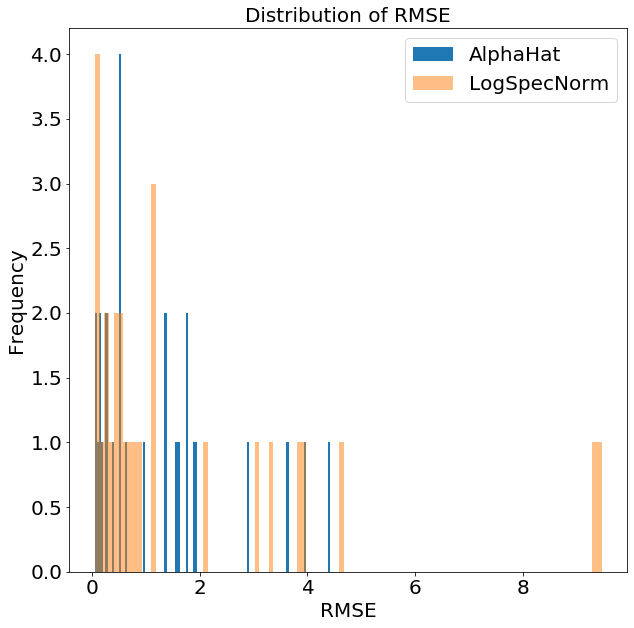

108


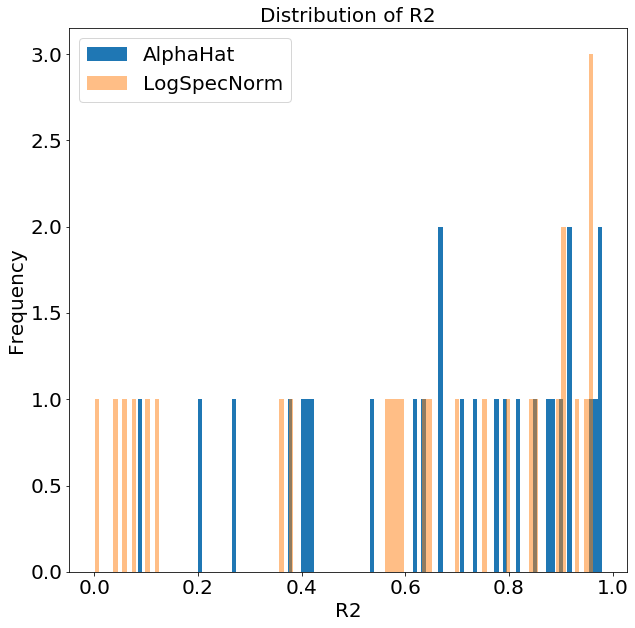

108


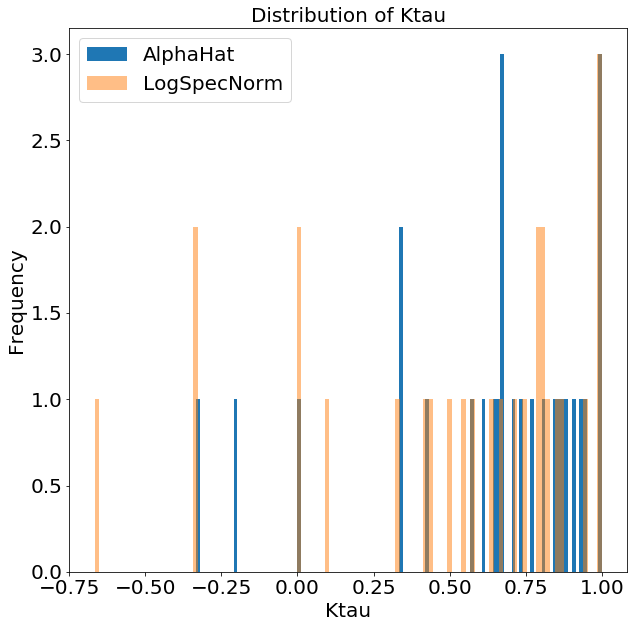

In [109]:
for x in ALL_METRICS:
    temp = df_fit.copy()
    temp = temp[temp['# of Models'] > 3].reset_index(drop = True)
    print(len(temp))
    df_fitp = temp.pivot_table(values = x, columns = 'x Variable', 
                            index = ['Dataset', 'Archtecture', 'Test Accuracy'])

    df_fitp.alpha_weighted.plot.hist(bins=108, label='AlphaHat')
    df_fitp.spectralnormlog.plot.hist(bins=108, label='LogSpecNorm', alpha=0.5)
    plt.title("Distribution of {}".format(x), fontsize=20)
    plt.xlabel(x, fontsize=20)
    plt.legend()
    plt.show()
    


In [110]:
print("Mean values  ")
for x in ALL_METRICS:
    temp = df_fit.copy()
    temp = temp[temp['# of Models'] > 3].reset_index(drop = True)
    df_fitp = temp.pivot_table(values = x, columns = 'x Variable', 
                            index = ['Dataset', 'Archtecture', 'Test Accuracy'])

    print("{}   AlphaHat {:0.3}  LogSpecNorm {:0.3}"
          .format(x,np.mean(df_fitp.alpha_weighted),np.mean(df_fitp.spectralnormlog)) )
        
          

Mean values  
RMSE   AlphaHat 1.24  LogSpecNorm 1.83
R2   AlphaHat 0.68  LogSpecNorm 0.598
Ktau   AlphaHat 0.641  LogSpecNorm 0.519


Text(0.5, 0, 'Alpha Hat $\\hat{\\alpha}$')

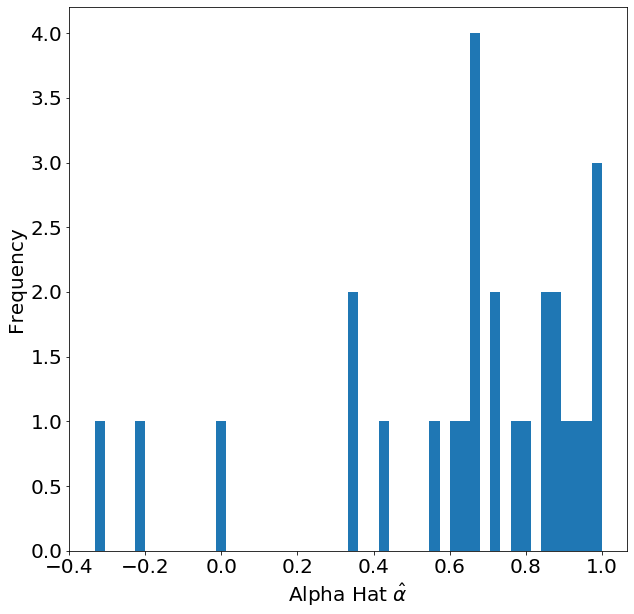

In [111]:
df_fitp.alpha_weighted.plot.hist(bins=50)
plt.xlabel(r"Alpha Hat $\hat{\alpha}$")

## Weekend TODO:  

- Rebuild Table 5, or delete

- rerun some data locally using ww0.4, without push (imagenet models)
- rerun colab notebooks from Serena using ww0.2.7 and ww0.4 and save data in new places
 - (similar to WW notebook, but on colab and local)
 
- updat all notebooks with code version
- fix code, upgrade to ww0.4.1 for paper

- maybe:  https://codeburst.io/cross-validation-calculating-r%C2%B2-and-accuracy-scores-after-loocv-5bd1015a50ec